In [5]:
import torch
import numpy as np
import pickle
import gzip
import numpy as np
import os
from torchvision import transforms
from unet import UNet
import PIL
from PIL import Image
import torchvision.models as models
from tqdm import tqdm
from matplotlib import pyplot as plt
import medpy.filter.smoothing as mp

from sklearn.decomposition import NMF
from skimage import exposure

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def crop_resize(image_obj, coords, x_size, y_size):
    width = image_obj.size[0]
    height = image_obj.size[1]
    coords = (coords[0]*width, coords[1]*height, coords[2]*width, coords[3]*height)
    cropped_image = image_obj.crop(coords)
    resized_image = cropped_image.resize((x_size, y_size), Image.ANTIALIAS)
    return(resized_image)

def augment(image, x_size, y_size, label=None):
    ratio = np.random.random()*(4/3-3/4)+3/4
    area = np.random.random()*0.5+0.5
    rot = (np.random.random()*2-1)*10
    h = np.sqrt(area/ratio)
    w = h*ratio
    x = (1 - w)*np.random.random()
    y = (1 - h)*np.random.random()
    crop_rect = (x,y, x+w, y+h)
        
    b = np.random.random()
    
    image = crop_resize(image, crop_rect, x_size, y_size)
    image = image.rotate(rot)
    converter = PIL.ImageEnhance.Brightness(image)
    #image = transforms.ToPILImage()(transforms.ToTensor()(converter.enhance((1.4-0.6)*b+0.6))+(torch.rand(image.size)-0.5)*1e-3)
    image = transforms.ToPILImage()(transforms.ToTensor()(converter.enhance(1))+(torch.rand(image.size)-0.5)*1e-3)
    image = transforms.Grayscale()(image)
    if label:
        label = label.rotate(rot)
        label = crop_resize(label, crop_rect, x_size, y_size)
        label = transforms.Grayscale()(label)
        return image, label
    return image

In [4]:
def rnmf(matrix2d, sparsity_coef, max_iter):
    i = 0
    model = NMF(n_components=2, init='random', random_state=0,
                max_iter=800, tol=0.00001)
    W = model.fit_transform(matrix2d)
    H = model.components_

    while i <= max_iter:
        W_old = W
        H_old = H
        # initialize S matrix
        S = matrix2d - np.matmul(W_old, H_old)

        # update S matrix
        S[S > sparsity_coef / 2] = S[S > sparsity_coef / 2] - sparsity_coef / 2
        S[S < sparsity_coef / 2] = 0

        # update W matrix
        W_new = W_old * (np.matmul(np.maximum(matrix2d - S, 0), H_old.T)) / \
                (np.matmul(np.matmul(W_old, H_old), H_old.T))
        nan_ind = np.isnan(W_new)
        inf_ind = np.isinf(W_new)
        W_new[nan_ind] = 0
        W_new[inf_ind] = 1
        W_new = W_new / np.linalg.norm(W_new, ord='fro', keepdims=True)

        # update H matrix
        H_new = H_old * (np.matmul(W_new.T, np.maximum(matrix2d - S, 0))) / \
                (np.matmul(np.matmul(W_new.T, W_new), H_old))
        nan_ind = np.isnan(H_new)
        inf_ind = np.isinf(H_new)
        H_new[nan_ind] = 0
        H_new[inf_ind] = 1

        # normalize W and H
        W = W_new
        # H = H_new
        H = H_new * np.linalg.norm(W_new, ord='fro', keepdims=True)
        i += 1

    return W, H, S

In [5]:
def RNMF_transform(video, max_iter = 100, sparsity_coef = 0.2):
    video = video / 255
    nf = video.shape[2]
    x = video.shape[0]
    y = video.shape[1]
    t = np.zeros((x*nf, y))
    for i in range(x*nf):
        for j in range(y):
            t[i][j] = video[i%x][j][i//x]
    
    W, H, S = rnmf(t, sparsity_coef, max_iter)
    
    new_video = np.zeros((x, y, nf))
    for i in range(x):
        for j in range(y):
            for k in range(nf):
                new_video[i][j][k] = S[i + x*k][j]
    return new_video

In [6]:
class Custom_dataset(torch.utils.data.Dataset):
    def __init__(self,
                 file_name,
                 chosen_indexes = [],
                 box_train = False,
                 augmented = False,
                 randomize = True,
                RNMF = False,
                size = (64, 64),
                crop_box = False,
                exposure = True):
        self.data = load_zipped_pickle(file_name)
        if len(chosen_indexes)>0:
            self.data = list([self.data[i] for i in chosen_indexes])
        
        if RNMF:
            for i in tqdm(range(len(self.data))):
                x = self.data[i]['video'].shape[0]
                self.data[i]['video'] = RNMF_transform(self.data[i]['video'])
        self.augmented = augmented
        self.video_index = []
        self.names = []
        self.box_train = box_train
        self.crop_box = crop_box
        self.exposure = exposure
        
        self.size = size
        
        
        if box_train:
            count = 0
            for i in range(len(self.data)):
                self.video_index.append(count)
                count += self.data[i]['video'].shape[2]
                for _ in range(self.data[i]['video'].shape[2]):
                    self.names.append(self.data[i]['name'])
            self.video_index.append(count)
                
            self.indexer = list(range(count))
        else:
            for i in range(len(self.data)):
                for _ in range(3):
                    self.names.append(self.data[i]['name'])
            self.indexer = list(range(len(self.data)*3))
            
        if randomize:
            np.random.shuffle(self.indexer)
            
        self.names = [self.names[self.indexer[i]] for i in range(len(self.indexer))]
            
        self.transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                                                    std=0.378),
                              #transforms.Normalize(mean=0.591,
                              #                     std = 1)
                              #                      std=0.189),
                              transforms.RandomErasing(p=0.3*int(augmented), scale=(0.02, 0.2),
                                                       ratio=(0.3, 3.3), value=0,
                                                       inplace=False)
                        ])
    def __getitem__(self, index):
        real_idx = self.indexer[index]
        if self.box_train:
            old_count = 0
            for i, count in enumerate(self.video_index):
                if real_idx >= count:
                    old_count = count
                    continue
                else:
                    #t = torch.Tensor(exposure.equalize_hist(self.data[i-1]['video'][:, :, real_idx - old_count]))
                    t = torch.Tensor(self.data[i-1]['video'][:, :, real_idx - old_count])
                    image = transforms.ToPILImage()(t)
                    box = transforms.ToPILImage()(torch.Tensor(self.data[i-1]['box']))
                    if self.augmented:
                        image, box = augment(image, self.size[0], self.size[1], box)
                    else:
                        image = image.resize(self.size)
                        box = box.resize(self.size)
                    label_box = torch.Tensor([min(np.where(box)[1])/box.size[1],
                                              min(np.where(box)[0])/box.size[0],
                                              max(np.where(box)[1])/box.size[1],
                                              max(np.where(box)[0])/box.size[0]])
                    return self.transform(image), label_box
        else:
            if self.exposure:
                image = transforms.ToPILImage()(torch.Tensor(exposure.equalize_hist(self.data[real_idx//3]['video'][:, :, self.data[real_idx//3]['frames'][real_idx%3]])))
            else:
                image = transforms.ToPILImage()(torch.Tensor(self.data[real_idx//3]['video'][:, :, self.data[real_idx//3]['frames'][real_idx%3]]))
            box = transforms.ToPILImage()(torch.Tensor(self.data[real_idx//3]['box']))
            label = transforms.ToPILImage()(torch.Tensor(self.data[real_idx//3]['label'][:, :, self.data[real_idx//3]['frames'][real_idx%3]]))
            if self.crop_box:
                image = crop_resize(image, [min(np.where(box)[1])/box.size[0],
                                            min(np.where(box)[0])/box.size[1],
                                            max(np.where(box)[1])/box.size[0],
                                            max(np.where(box)[0])/box.size[1]],
                                   self.size[0],
                                   self.size[1])
                label = crop_resize(label, [min(np.where(box)[1])/box.size[1],
                                            min(np.where(box)[0])/box.size[0],
                                            max(np.where(box)[1])/box.size[1],
                                            max(np.where(box)[0])/box.size[0]],
                                   self.size[0],
                                   self.size[1])
            if self.augmented:
                image, label = augment(image, self.size[0], self.size[1], label)
            else:
                image = image.resize(self.size)
                label = label.resize(self.size)

            x = self.transform(image)
            label = transforms.ToTensor()(transforms.Grayscale()(label))
            return x, label
        print('error', real_idx, self.video_index)
    def __len__(self):
        return(len(self.indexer))

In [7]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [8]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)
        
        assert target.shape == prediction.shape
        assert np.max(target)
            
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    #print("Median IOU: ", np.median(ious))
    return np.median(ious)
    
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 validation_names: list = [],
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 box_training: bool = False
                 ):

        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.validation_names = validation_names
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.box_training = box_training
        self.best_score = 0

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        best_score = 0
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                print(best_score)
                score = self._validate()
            
            if self.box_training:
                name = 'best_model_box_128.pth'
            else:
                name = 'best_model_unet_nobo_128_thirteenth_bis3.pth'
                
            if score > best_score:
                torch.save(self.model.state_dict(), name)
                best_score = score
                print('saved with score: ', best_score)
                self.best_score = best_score

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.step()  # learning rate scheduler step
        self.model.load_state_dict(torch.load(name))
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            if self.box_training:
                out = self.model(input) # one forward pass
            else:
                out = self.model(input).clamp(0,1) # one forward pass
            """print(target[0][0][torch.argmax(target)//128][torch.argmax(target)%128])
            print(out[0][0][torch.argmax(target)//128][torch.argmax(target)%128])
            print(out[0][1][torch.argmax(target)//128][torch.argmax(target)%128])
            print(target[0][0][0][0])
            print(out[0][0][0][0])
            print(out[0][1][0][0])"""
            loss = self.criterion(out, target)  # calculate loss

            #print(torch.max((torch.argmax(out, dim = 1)).float().cpu()) , torch.max(target.squeeze(dim = 1).cpu()))
            
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)
        
        predictions = []
        targets = []
        ious = []
        
        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            #target = target.type(torch.cuda.LongTensor)

            with torch.no_grad():
                if self.box_training:
                    out = self.model(input)
                else:
                    out = self.model(input).clamp(0,1)
                    if i%12 == 0:
                        display(transforms.ToPILImage()((out>0.5).float()[0]))
                        display(transforms.ToPILImage()(target[0]))
                #loss = self.criterion(out, target.squeeze(dim = 1)).mean()
                loss = self.criterion(out, target)
            
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')
                
                for k in range(out.size(0)):
                    if not self.box_training:
                        #p = {'name': self.validation_names[i], 'prediction': (torch.argmax(out, dim = 1)).float().cpu()}
                        #t = {'name': self.validation_names[i], 'label': target.squeeze(dim = 1).cpu()}
                        p = {'name': self.validation_names[i], 'prediction': (out[k]>0.5).cpu()}
                        t = {'name': self.validation_names[i], 'label': target[k].cpu()}

                        predictions.append(p)
                        targets.append(t)

                        evaluate(predictions, targets)
                    else:
                        ious.append(bb_intersection_over_union(out[k].cpu(), target[k].cpu()).item())

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()
        if self.box_training:
            print("Median IOU: ", np.median(ious))
            return np.median(ious)
        else:
            print("Median IOU: ", evaluate(predictions, targets))
            return evaluate(predictions, targets)

In [11]:
#eval_indexes = np.random.choice(list(range(0, 39)), 10, replace = False)
#chosen_indexes = np.setdiff1d(np.array(list(range(65))), eval_indexes)

In [10]:
chosen_indexes = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 46, 47, 48, 49, 50, 52, 53, 54, 56, 57,
       58, 59, 62, 64])

In [11]:
eval_indexes = np.array([51, 40, 43, 55, 42, 44, 63, 60, 45, 61])

In [49]:
#chosen_indexes = np.random.choice(list(range(65)), 55, replace = False)
#eval_indexes = np.setdiff1d(np.array(list(range(65))), chosen_indexes)
#eval_indexes = chosen_indexes
train_ds = Custom_dataset('train.pkl', chosen_indexes = chosen_indexes,
                          box_train = False, augmented = False, randomize = True,
                          size = (128, 128), crop_box = False, RNMF=True, exposure = False)
eval_ds = Custom_dataset('train.pkl', chosen_indexes = eval_indexes,
                         box_train = False, augmented = False, randomize = False,
                         size = (128, 128), crop_box = False, RNMF = True, exposure = False)

100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


In [31]:
train_ds2 = Custom_dataset('train.pkl', chosen_indexes = chosen_indexes,
                          box_train = False, augmented = True, randomize = True,
                          size = (128, 128), crop_box = False, RNMF=False, exposure = False)
eval_ds2 = Custom_dataset('train.pkl', chosen_indexes = eval_indexes,
                         box_train = False, augmented = False, randomize = False,
                         size = (128, 128), crop_box = False, RNMF = False, exposure = False)

In [32]:
dataloader_training = torch.utils.data.DataLoader(train_ds2, batch_size = 10, shuffle = True)
dataloader_validation = torch.utils.data.DataLoader(eval_ds2, batch_size = 1, shuffle = True)

In [21]:
x = train_ds2[9][0][0]

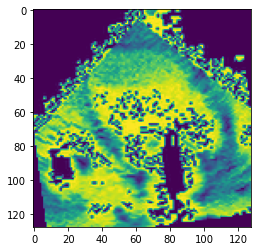

In [22]:
plt.imshow(x)

In [ ]:
plt.imshow(eval_ds[9][1][0])

Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

0


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

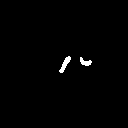

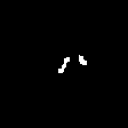

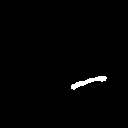

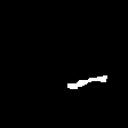

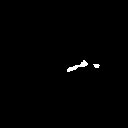

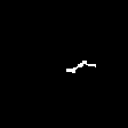

Median IOU:  0.5604336350994693
saved with score:  0.5604336350994693


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.5604336350994693


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

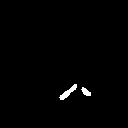

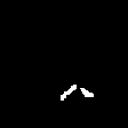

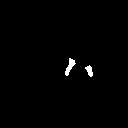

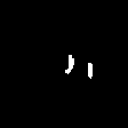

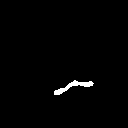

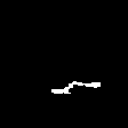

Median IOU:  0.5968217683061721
saved with score:  0.5968217683061721


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.5968217683061721


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

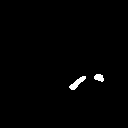

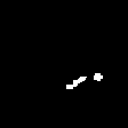

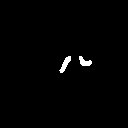

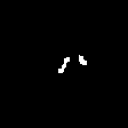

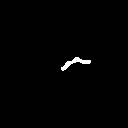

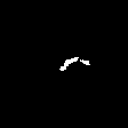

Median IOU:  0.5973332881539712
saved with score:  0.5973332881539712


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.5973332881539712


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

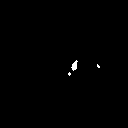

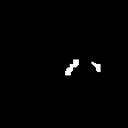

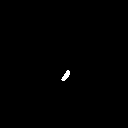

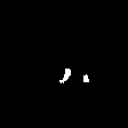

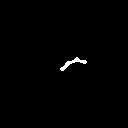

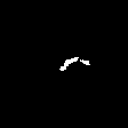

Median IOU:  0.5343735797606424


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.5973332881539712


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

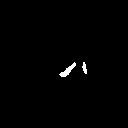

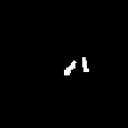

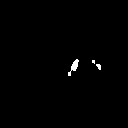

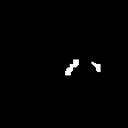

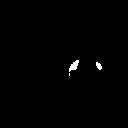

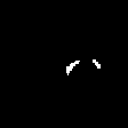

Median IOU:  0.57778898846618


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.5973332881539712


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

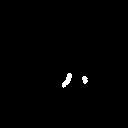

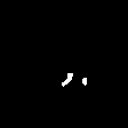

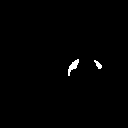

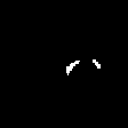

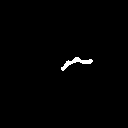

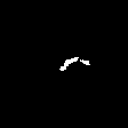

Median IOU:  0.5851461401160196


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.5973332881539712


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

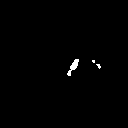

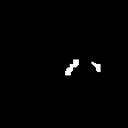

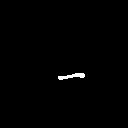

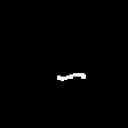

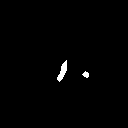

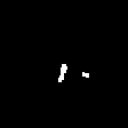

Median IOU:  0.6112031351001939
saved with score:  0.6112031351001939


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6112031351001939


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

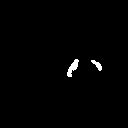

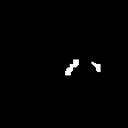

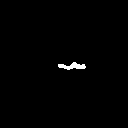

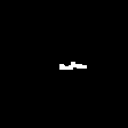

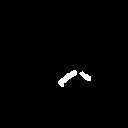

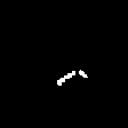

Median IOU:  0.6302224633749322
saved with score:  0.6302224633749322


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

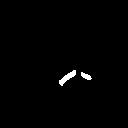

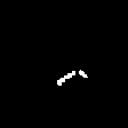

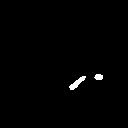

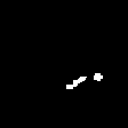

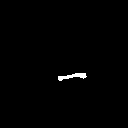

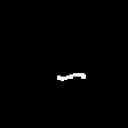

Median IOU:  0.5831724581724582


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

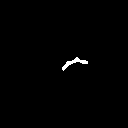

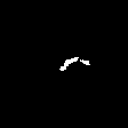

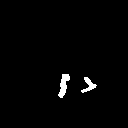

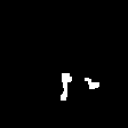

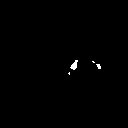

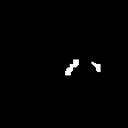

Median IOU:  0.5408724340175952


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

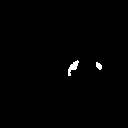

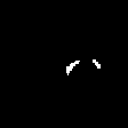

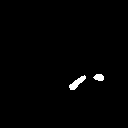

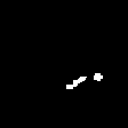

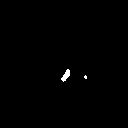

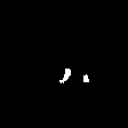

Median IOU:  0.6209387824897401


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

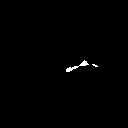

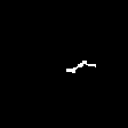

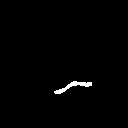

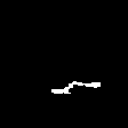

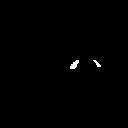

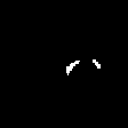

Median IOU:  0.5186350509195927


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

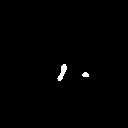

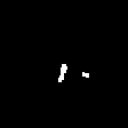

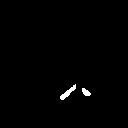

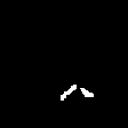

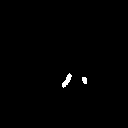

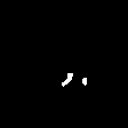

Median IOU:  0.5247101944897494


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

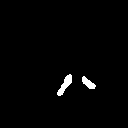

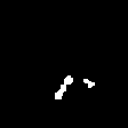

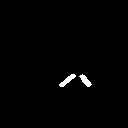

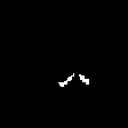

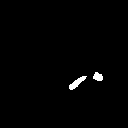

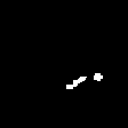

Median IOU:  0.6190486181045094


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

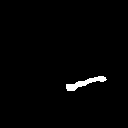

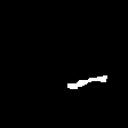

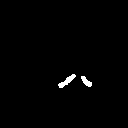

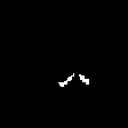

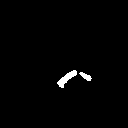

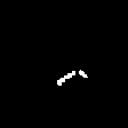

Median IOU:  0.6000822119337113


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

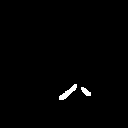

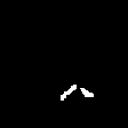

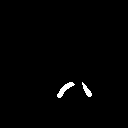

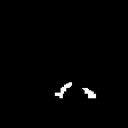

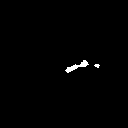

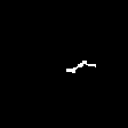

Median IOU:  0.6093892607240645


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

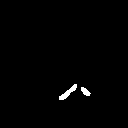

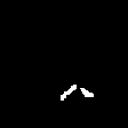

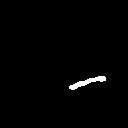

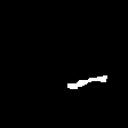

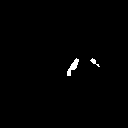

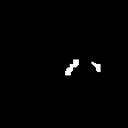

Median IOU:  0.5972352115969137


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

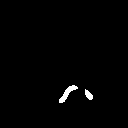

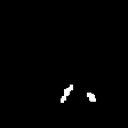

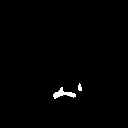

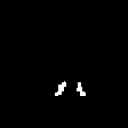

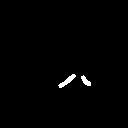

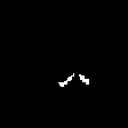

Median IOU:  0.5921663442940038


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

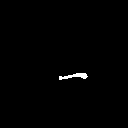

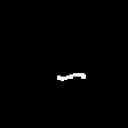

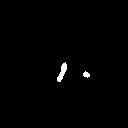

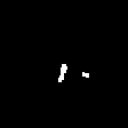

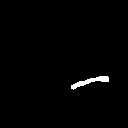

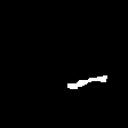

Median IOU:  0.5688461538461538


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

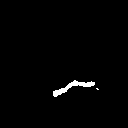

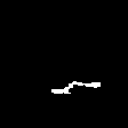

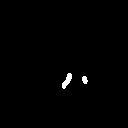

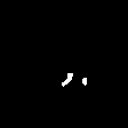

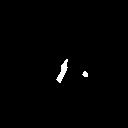

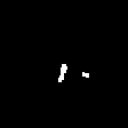

Median IOU:  0.5906894329896908


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

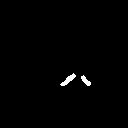

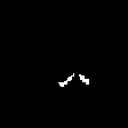

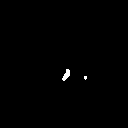

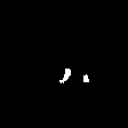

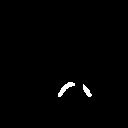

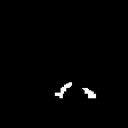

Median IOU:  0.581200467714694


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

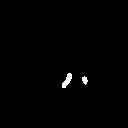

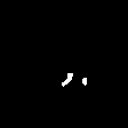

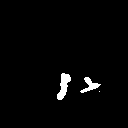

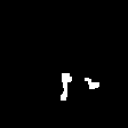

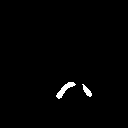

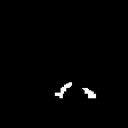

Median IOU:  0.6251540616246498


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

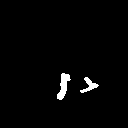

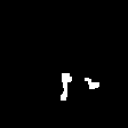

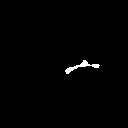

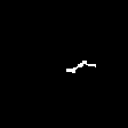

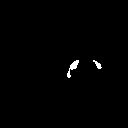

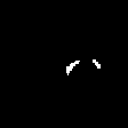

Median IOU:  0.5796197266785502


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

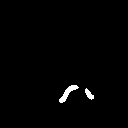

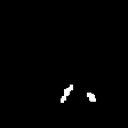

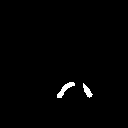

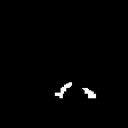

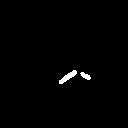

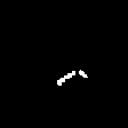

Median IOU:  0.5782389532389531


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

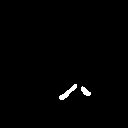

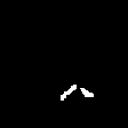

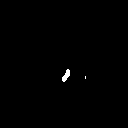

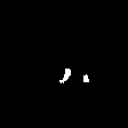

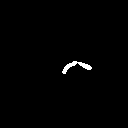

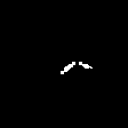

Median IOU:  0.5661100917431192


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

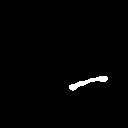

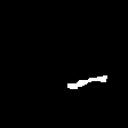

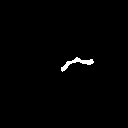

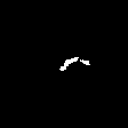

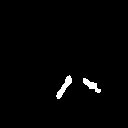

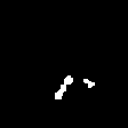

Median IOU:  0.589060454124485


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

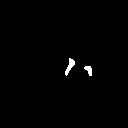

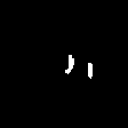

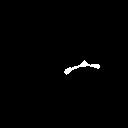

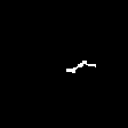

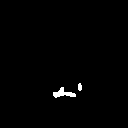

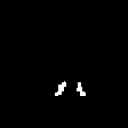

Median IOU:  0.609045358649789


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

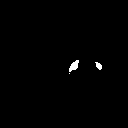

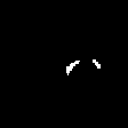

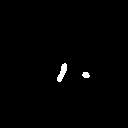

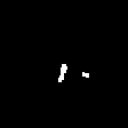

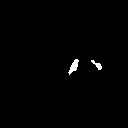

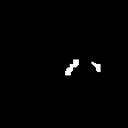

Median IOU:  0.6207902211401908


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

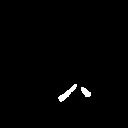

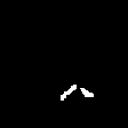

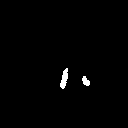

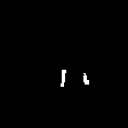

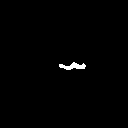

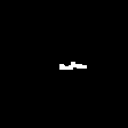

Median IOU:  0.6226851851851851


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

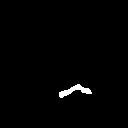

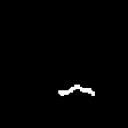

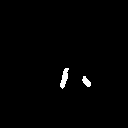

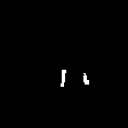

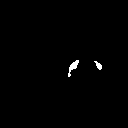

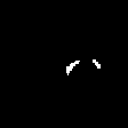

Median IOU:  0.6177643784786642


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6302224633749322


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

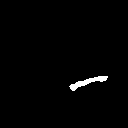

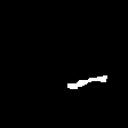

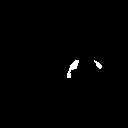

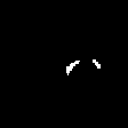

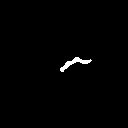

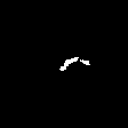

Median IOU:  0.6351750972762646
saved with score:  0.6351750972762646


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

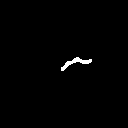

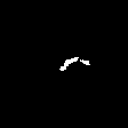

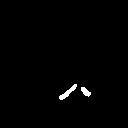

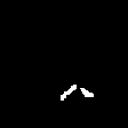

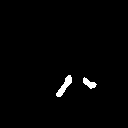

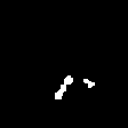

Median IOU:  0.5953757225433527


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

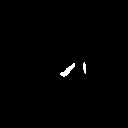

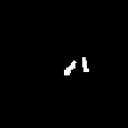

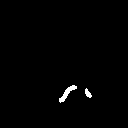

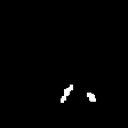

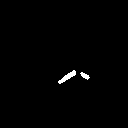

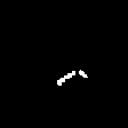

Median IOU:  0.5333473650977401


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

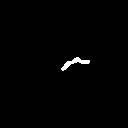

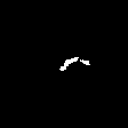

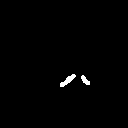

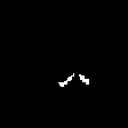

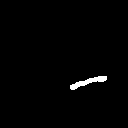

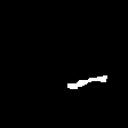

Median IOU:  0.5946313946702977


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

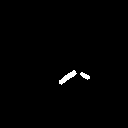

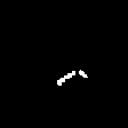

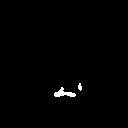

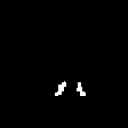

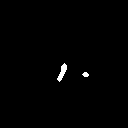

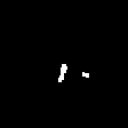

Median IOU:  0.5743874927863176


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

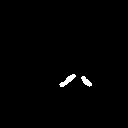

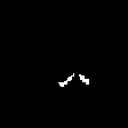

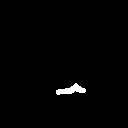

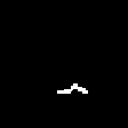

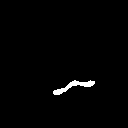

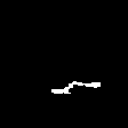

Median IOU:  0.6069056622067093


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

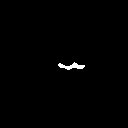

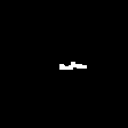

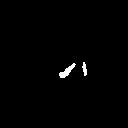

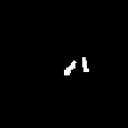

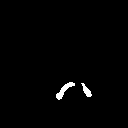

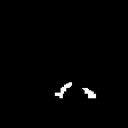

Median IOU:  0.6001898604269293


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

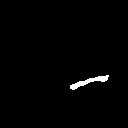

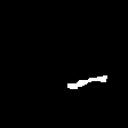

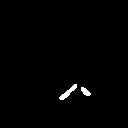

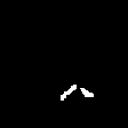

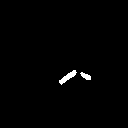

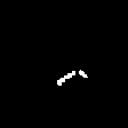

Median IOU:  0.5790498442367602


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

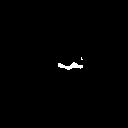

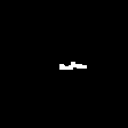

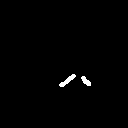

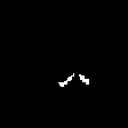

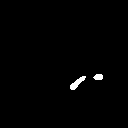

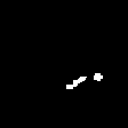

Median IOU:  0.5905643203883495


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

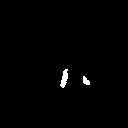

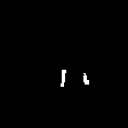

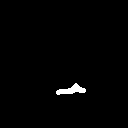

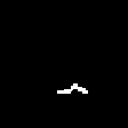

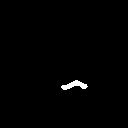

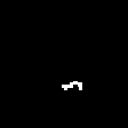

Median IOU:  0.5927033492822966


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

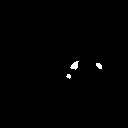

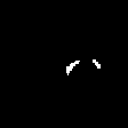

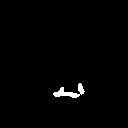

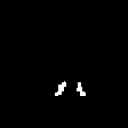

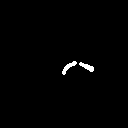

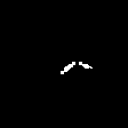

Median IOU:  0.5961902243557147


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6351750972762646


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

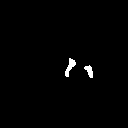

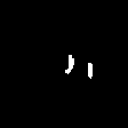

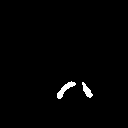

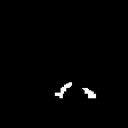

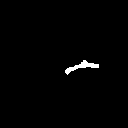

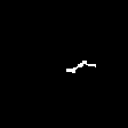

Median IOU:  0.6476833976833978
saved with score:  0.6476833976833978


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6476833976833978


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

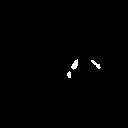

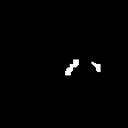

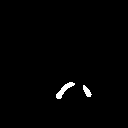

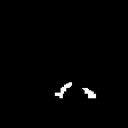

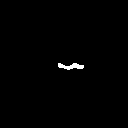

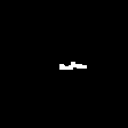

Median IOU:  0.6033609153131065


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6476833976833978


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

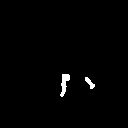

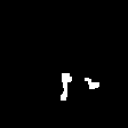

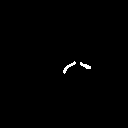

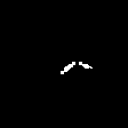

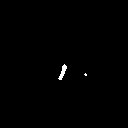

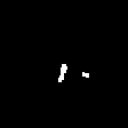

Median IOU:  0.36139362286970866


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6476833976833978


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

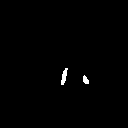

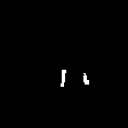

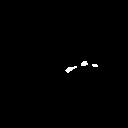

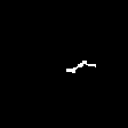

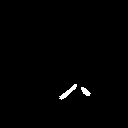

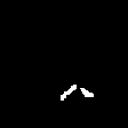

Median IOU:  0.5252450980392157


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6476833976833978


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

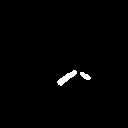

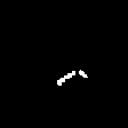

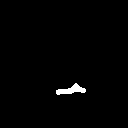

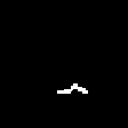

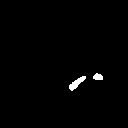

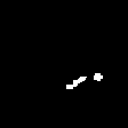

Median IOU:  0.6489688740873576
saved with score:  0.6489688740873576


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

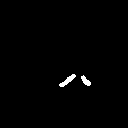

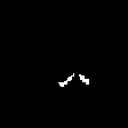

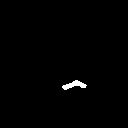

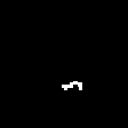

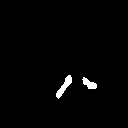

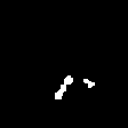

Median IOU:  0.5969611528822055


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

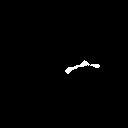

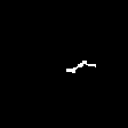

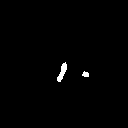

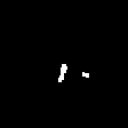

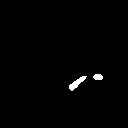

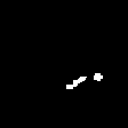

Median IOU:  0.607137118802018


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

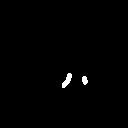

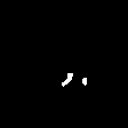

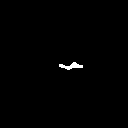

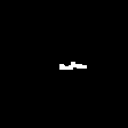

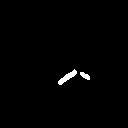

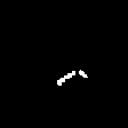

Median IOU:  0.6101752021563343


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

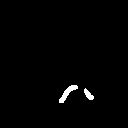

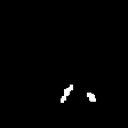

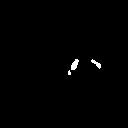

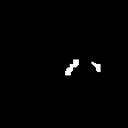

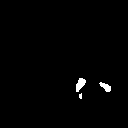

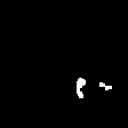

Median IOU:  0.5849200206398348


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

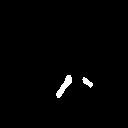

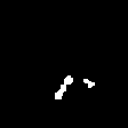

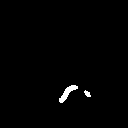

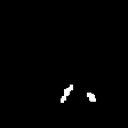

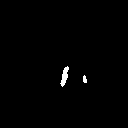

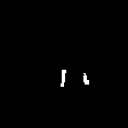

Median IOU:  0.5301709873138445


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

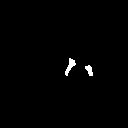

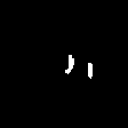

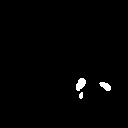

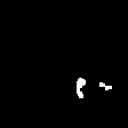

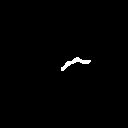

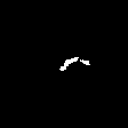

Median IOU:  0.6062424516908212


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

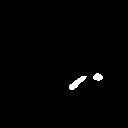

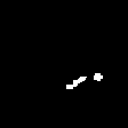

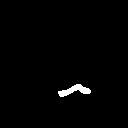

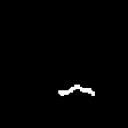

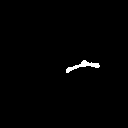

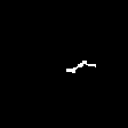

Median IOU:  0.6462812711291414


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

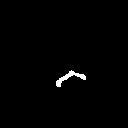

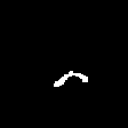

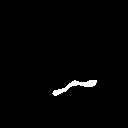

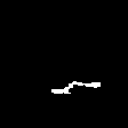

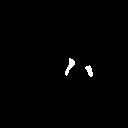

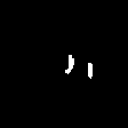

Median IOU:  0.5998519012953423


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

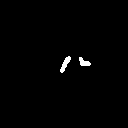

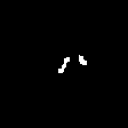

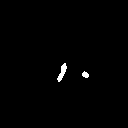

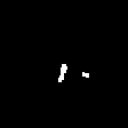

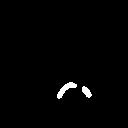

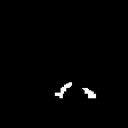

Median IOU:  0.6084583645911478


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

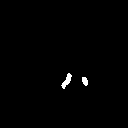

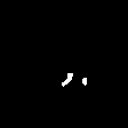

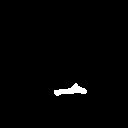

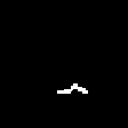

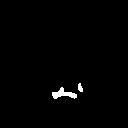

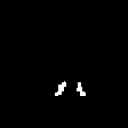

Median IOU:  0.6080210772833723


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

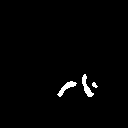

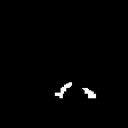

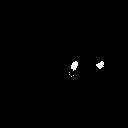

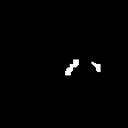

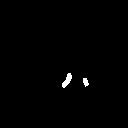

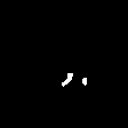

Median IOU:  0.5142502762311243


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

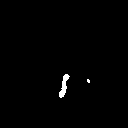

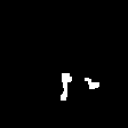

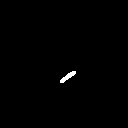

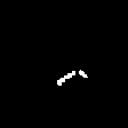

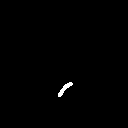

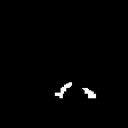

Median IOU:  0.29388888888888887


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

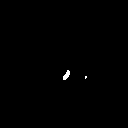

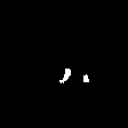

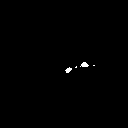

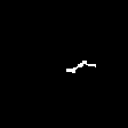

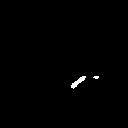

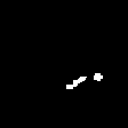

Median IOU:  0.45060742599669196


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

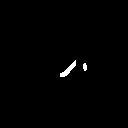

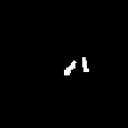

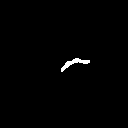

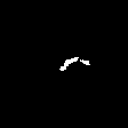

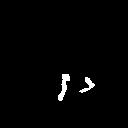

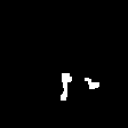

Median IOU:  0.49835635359116026


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

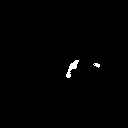

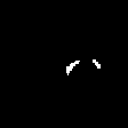

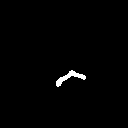

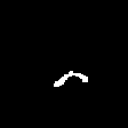

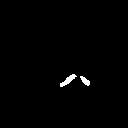

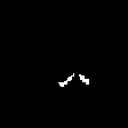

Median IOU:  0.5861868237227776


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

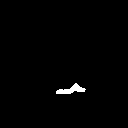

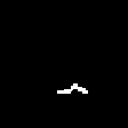

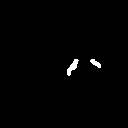

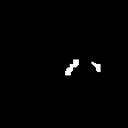

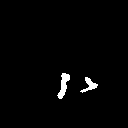

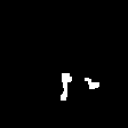

Median IOU:  0.5823334452089277


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

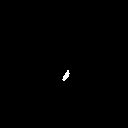

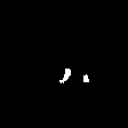

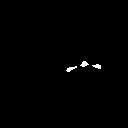

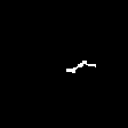

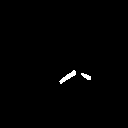

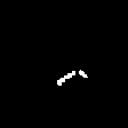

Median IOU:  0.4841456736035049


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

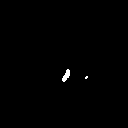

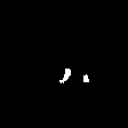

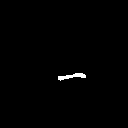

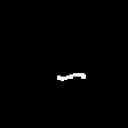

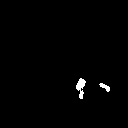

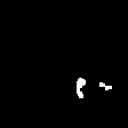

Median IOU:  0.5804597701149425


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

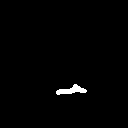

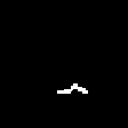

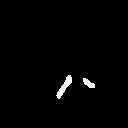

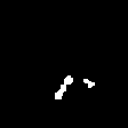

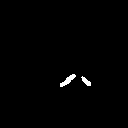

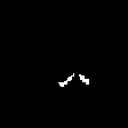

Median IOU:  0.5785032200755053


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

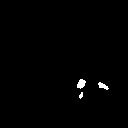

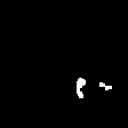

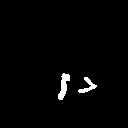

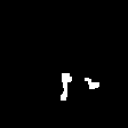

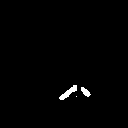

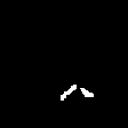

Median IOU:  0.5798130778055199


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

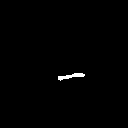

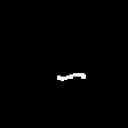

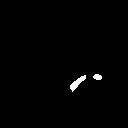

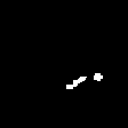

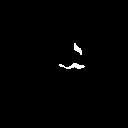

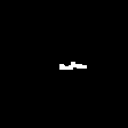

Median IOU:  0.5893817204301075


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

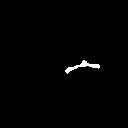

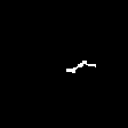

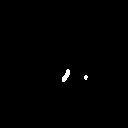

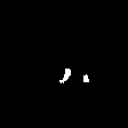

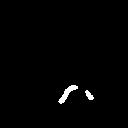

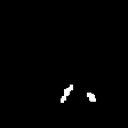

Median IOU:  0.5901854007316263


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

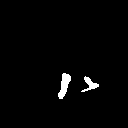

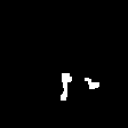

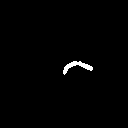

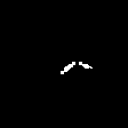

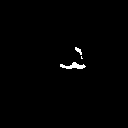

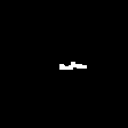

Median IOU:  0.6151573066745075


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

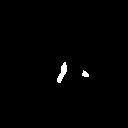

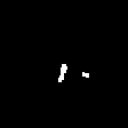

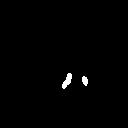

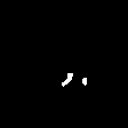

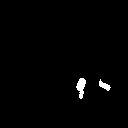

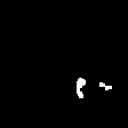

Median IOU:  0.6365674684060334


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

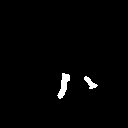

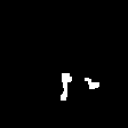

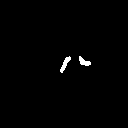

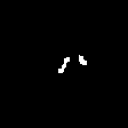

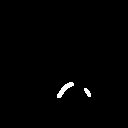

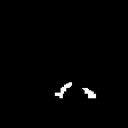

Median IOU:  0.569327731092437


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

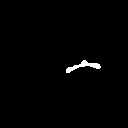

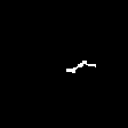

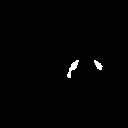

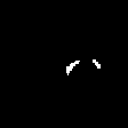

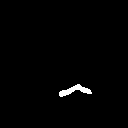

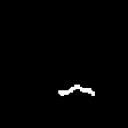

Median IOU:  0.6369868173258004


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

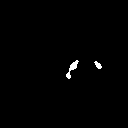

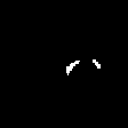

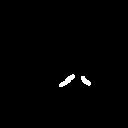

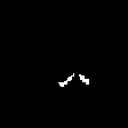

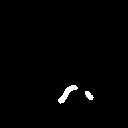

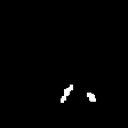

Median IOU:  0.6318250377073906


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

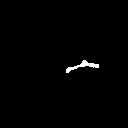

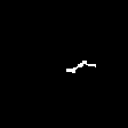

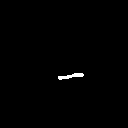

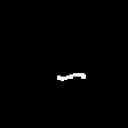

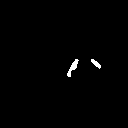

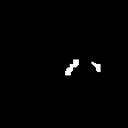

Median IOU:  0.6005973353886809


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

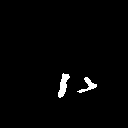

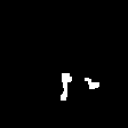

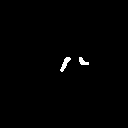

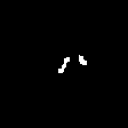

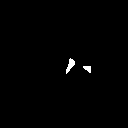

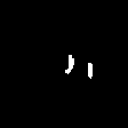

Median IOU:  0.5593239076045848


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

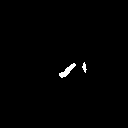

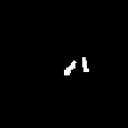

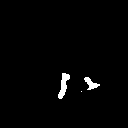

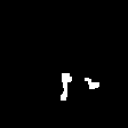

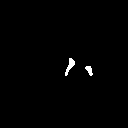

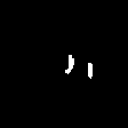

Median IOU:  0.5775288469636992


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

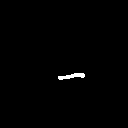

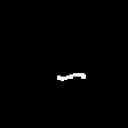

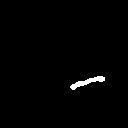

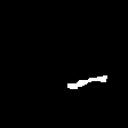

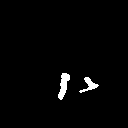

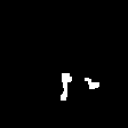

Median IOU:  0.6014151929428488


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

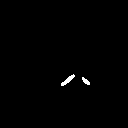

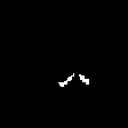

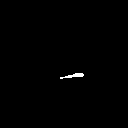

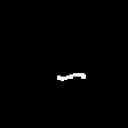

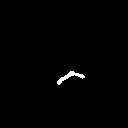

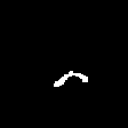

Median IOU:  0.4921763216788348


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

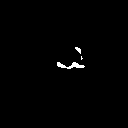

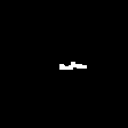

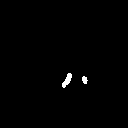

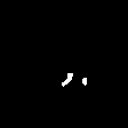

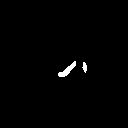

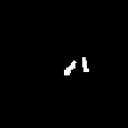

Median IOU:  0.6081744538090172


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

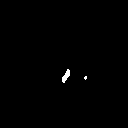

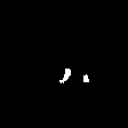

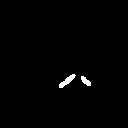

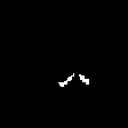

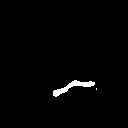

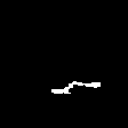

Median IOU:  0.6174655908875177


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

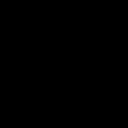

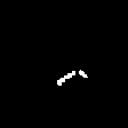

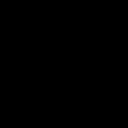

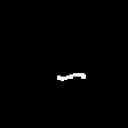

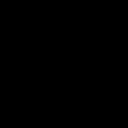

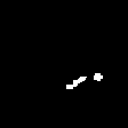

Median IOU:  0.0


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

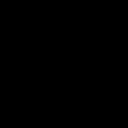

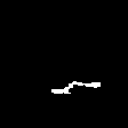

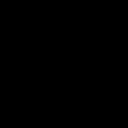

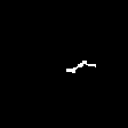

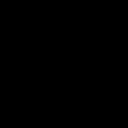

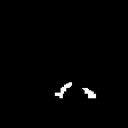

Median IOU:  0.0


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

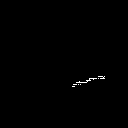

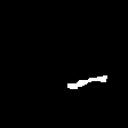

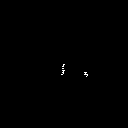

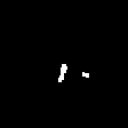

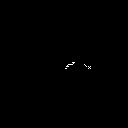

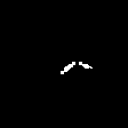

Median IOU:  0.14194139194139194


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

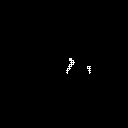

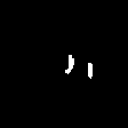

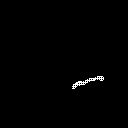

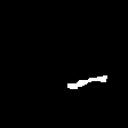

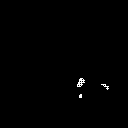

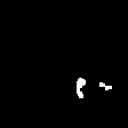

Median IOU:  0.3607511737089202


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

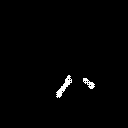

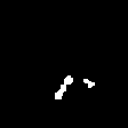

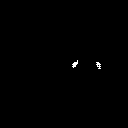

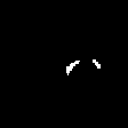

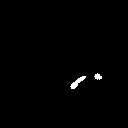

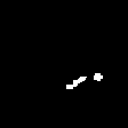

Median IOU:  0.48411632036086183


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

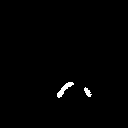

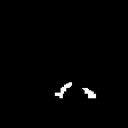

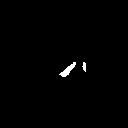

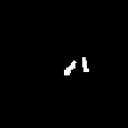

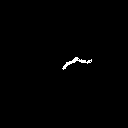

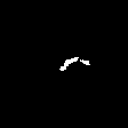

Median IOU:  0.5437776623890413


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

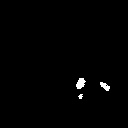

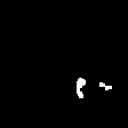

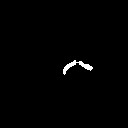

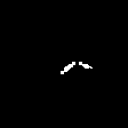

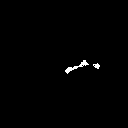

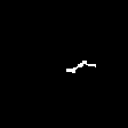

Median IOU:  0.6067671809256663


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

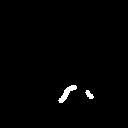

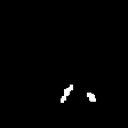

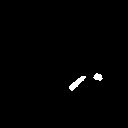

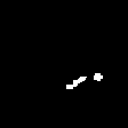

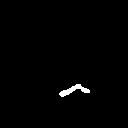

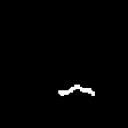

Median IOU:  0.6018877404536319


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

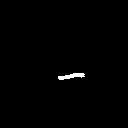

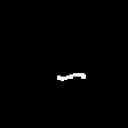

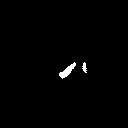

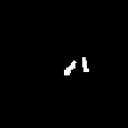

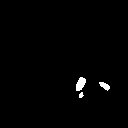

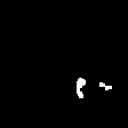

Median IOU:  0.6257875474844807


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

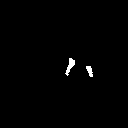

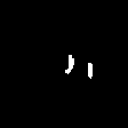

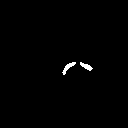

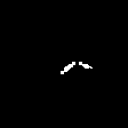

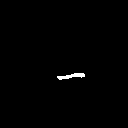

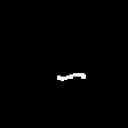

Median IOU:  0.5859605911330049


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

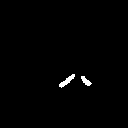

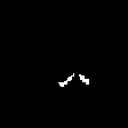

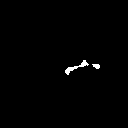

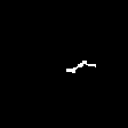

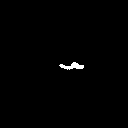

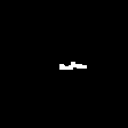

Median IOU:  0.6232881937821857


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

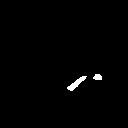

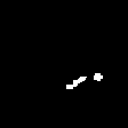

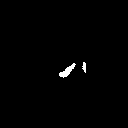

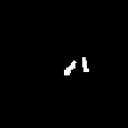

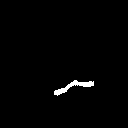

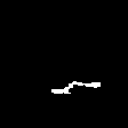

Median IOU:  0.6013573653760569


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

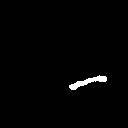

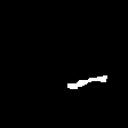

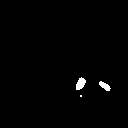

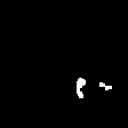

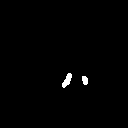

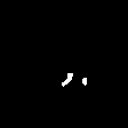

Median IOU:  0.6280333719135802


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

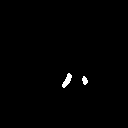

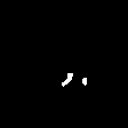

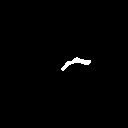

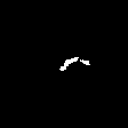

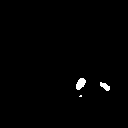

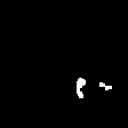

Median IOU:  0.6069494802997342


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

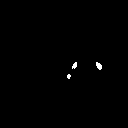

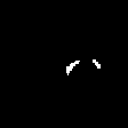

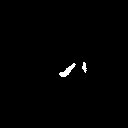

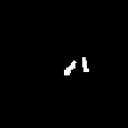

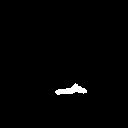

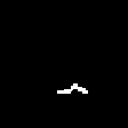

Median IOU:  0.5845016876228627


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

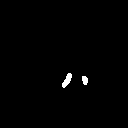

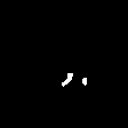

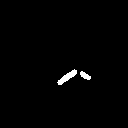

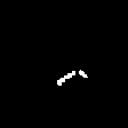

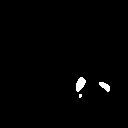

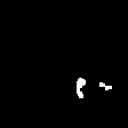

Median IOU:  0.6477272727272727


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

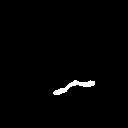

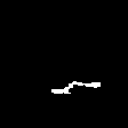

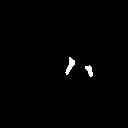

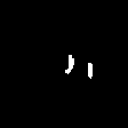

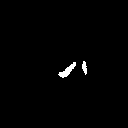

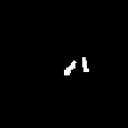

Median IOU:  0.6234685456738399


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

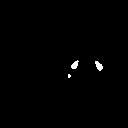

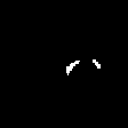

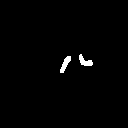

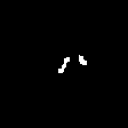

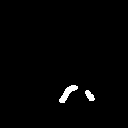

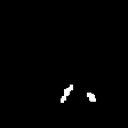

Median IOU:  0.6218494368701837


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

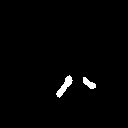

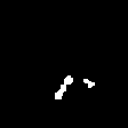

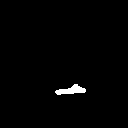

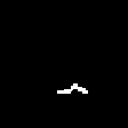

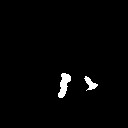

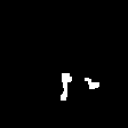

Median IOU:  0.5929928989139516


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

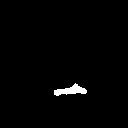

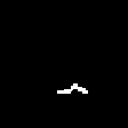

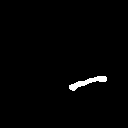

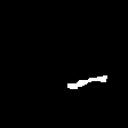

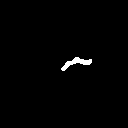

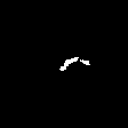

Median IOU:  0.6333610303282093


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

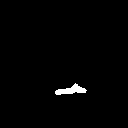

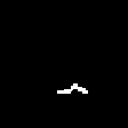

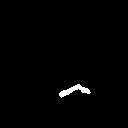

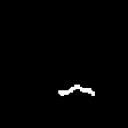

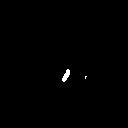

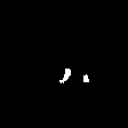

Median IOU:  0.5958715596330275


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

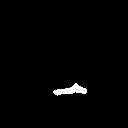

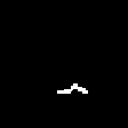

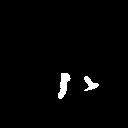

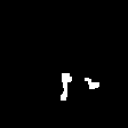

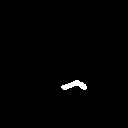

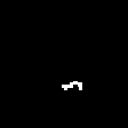

Median IOU:  0.6221139971139971


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

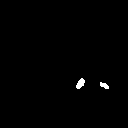

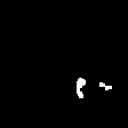

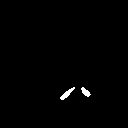

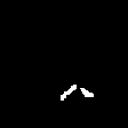

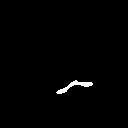

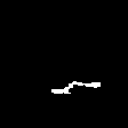

Median IOU:  0.49265230418033956


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

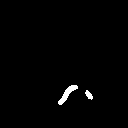

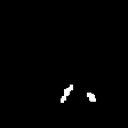

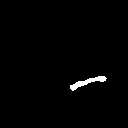

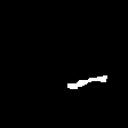

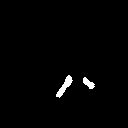

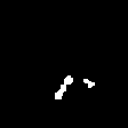

Median IOU:  0.5913062707690837


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

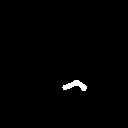

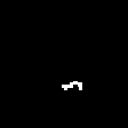

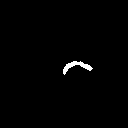

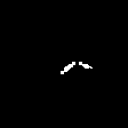

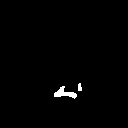

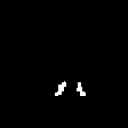

Median IOU:  0.5973652574634342


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

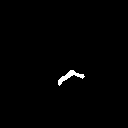

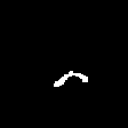

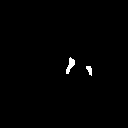

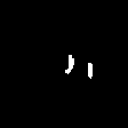

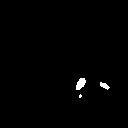

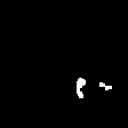

Median IOU:  0.5583058305830584


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

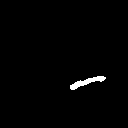

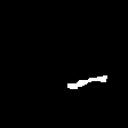

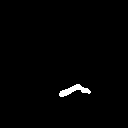

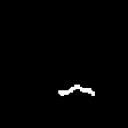

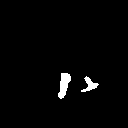

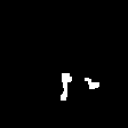

Median IOU:  0.6181606985500281


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

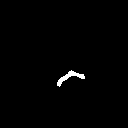

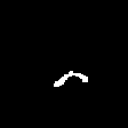

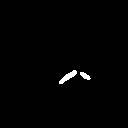

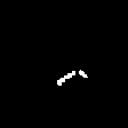

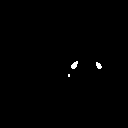

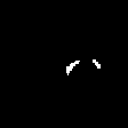

Median IOU:  0.5861617794196875


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

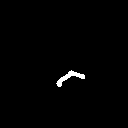

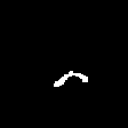

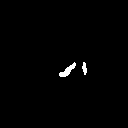

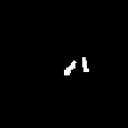

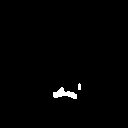

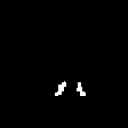

Median IOU:  0.5953268539475436


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

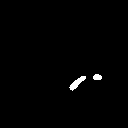

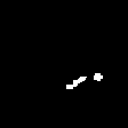

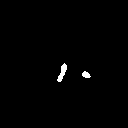

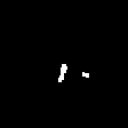

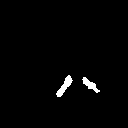

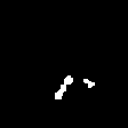

Median IOU:  0.6099759615384616


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

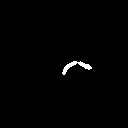

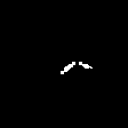

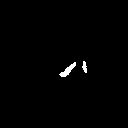

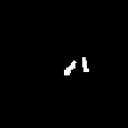

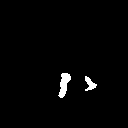

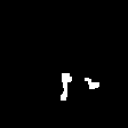

Median IOU:  0.5915487162606978


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

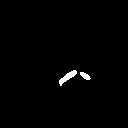

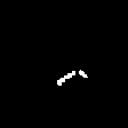

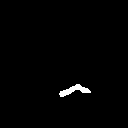

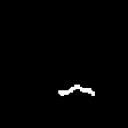

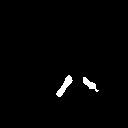

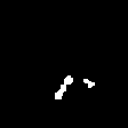

Median IOU:  0.6151851851851852


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

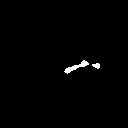

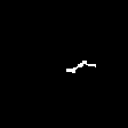

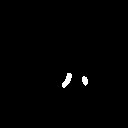

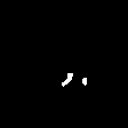

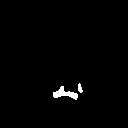

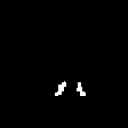

Median IOU:  0.6226820289064631


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

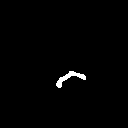

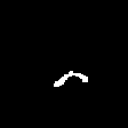

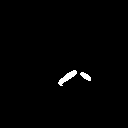

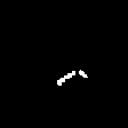

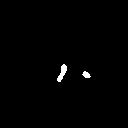

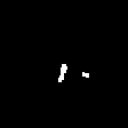

Median IOU:  0.6091269841269842


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

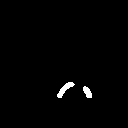

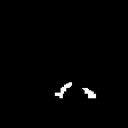

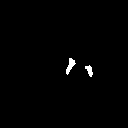

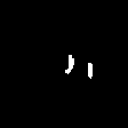

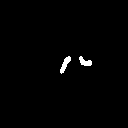

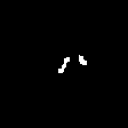

Median IOU:  0.6139322916666667


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

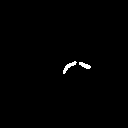

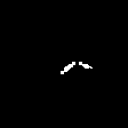

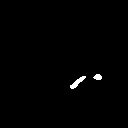

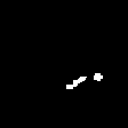

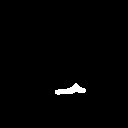

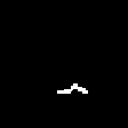

Median IOU:  0.5462172056131788


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

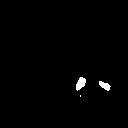

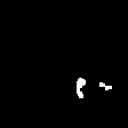

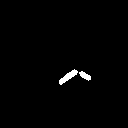

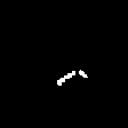

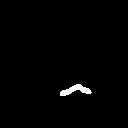

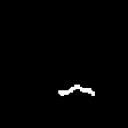

Median IOU:  0.6105978260869566


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

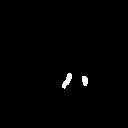

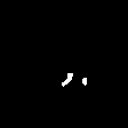

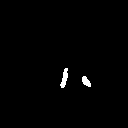

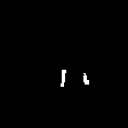

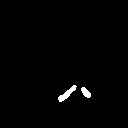

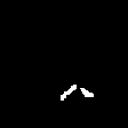

Median IOU:  0.6200718768438556


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

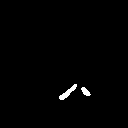

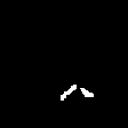

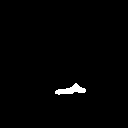

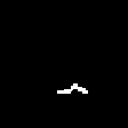

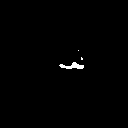

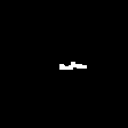

Median IOU:  0.5938036504924551


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

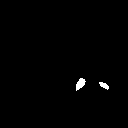

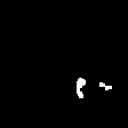

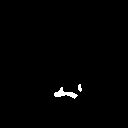

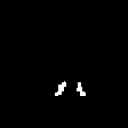

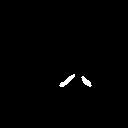

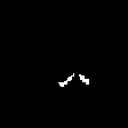

Median IOU:  0.5912790697674419


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

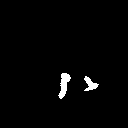

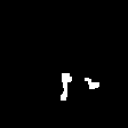

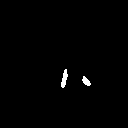

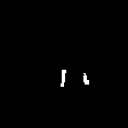

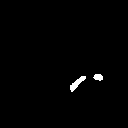

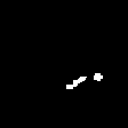

Median IOU:  0.5902878032878498


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

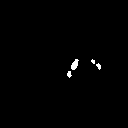

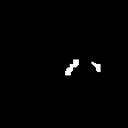

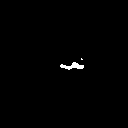

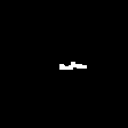

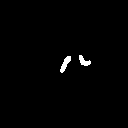

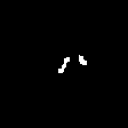

Median IOU:  0.6274045261669023


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

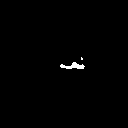

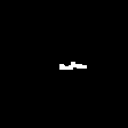

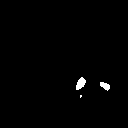

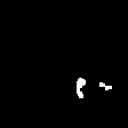

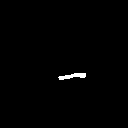

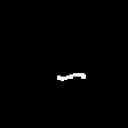

Median IOU:  0.6016759776536313


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

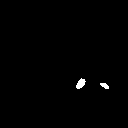

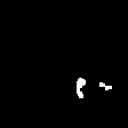

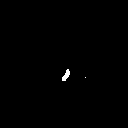

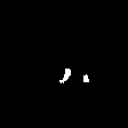

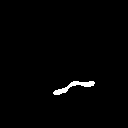

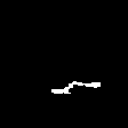

Median IOU:  0.5761912128712872


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

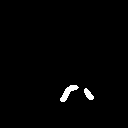

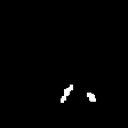

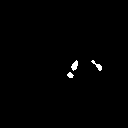

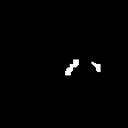

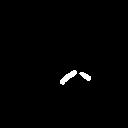

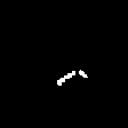

Median IOU:  0.6070888030888031


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

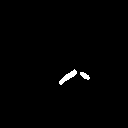

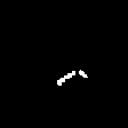

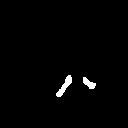

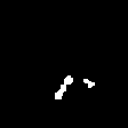

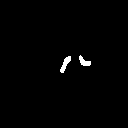

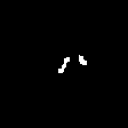

Median IOU:  0.5997984420112219


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

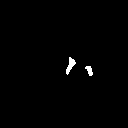

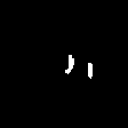

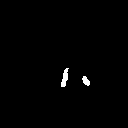

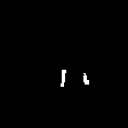

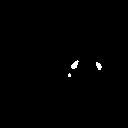

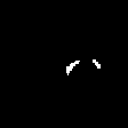

Median IOU:  0.6073809523809524


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

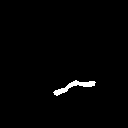

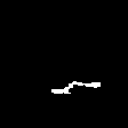

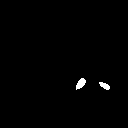

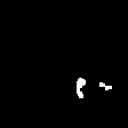

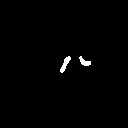

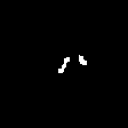

Median IOU:  0.596509162501893


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

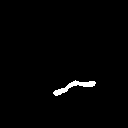

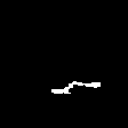

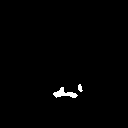

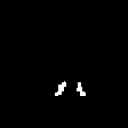

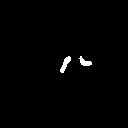

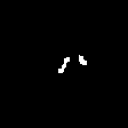

Median IOU:  0.6036100508905853


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

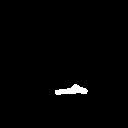

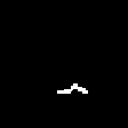

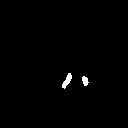

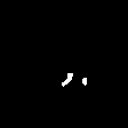

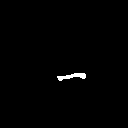

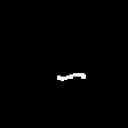

Median IOU:  0.6084100306789382


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

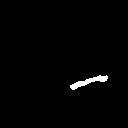

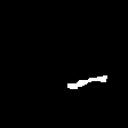

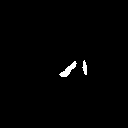

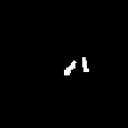

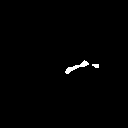

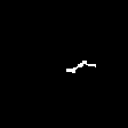

Median IOU:  0.6071024258760108


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

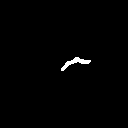

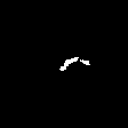

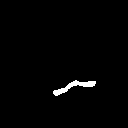

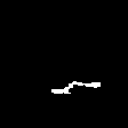

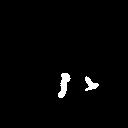

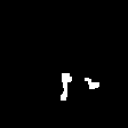

Median IOU:  0.6132625698324022


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

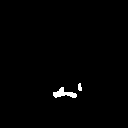

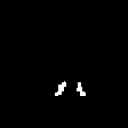

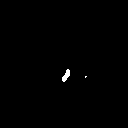

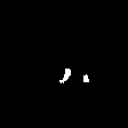

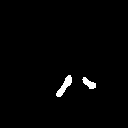

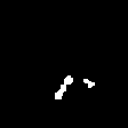

Median IOU:  0.6104613866271897


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

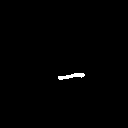

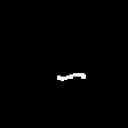

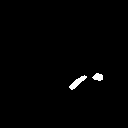

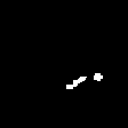

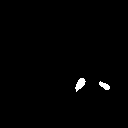

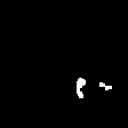

Median IOU:  0.6122448979591837


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

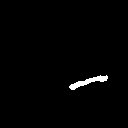

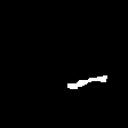

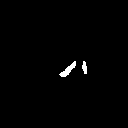

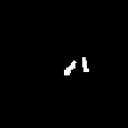

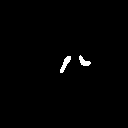

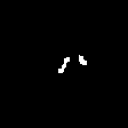

Median IOU:  0.6077096848934198


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

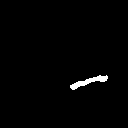

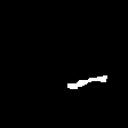

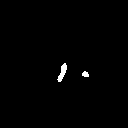

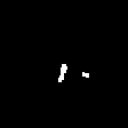

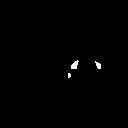

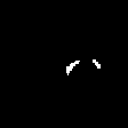

Median IOU:  0.6165413533834587


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

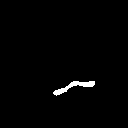

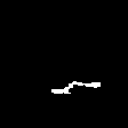

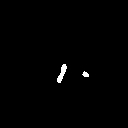

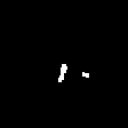

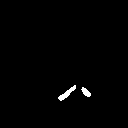

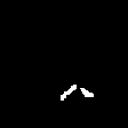

Median IOU:  0.5880376344086022


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

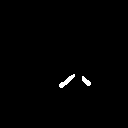

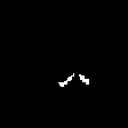

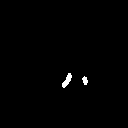

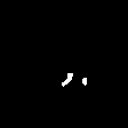

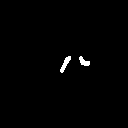

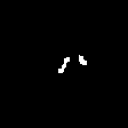

Median IOU:  0.5794715447154472


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

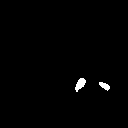

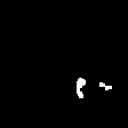

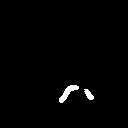

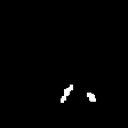

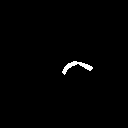

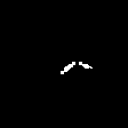

Median IOU:  0.6166810717372515


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

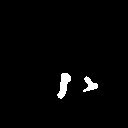

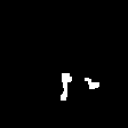

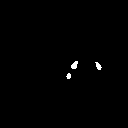

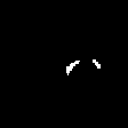

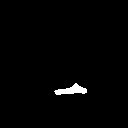

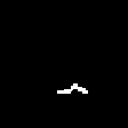

Median IOU:  0.6167141838916608


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

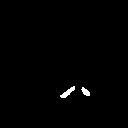

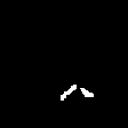

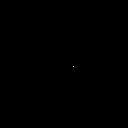

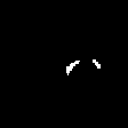

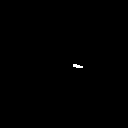

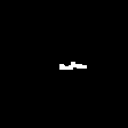

Median IOU:  0.47928253615127925


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

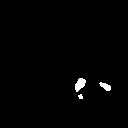

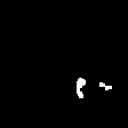

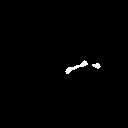

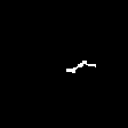

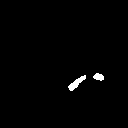

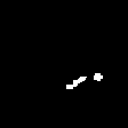

Median IOU:  0.6184129901960784


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

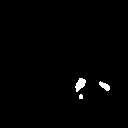

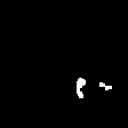

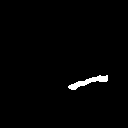

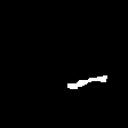

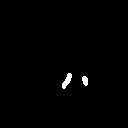

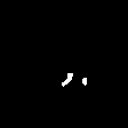

Median IOU:  0.6326901669758813


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

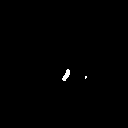

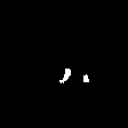

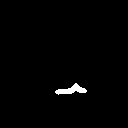

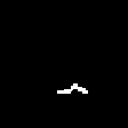

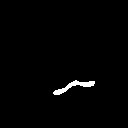

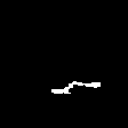

Median IOU:  0.5900894187779433


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

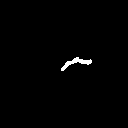

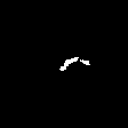

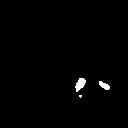

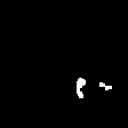

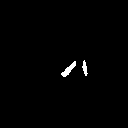

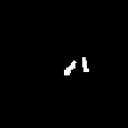

Median IOU:  0.5967135813107377


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

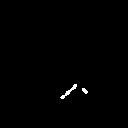

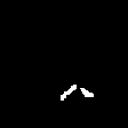

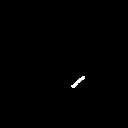

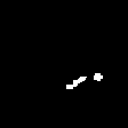

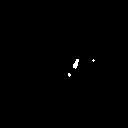

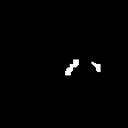

Median IOU:  0.2126938482078669


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

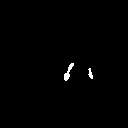

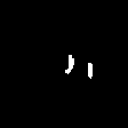

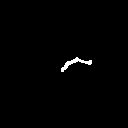

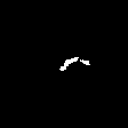

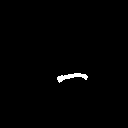

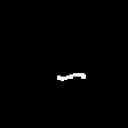

Median IOU:  0.5253459961849101


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

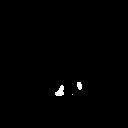

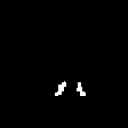

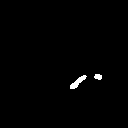

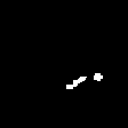

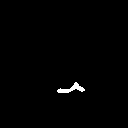

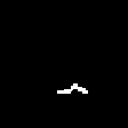

Median IOU:  0.5177145447571225


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

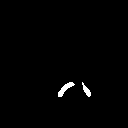

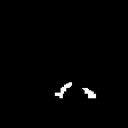

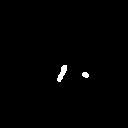

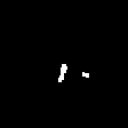

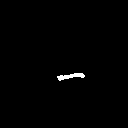

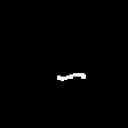

Median IOU:  0.5720025510204082


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

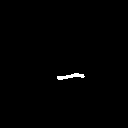

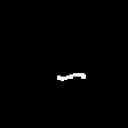

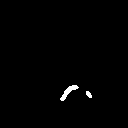

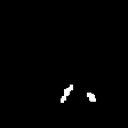

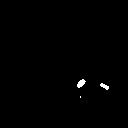

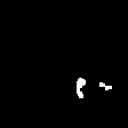

Median IOU:  0.5259243814289686


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

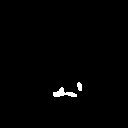

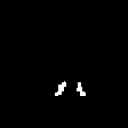

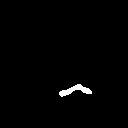

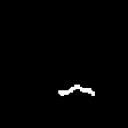

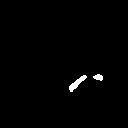

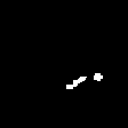

Median IOU:  0.5935838613356639


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

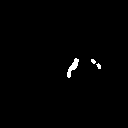

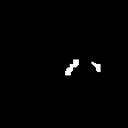

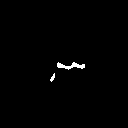

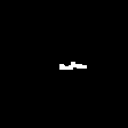

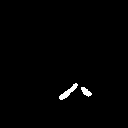

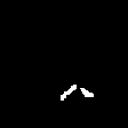

Median IOU:  0.5934418145956608


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

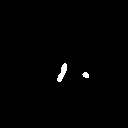

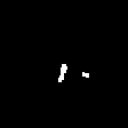

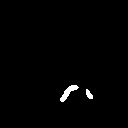

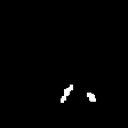

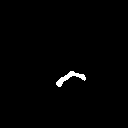

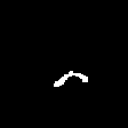

Median IOU:  0.5823487357013847


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

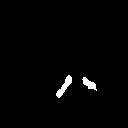

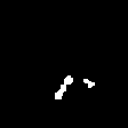

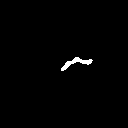

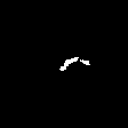

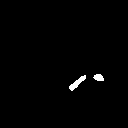

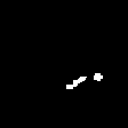

Median IOU:  0.5981290502404014


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

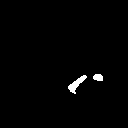

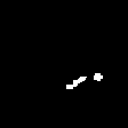

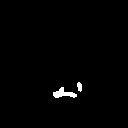

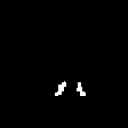

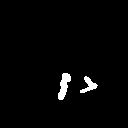

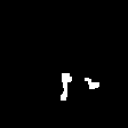

Median IOU:  0.6229984669108253


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

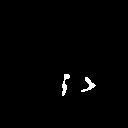

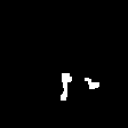

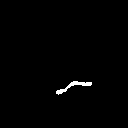

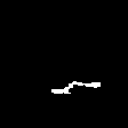

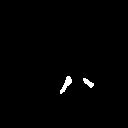

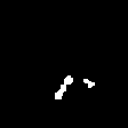

Median IOU:  0.4240705669232986


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

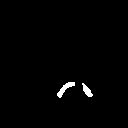

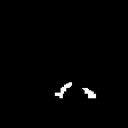

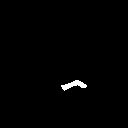

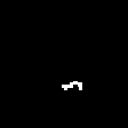

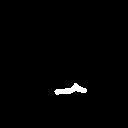

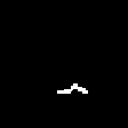

Median IOU:  0.6044554455445544


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

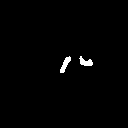

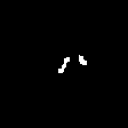

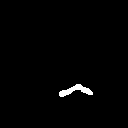

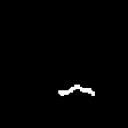

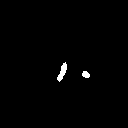

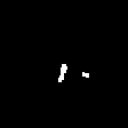

Median IOU:  0.6082278202760925


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

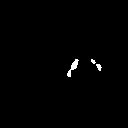

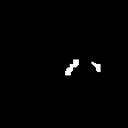

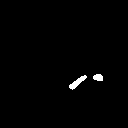

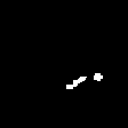

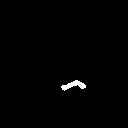

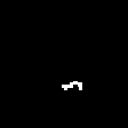

Median IOU:  0.6112483431738764


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

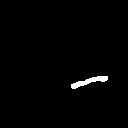

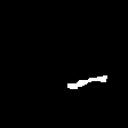

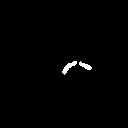

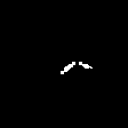

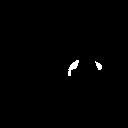

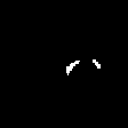

Median IOU:  0.6169354838709677


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

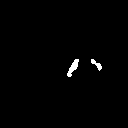

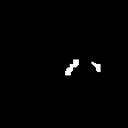

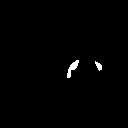

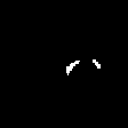

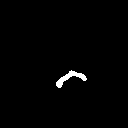

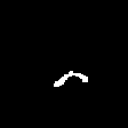

Median IOU:  0.632780437756498


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

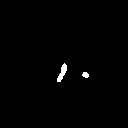

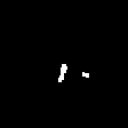

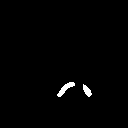

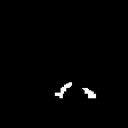

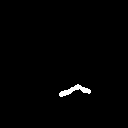

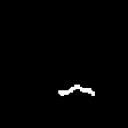

Median IOU:  0.6061822351959967


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

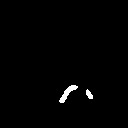

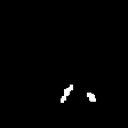

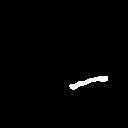

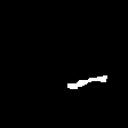

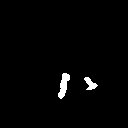

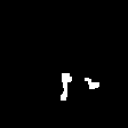

Median IOU:  0.6010223298358892


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

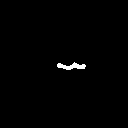

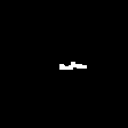

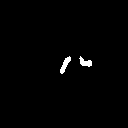

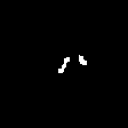

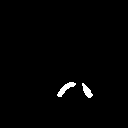

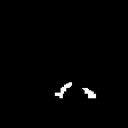

Median IOU:  0.6084566355565673


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

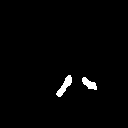

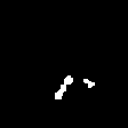

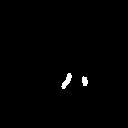

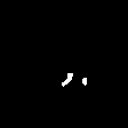

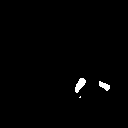

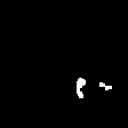

Median IOU:  0.6174775009782183


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

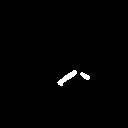

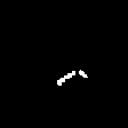

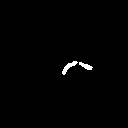

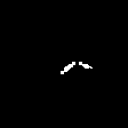

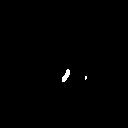

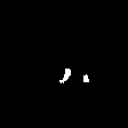

Median IOU:  0.6002519264967398


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

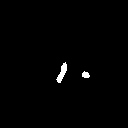

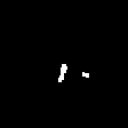

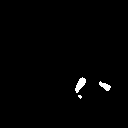

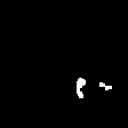

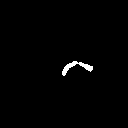

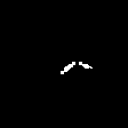

Median IOU:  0.6078216989066443


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

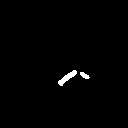

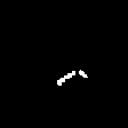

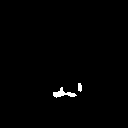

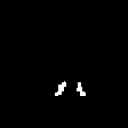

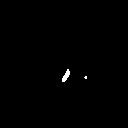

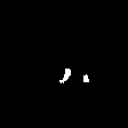

Median IOU:  0.5913865079717546


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

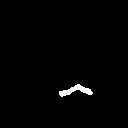

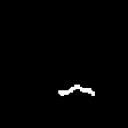

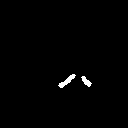

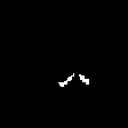

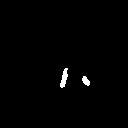

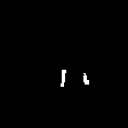

Median IOU:  0.6103364320495794


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

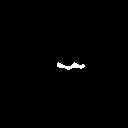

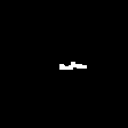

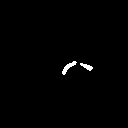

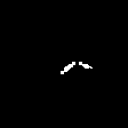

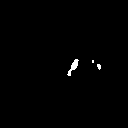

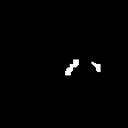

Median IOU:  0.5952921157118548


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

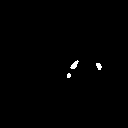

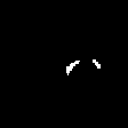

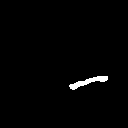

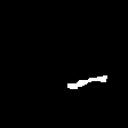

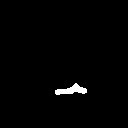

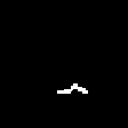

Median IOU:  0.6113613826321009


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

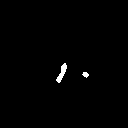

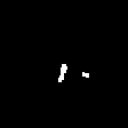

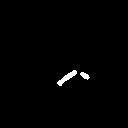

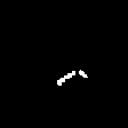

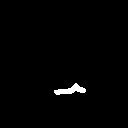

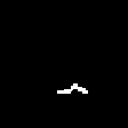

Median IOU:  0.592780487804878


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

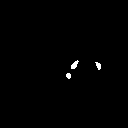

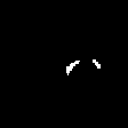

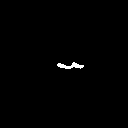

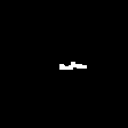

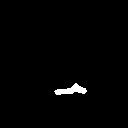

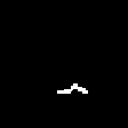

Median IOU:  0.6337410786205346


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

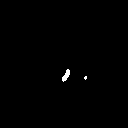

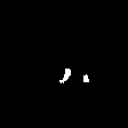

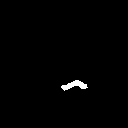

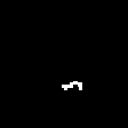

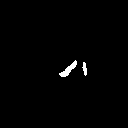

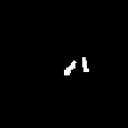

Median IOU:  0.6176926604502871


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

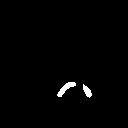

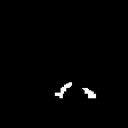

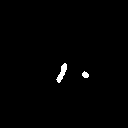

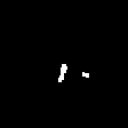

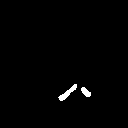

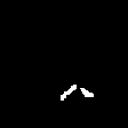

Median IOU:  0.6074423480083857


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

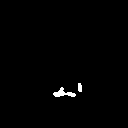

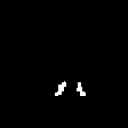

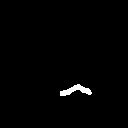

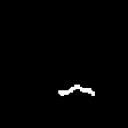

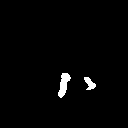

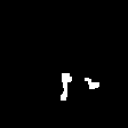

Median IOU:  0.5857170846394983


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

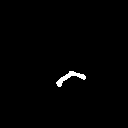

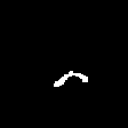

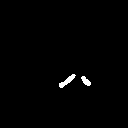

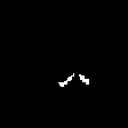

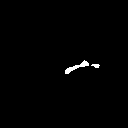

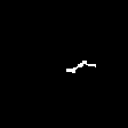

Median IOU:  0.6051178203240059


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

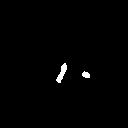

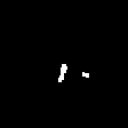

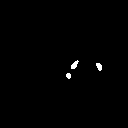

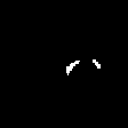

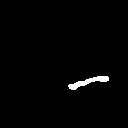

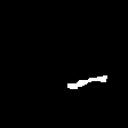

Median IOU:  0.6108916896946822


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

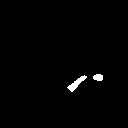

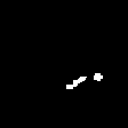

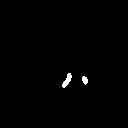

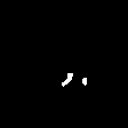

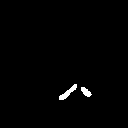

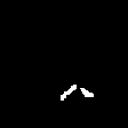

Median IOU:  0.6061814556331007


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

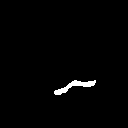

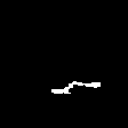

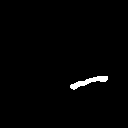

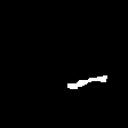

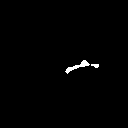

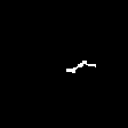

Median IOU:  0.6068370019109632


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

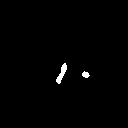

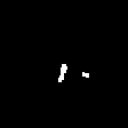

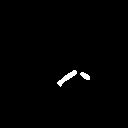

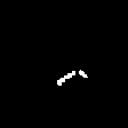

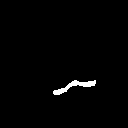

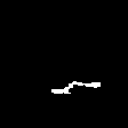

Median IOU:  0.6023870417732311


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

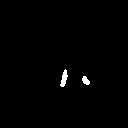

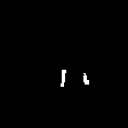

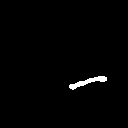

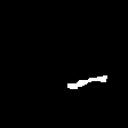

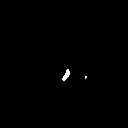

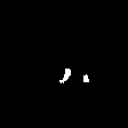

Median IOU:  0.5539874551971327


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

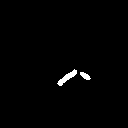

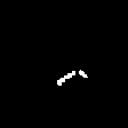

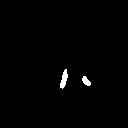

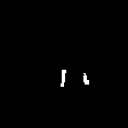

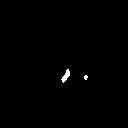

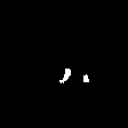

Median IOU:  0.610749642426452


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

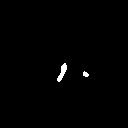

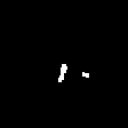

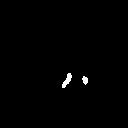

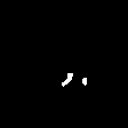

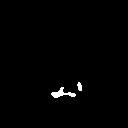

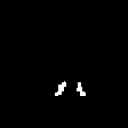

Median IOU:  0.5905716060888475


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

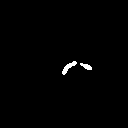

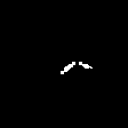

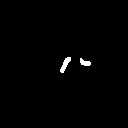

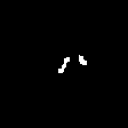

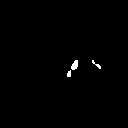

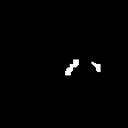

Median IOU:  0.5921914357682619


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

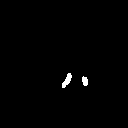

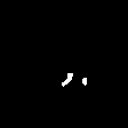

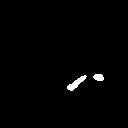

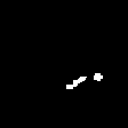

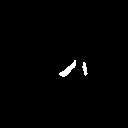

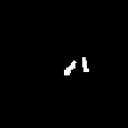

Median IOU:  0.6321743091406012


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

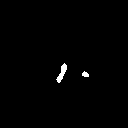

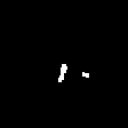

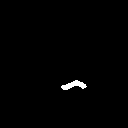

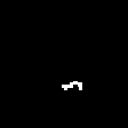

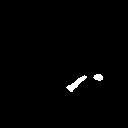

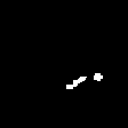

Median IOU:  0.5984189723320158


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

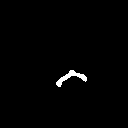

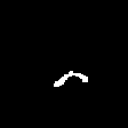

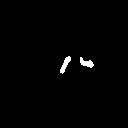

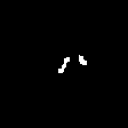

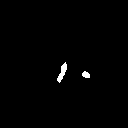

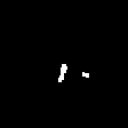

Median IOU:  0.614414996767938


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

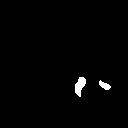

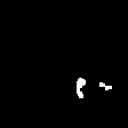

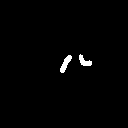

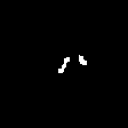

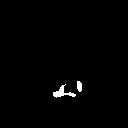

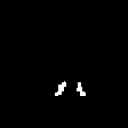

Median IOU:  0.618566075168081


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

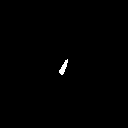

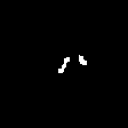

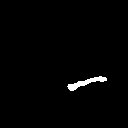

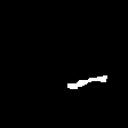

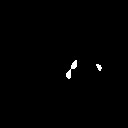

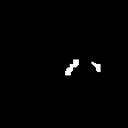

Median IOU:  0.5819083447332422


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

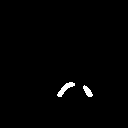

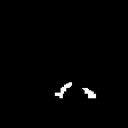

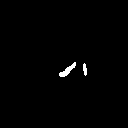

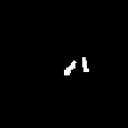

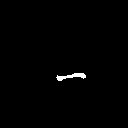

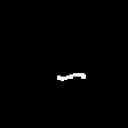

Median IOU:  0.5945246179966044


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

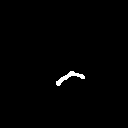

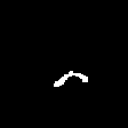

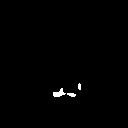

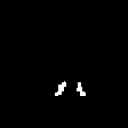

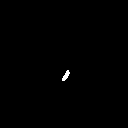

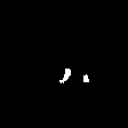

Median IOU:  0.5188177482295129


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

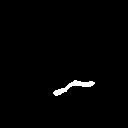

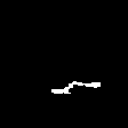

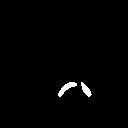

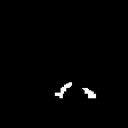

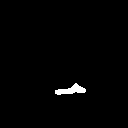

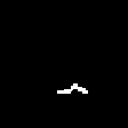

Median IOU:  0.6217826086956522


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

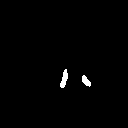

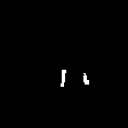

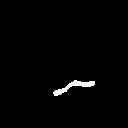

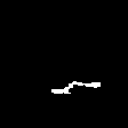

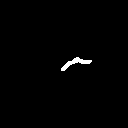

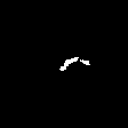

Median IOU:  0.6163493840985442


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

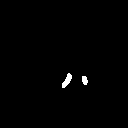

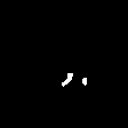

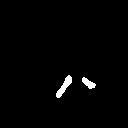

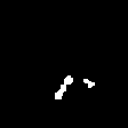

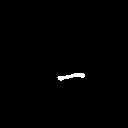

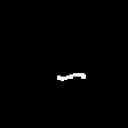

Median IOU:  0.5912004157283908


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

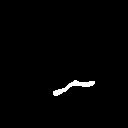

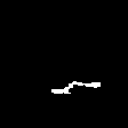

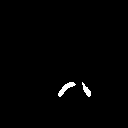

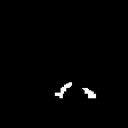

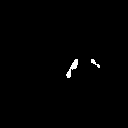

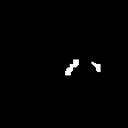

Median IOU:  0.5875435369623918


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

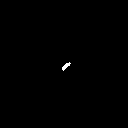

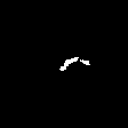

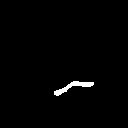

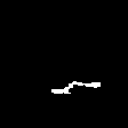

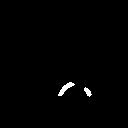

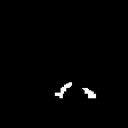

Median IOU:  0.5486474310003722


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

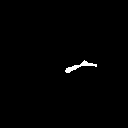

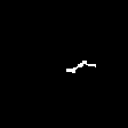

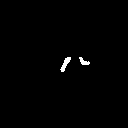

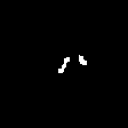

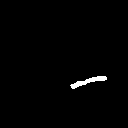

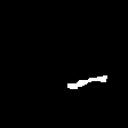

Median IOU:  0.5749839921814444


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

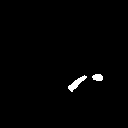

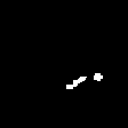

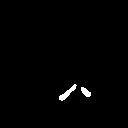

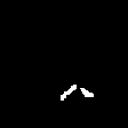

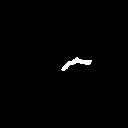

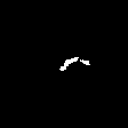

Median IOU:  0.6058929222436331


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

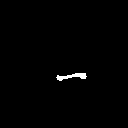

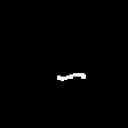

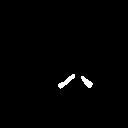

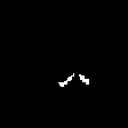

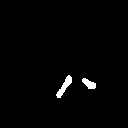

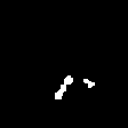

Median IOU:  0.6001496833621186


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

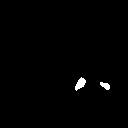

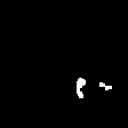

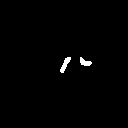

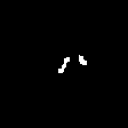

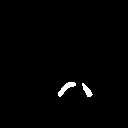

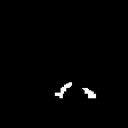

Median IOU:  0.6007842769653793


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

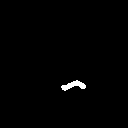

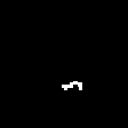

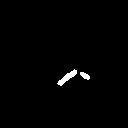

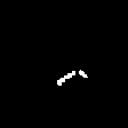

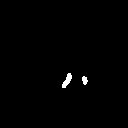

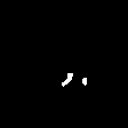

Median IOU:  0.6084293193717277


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

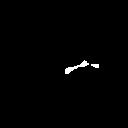

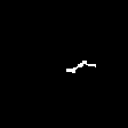

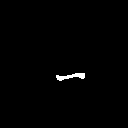

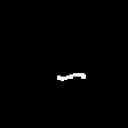

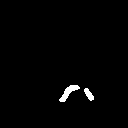

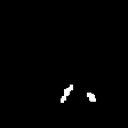

Median IOU:  0.6137520525451561


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

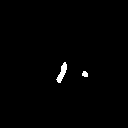

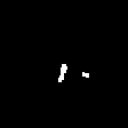

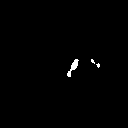

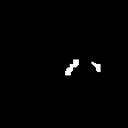

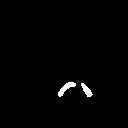

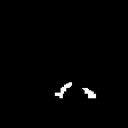

Median IOU:  0.5952871929367956


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

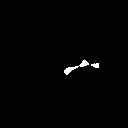

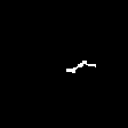

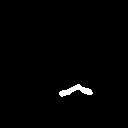

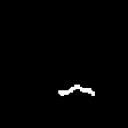

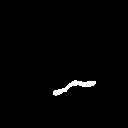

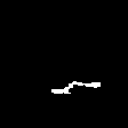

Median IOU:  0.6246635674088574


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

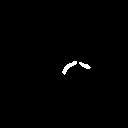

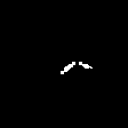

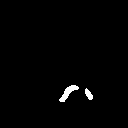

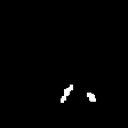

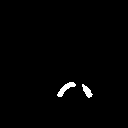

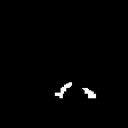

Median IOU:  0.5985514356186037


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

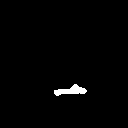

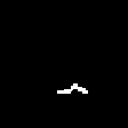

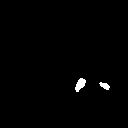

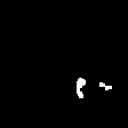

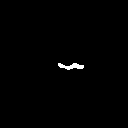

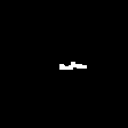

Median IOU:  0.606288414182466


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

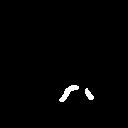

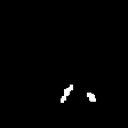

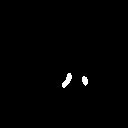

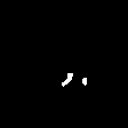

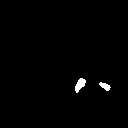

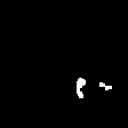

Median IOU:  0.6071719117961892


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

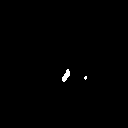

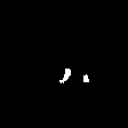

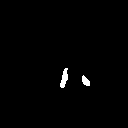

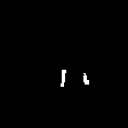

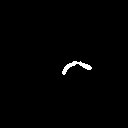

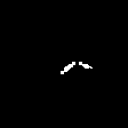

Median IOU:  0.6253654970760234


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

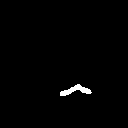

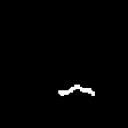

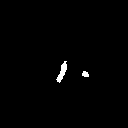

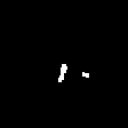

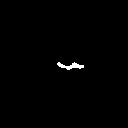

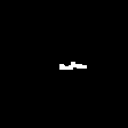

Median IOU:  0.5992261306532662


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

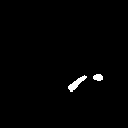

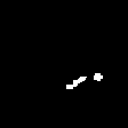

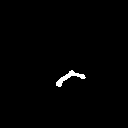

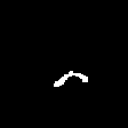

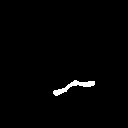

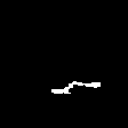

Median IOU:  0.6017918376246258


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

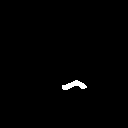

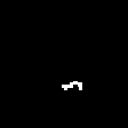

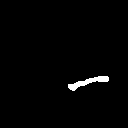

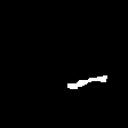

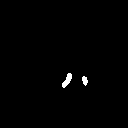

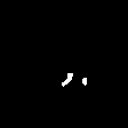

Median IOU:  0.6234118291347207


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

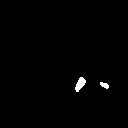

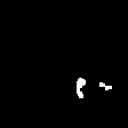

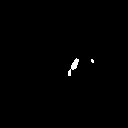

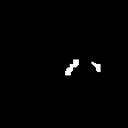

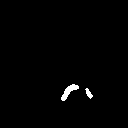

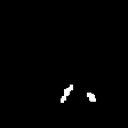

Median IOU:  0.5618461915658712


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

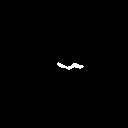

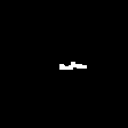

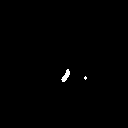

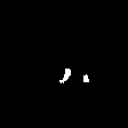

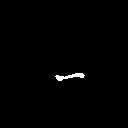

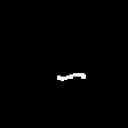

Median IOU:  0.579302926801653


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

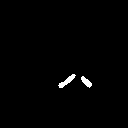

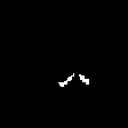

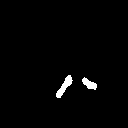

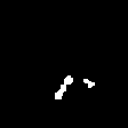

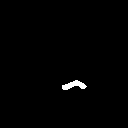

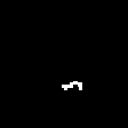

Median IOU:  0.6180555555555556


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

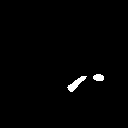

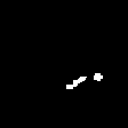

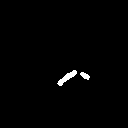

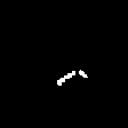

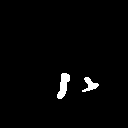

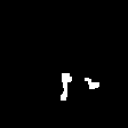

Median IOU:  0.6096402918790786


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

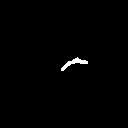

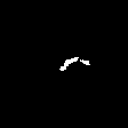

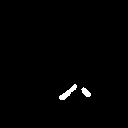

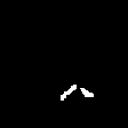

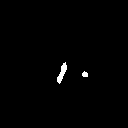

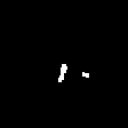

Median IOU:  0.6022220315717227


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

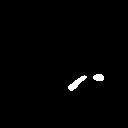

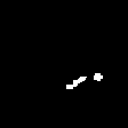

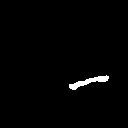

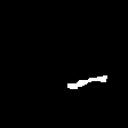

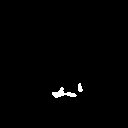

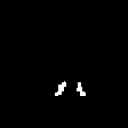

Median IOU:  0.6045156153069822


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

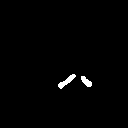

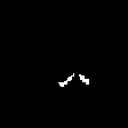

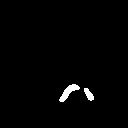

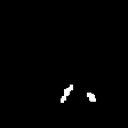

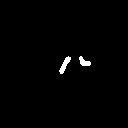

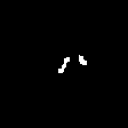

Median IOU:  0.6343765092243794


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

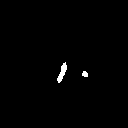

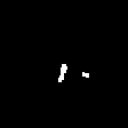

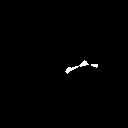

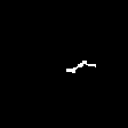

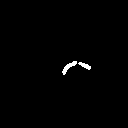

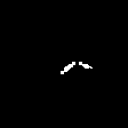

Median IOU:  0.5967581047381546


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

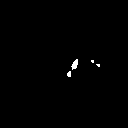

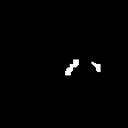

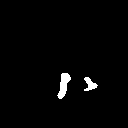

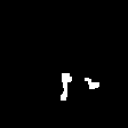

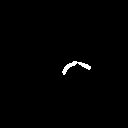

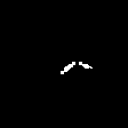

Median IOU:  0.6128878565898398


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

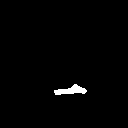

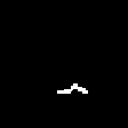

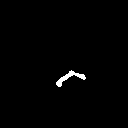

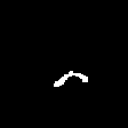

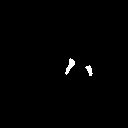

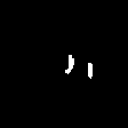

Median IOU:  0.6203759333962751


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

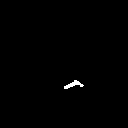

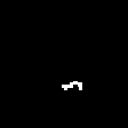

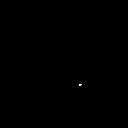

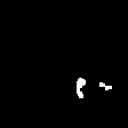

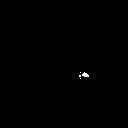

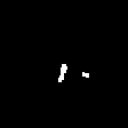

Median IOU:  0.22316904652233993


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

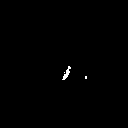

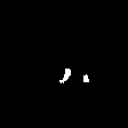

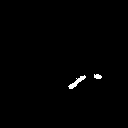

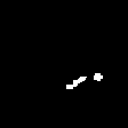

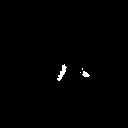

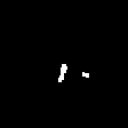

Median IOU:  0.44564933368173504


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

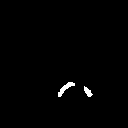

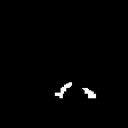

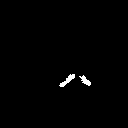

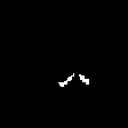

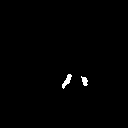

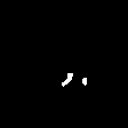

Median IOU:  0.5250482625482625


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

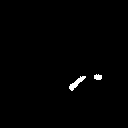

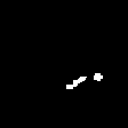

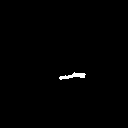

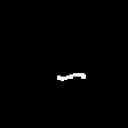

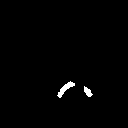

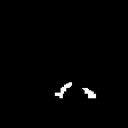

Median IOU:  0.5834939480379309


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

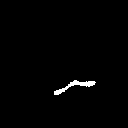

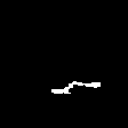

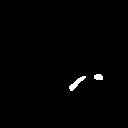

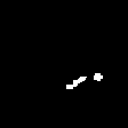

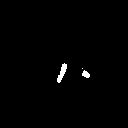

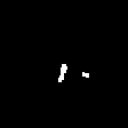

Median IOU:  0.5743809346490412


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

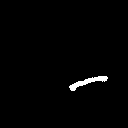

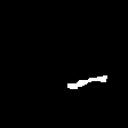

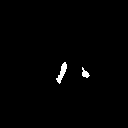

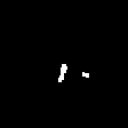

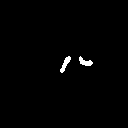

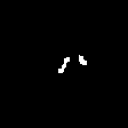

Median IOU:  0.5918645853284812


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

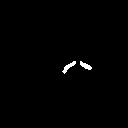

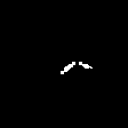

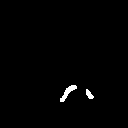

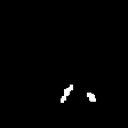

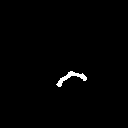

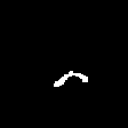

Median IOU:  0.5591803552072041


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

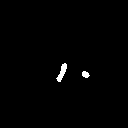

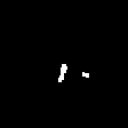

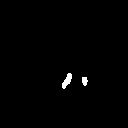

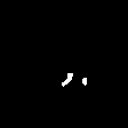

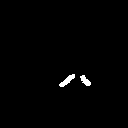

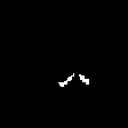

Median IOU:  0.6012295081967213


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

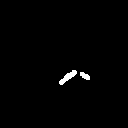

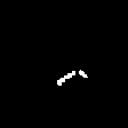

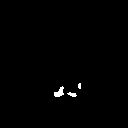

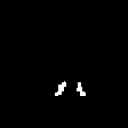

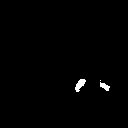

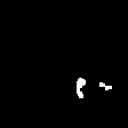

Median IOU:  0.5878368366461336


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

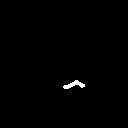

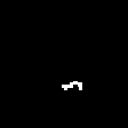

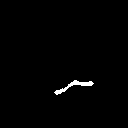

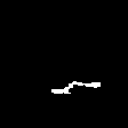

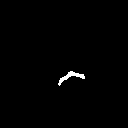

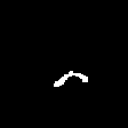

Median IOU:  0.48455359901143036


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

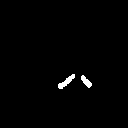

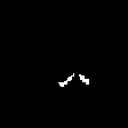

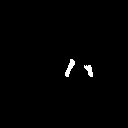

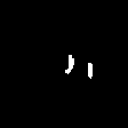

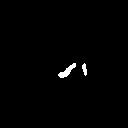

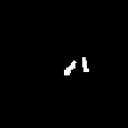

Median IOU:  0.6002801815860406


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

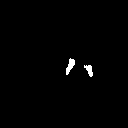

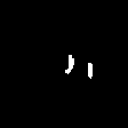

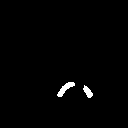

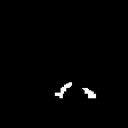

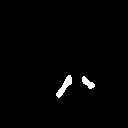

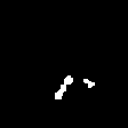

Median IOU:  0.6082428765264586


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

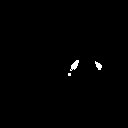

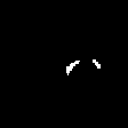

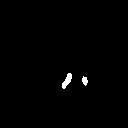

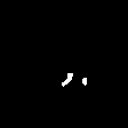

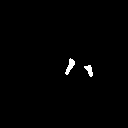

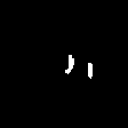

Median IOU:  0.6110323886639677


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

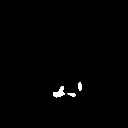

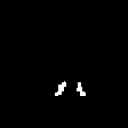

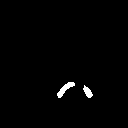

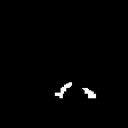

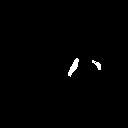

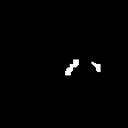

Median IOU:  0.6265460030165912


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

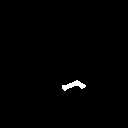

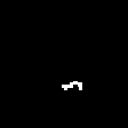

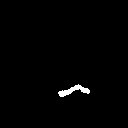

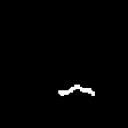

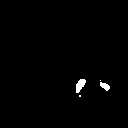

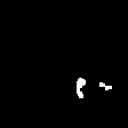

Median IOU:  0.6022217251919779


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

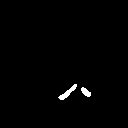

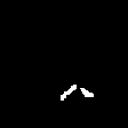

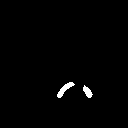

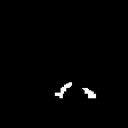

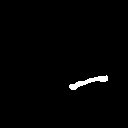

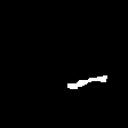

Median IOU:  0.6214005235602094


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

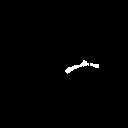

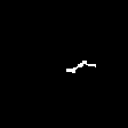

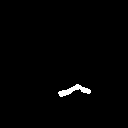

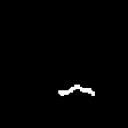

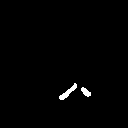

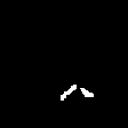

Median IOU:  0.6173330745341614


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

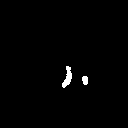

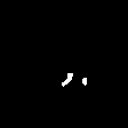

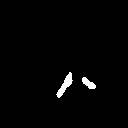

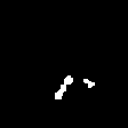

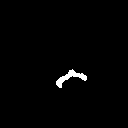

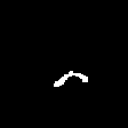

Median IOU:  0.61708516574455


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

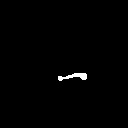

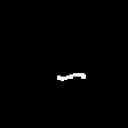

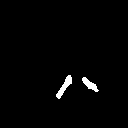

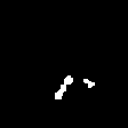

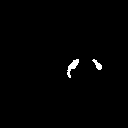

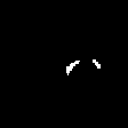

Median IOU:  0.6073403720462544


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

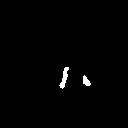

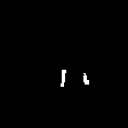

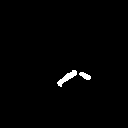

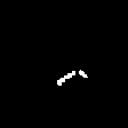

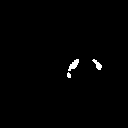

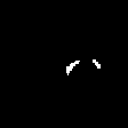

Median IOU:  0.60687432867884


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

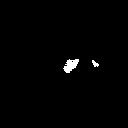

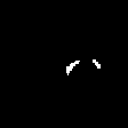

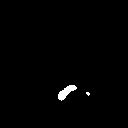

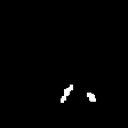

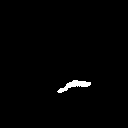

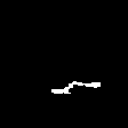

Median IOU:  0.45859680573663625


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

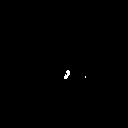

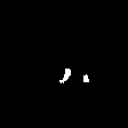

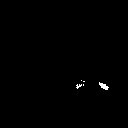

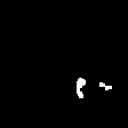

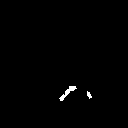

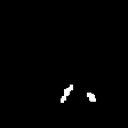

Median IOU:  0.39075549274058846


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

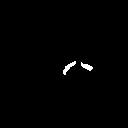

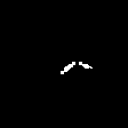

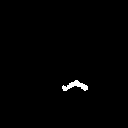

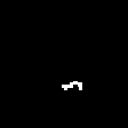

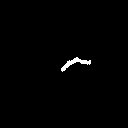

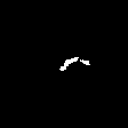

Median IOU:  0.5666471324685012


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

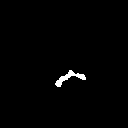

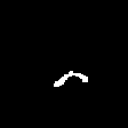

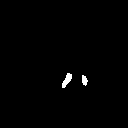

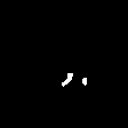

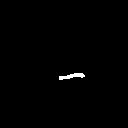

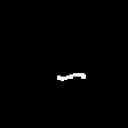

Median IOU:  0.6086194008395147


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

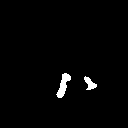

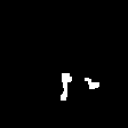

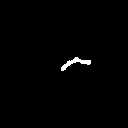

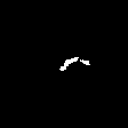

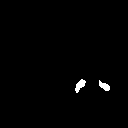

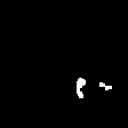

Median IOU:  0.599776567518503


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

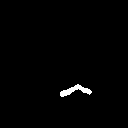

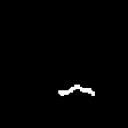

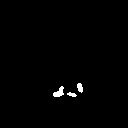

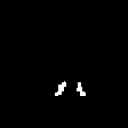

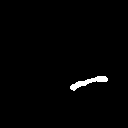

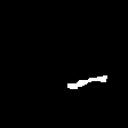

Median IOU:  0.6153288201160542


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

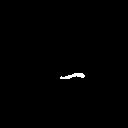

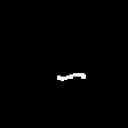

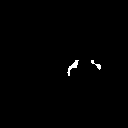

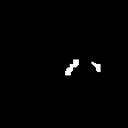

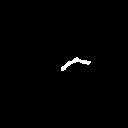

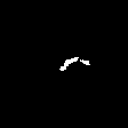

Median IOU:  0.5802285146547441


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

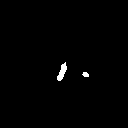

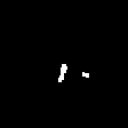

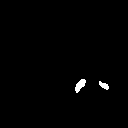

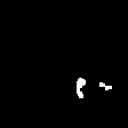

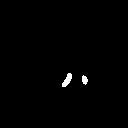

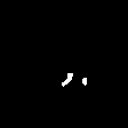

Median IOU:  0.5775399457340971


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

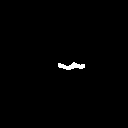

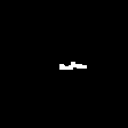

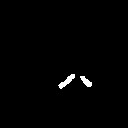

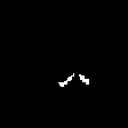

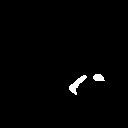

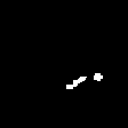

Median IOU:  0.6223856209150327


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

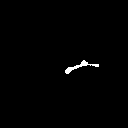

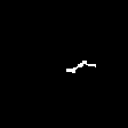

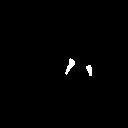

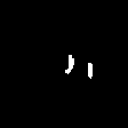

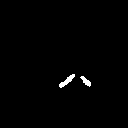

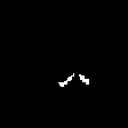

Median IOU:  0.5813655224443606


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

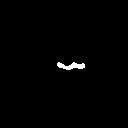

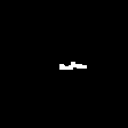

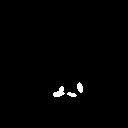

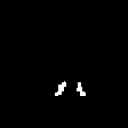

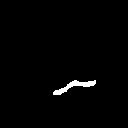

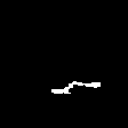

Median IOU:  0.6164510600333388


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

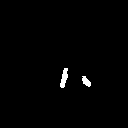

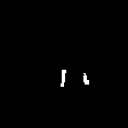

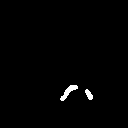

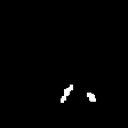

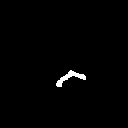

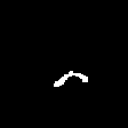

Median IOU:  0.6352768356184015


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

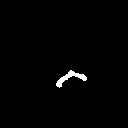

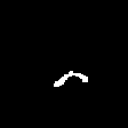

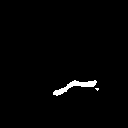

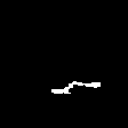

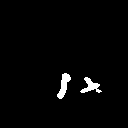

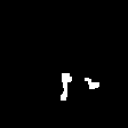

Median IOU:  0.6046357952523763


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

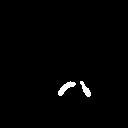

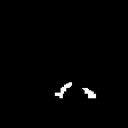

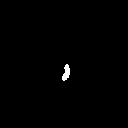

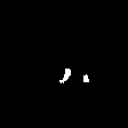

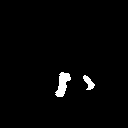

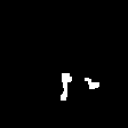

Median IOU:  0.6170686141304348


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

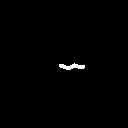

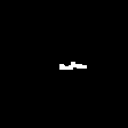

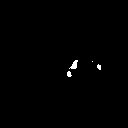

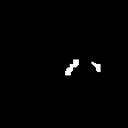

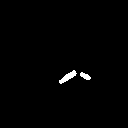

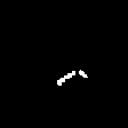

Median IOU:  0.5678145457806475


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

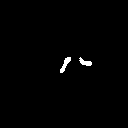

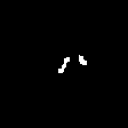

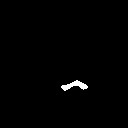

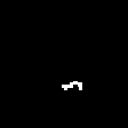

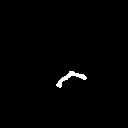

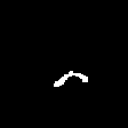

Median IOU:  0.578258413900794


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

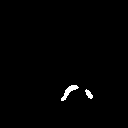

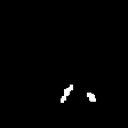

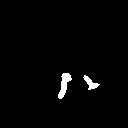

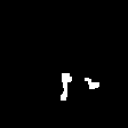

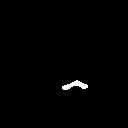

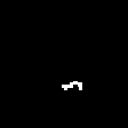

Median IOU:  0.5700737710649605


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

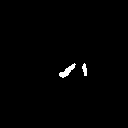

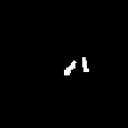

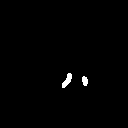

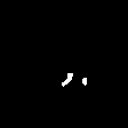

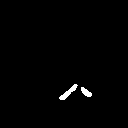

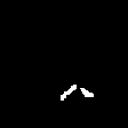

Median IOU:  0.6127606474786584


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

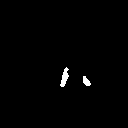

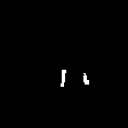

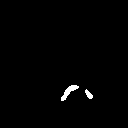

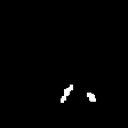

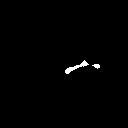

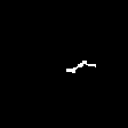

Median IOU:  0.5919661733615222


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

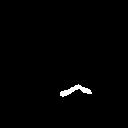

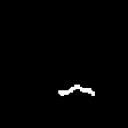

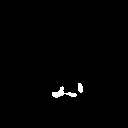

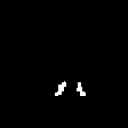

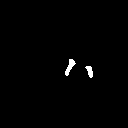

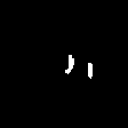

Median IOU:  0.6032062780269059


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

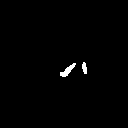

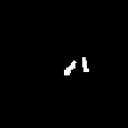

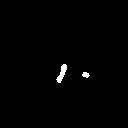

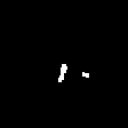

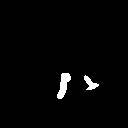

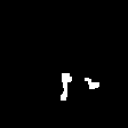

Median IOU:  0.6087932159165036


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

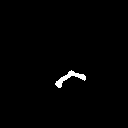

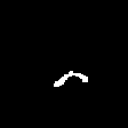

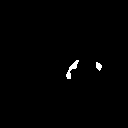

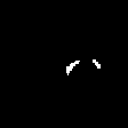

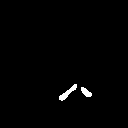

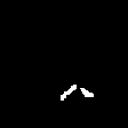

Median IOU:  0.6118816865953429


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

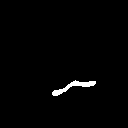

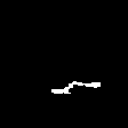

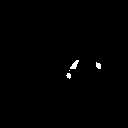

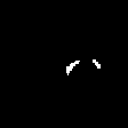

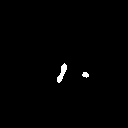

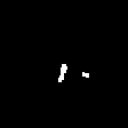

Median IOU:  0.5969320618023213


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

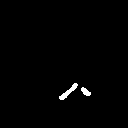

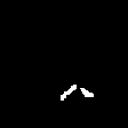

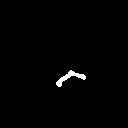

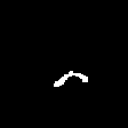

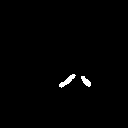

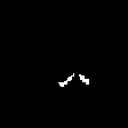

Median IOU:  0.6063556707392324


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

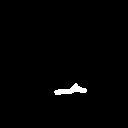

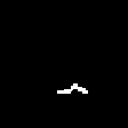

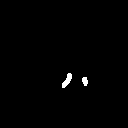

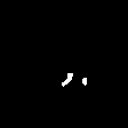

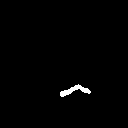

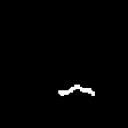

Median IOU:  0.6027777777777777


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

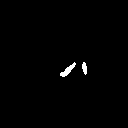

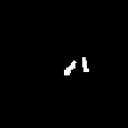

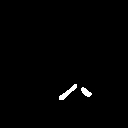

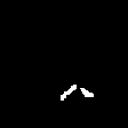

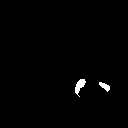

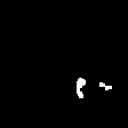

Median IOU:  0.5977777777777777


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

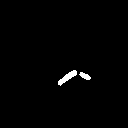

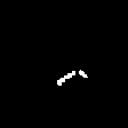

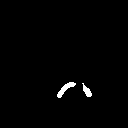

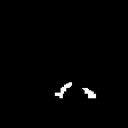

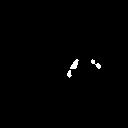

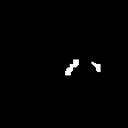

Median IOU:  0.6326614561908679


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

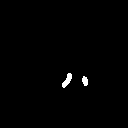

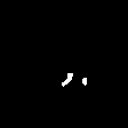

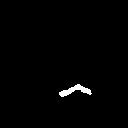

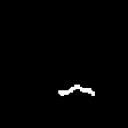

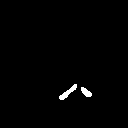

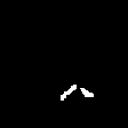

Median IOU:  0.6080350132317446


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

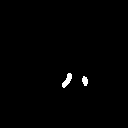

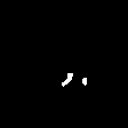

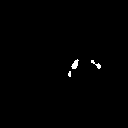

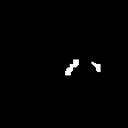

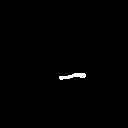

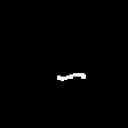

Median IOU:  0.5956633237166278


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

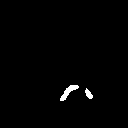

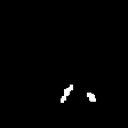

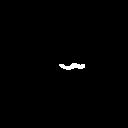

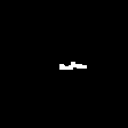

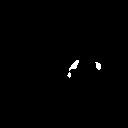

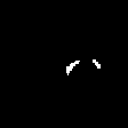

Median IOU:  0.6239192167500212


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

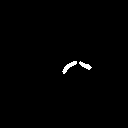

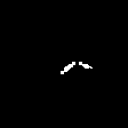

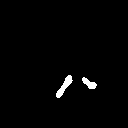

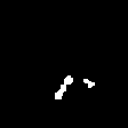

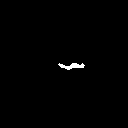

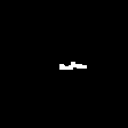

Median IOU:  0.6106624223929286


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

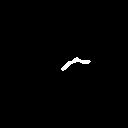

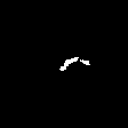

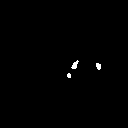

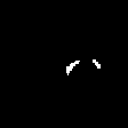

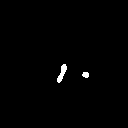

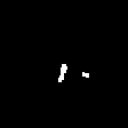

Median IOU:  0.6052834028191384


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

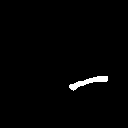

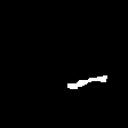

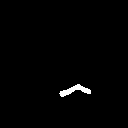

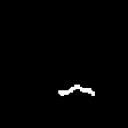

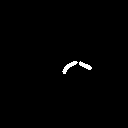

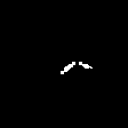

Median IOU:  0.6214037698412698


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

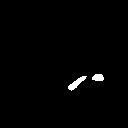

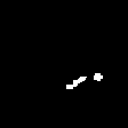

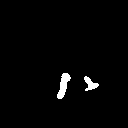

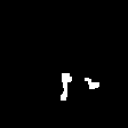

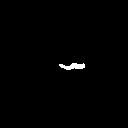

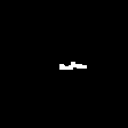

Median IOU:  0.6095098858256753


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

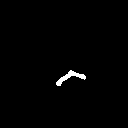

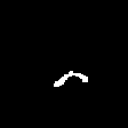

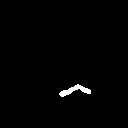

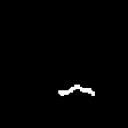

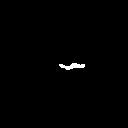

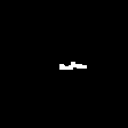

Median IOU:  0.6042650208414895


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

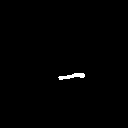

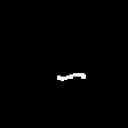

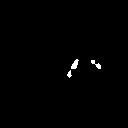

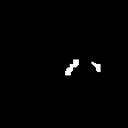

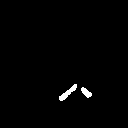

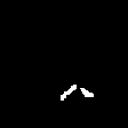

Median IOU:  0.6138238050609185


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

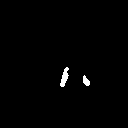

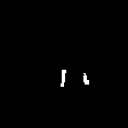

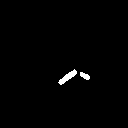

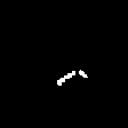

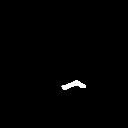

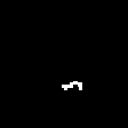

Median IOU:  0.6020999183506839


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

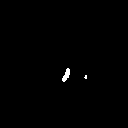

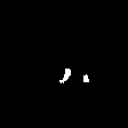

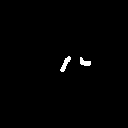

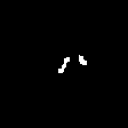

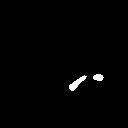

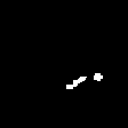

Median IOU:  0.5967322420163904


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

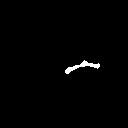

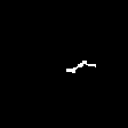

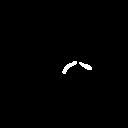

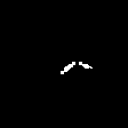

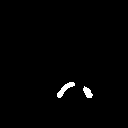

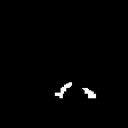

Median IOU:  0.613484474051789


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

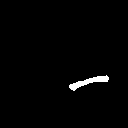

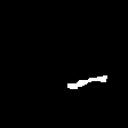

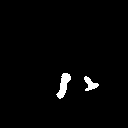

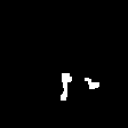

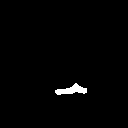

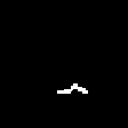

Median IOU:  0.6170068027210884


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

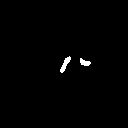

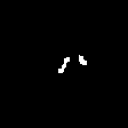

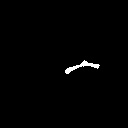

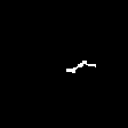

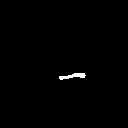

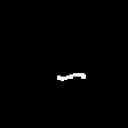

Median IOU:  0.6028909171324032


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

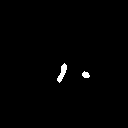

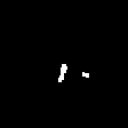

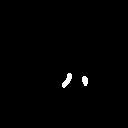

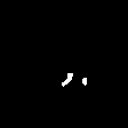

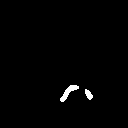

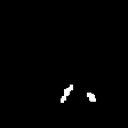

Median IOU:  0.6033287993529888


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

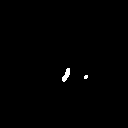

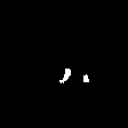

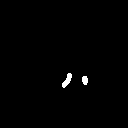

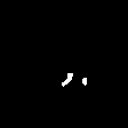

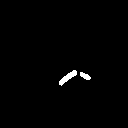

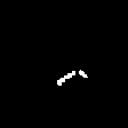

Median IOU:  0.6067330874023296


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

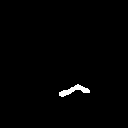

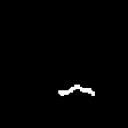

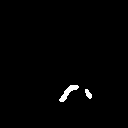

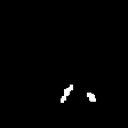

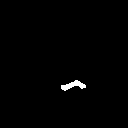

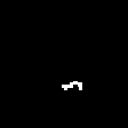

Median IOU:  0.6039426523297491


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

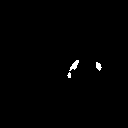

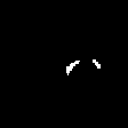

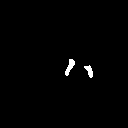

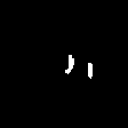

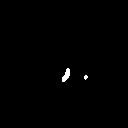

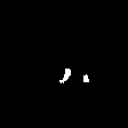

Median IOU:  0.629555863244222


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

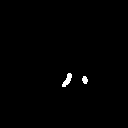

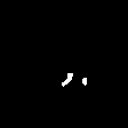

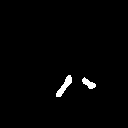

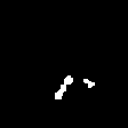

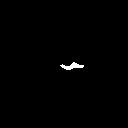

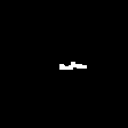

Median IOU:  0.5852771486667439


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

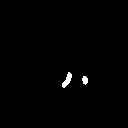

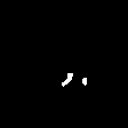

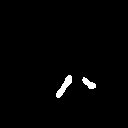

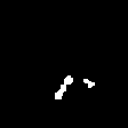

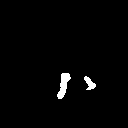

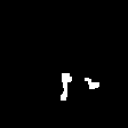

Median IOU:  0.6207942858677264


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

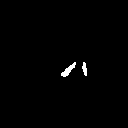

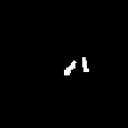

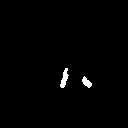

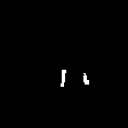

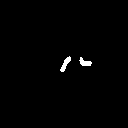

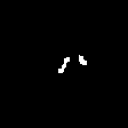

Median IOU:  0.5869366903849662


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

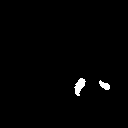

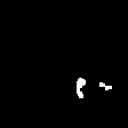

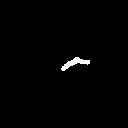

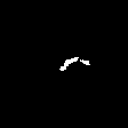

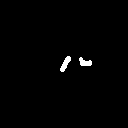

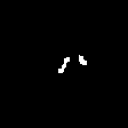

Median IOU:  0.6298570227081581


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

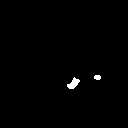

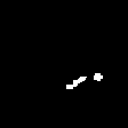

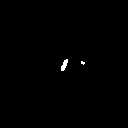

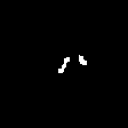

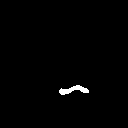

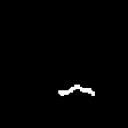

Median IOU:  0.412007992007992


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

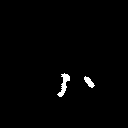

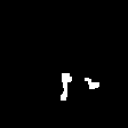

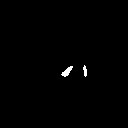

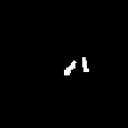

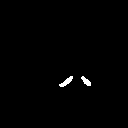

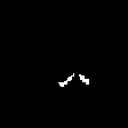

Median IOU:  0.5173616680032077


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

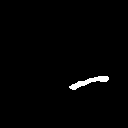

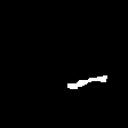

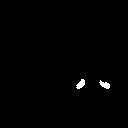

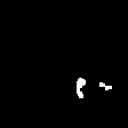

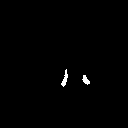

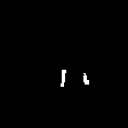

Median IOU:  0.546980091471617


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

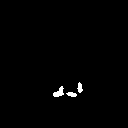

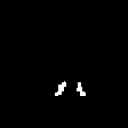

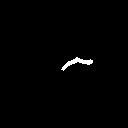

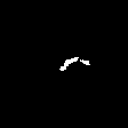

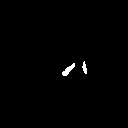

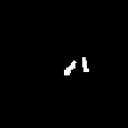

Median IOU:  0.5657228699258678


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

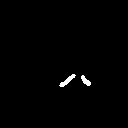

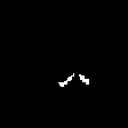

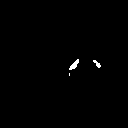

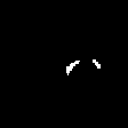

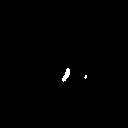

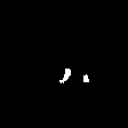

Median IOU:  0.5798199385155907


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

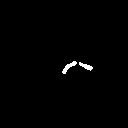

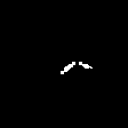

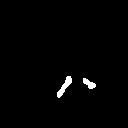

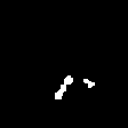

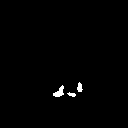

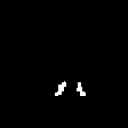

Median IOU:  0.576014381099127


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

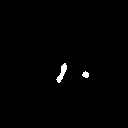

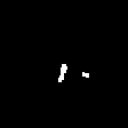

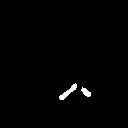

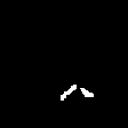

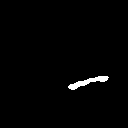

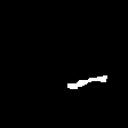

Median IOU:  0.6142156862745098


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

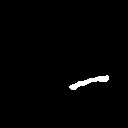

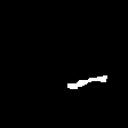

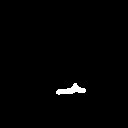

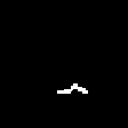

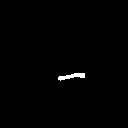

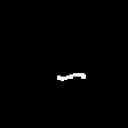

Median IOU:  0.5949497123625406


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

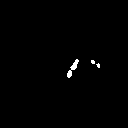

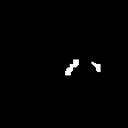

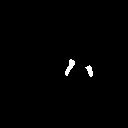

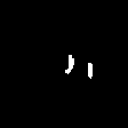

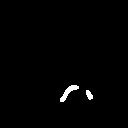

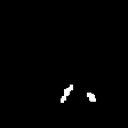

Median IOU:  0.5935927859515899


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

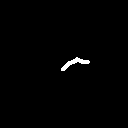

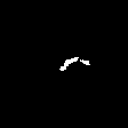

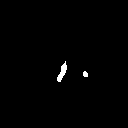

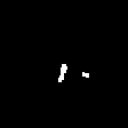

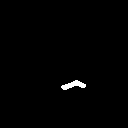

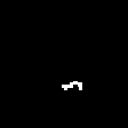

Median IOU:  0.6069990305019017


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

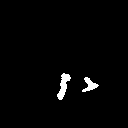

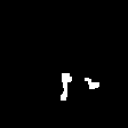

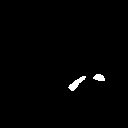

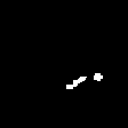

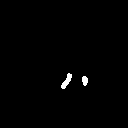

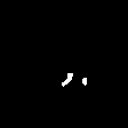

Median IOU:  0.5985074626865672


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

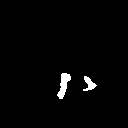

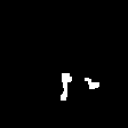

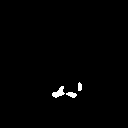

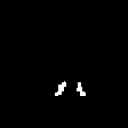

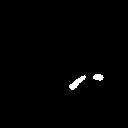

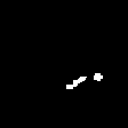

Median IOU:  0.5965116279069768


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

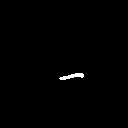

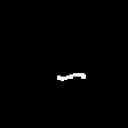

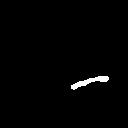

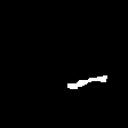

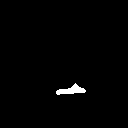

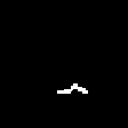

Median IOU:  0.5551718556089138


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

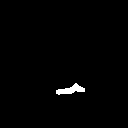

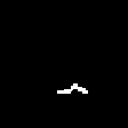

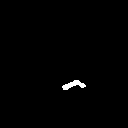

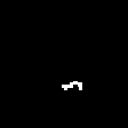

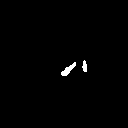

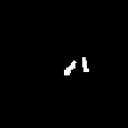

Median IOU:  0.5914422281459693


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

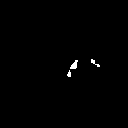

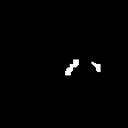

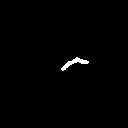

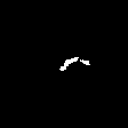

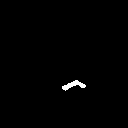

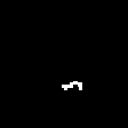

Median IOU:  0.5669154228855722


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

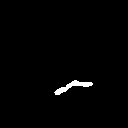

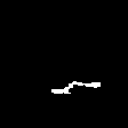

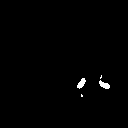

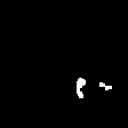

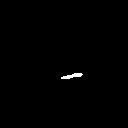

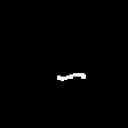

Median IOU:  0.5353092783505156


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

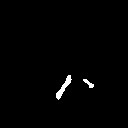

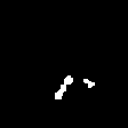

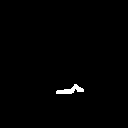

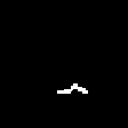

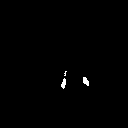

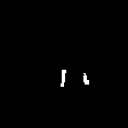

Median IOU:  0.39200883575883577


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

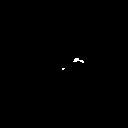

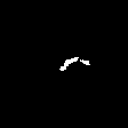

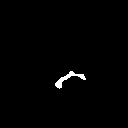

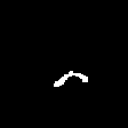

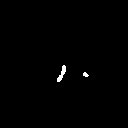

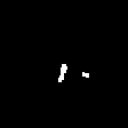

Median IOU:  0.4985904255319149


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

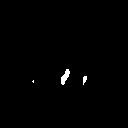

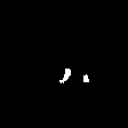

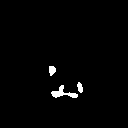

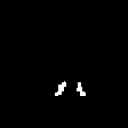

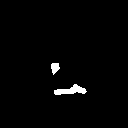

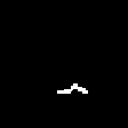

Median IOU:  0.5326826115061409


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

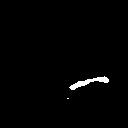

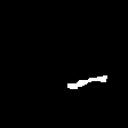

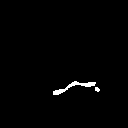

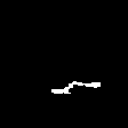

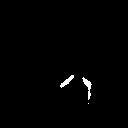

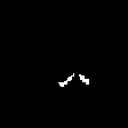

Median IOU:  0.45621348588120736


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

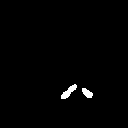

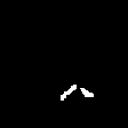

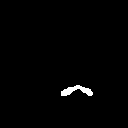

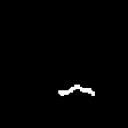

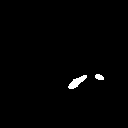

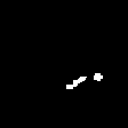

Median IOU:  0.5580936920222634


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

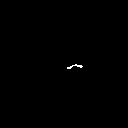

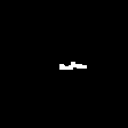

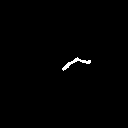

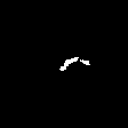

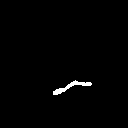

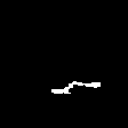

Median IOU:  0.5051258154706431


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

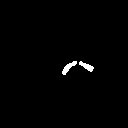

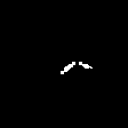

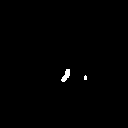

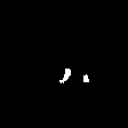

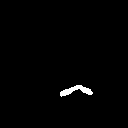

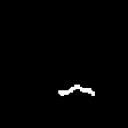

Median IOU:  0.5914403232528221


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

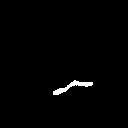

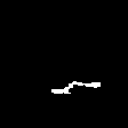

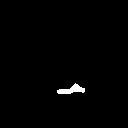

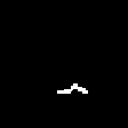

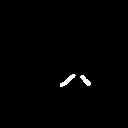

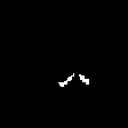

Median IOU:  0.5622089155023287


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

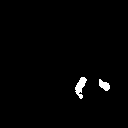

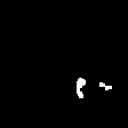

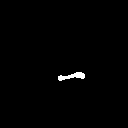

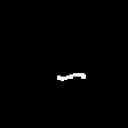

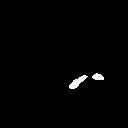

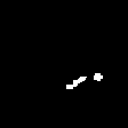

Median IOU:  0.6409493527140586


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

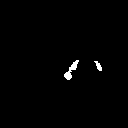

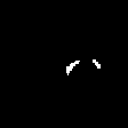

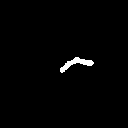

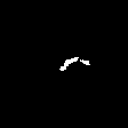

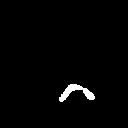

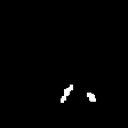

Median IOU:  0.6104132444358553


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

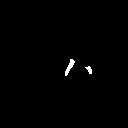

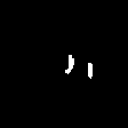

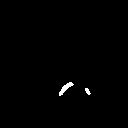

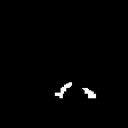

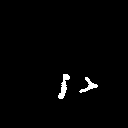

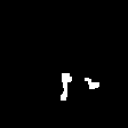

Median IOU:  0.49302380952380953


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

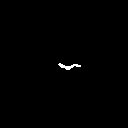

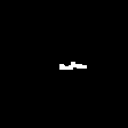

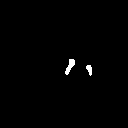

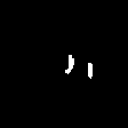

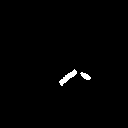

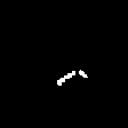

Median IOU:  0.5614194804492437


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

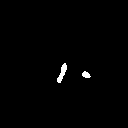

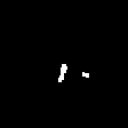

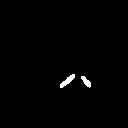

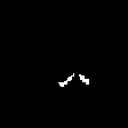

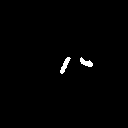

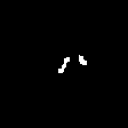

Median IOU:  0.5886929240683427


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

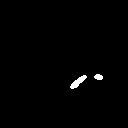

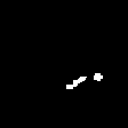

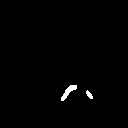

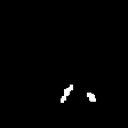

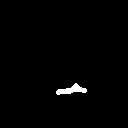

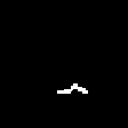

Median IOU:  0.5832449316360206


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

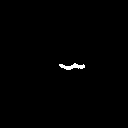

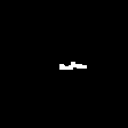

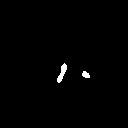

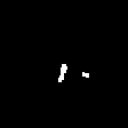

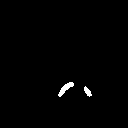

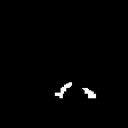

Median IOU:  0.5924025086261149


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

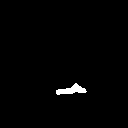

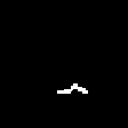

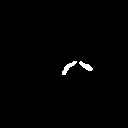

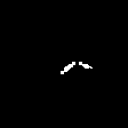

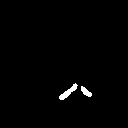

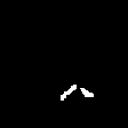

Median IOU:  0.5973915989159891


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

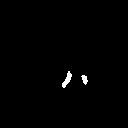

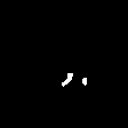

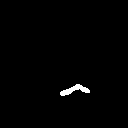

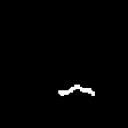

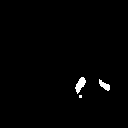

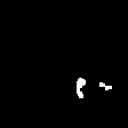

Median IOU:  0.6053682342502218


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

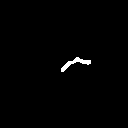

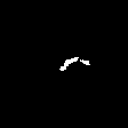

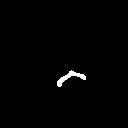

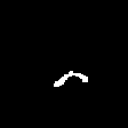

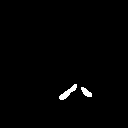

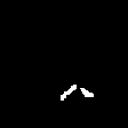

Median IOU:  0.5897914444839436


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

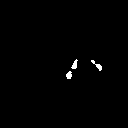

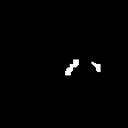

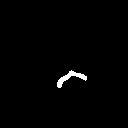

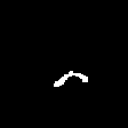

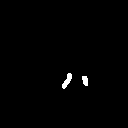

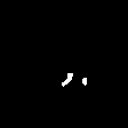

Median IOU:  0.5974193300257682


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

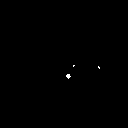

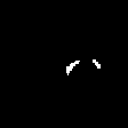

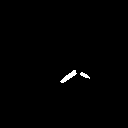

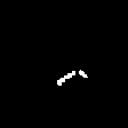

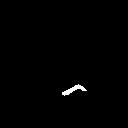

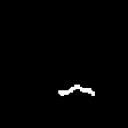

Median IOU:  0.45489808335868576


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

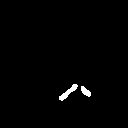

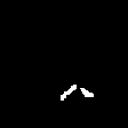

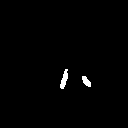

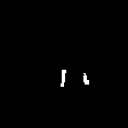

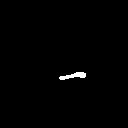

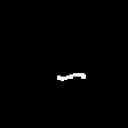

Median IOU:  0.5792257580998501


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

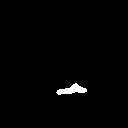

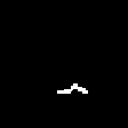

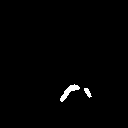

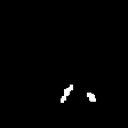

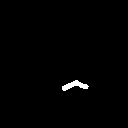

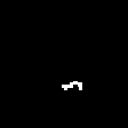

Median IOU:  0.5908680622239293


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

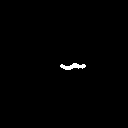

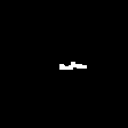

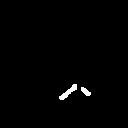

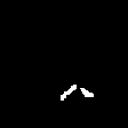

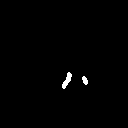

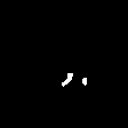

Median IOU:  0.598342541436464


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

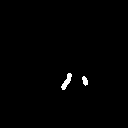

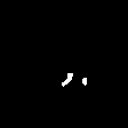

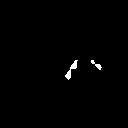

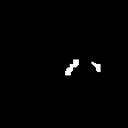

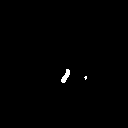

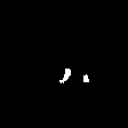

Median IOU:  0.5923763736263736


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

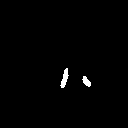

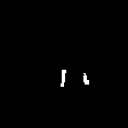

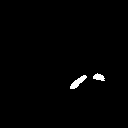

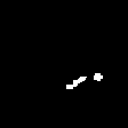

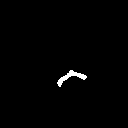

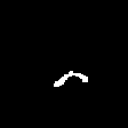

Median IOU:  0.5999121651295565


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

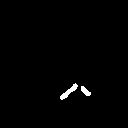

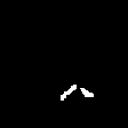

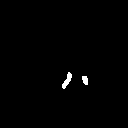

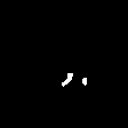

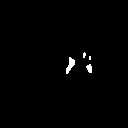

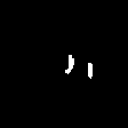

Median IOU:  0.6004265124031768


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

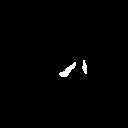

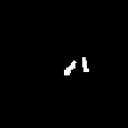

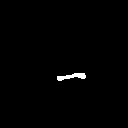

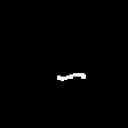

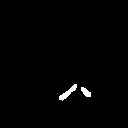

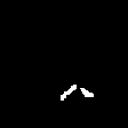

Median IOU:  0.6156293890449438


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

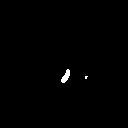

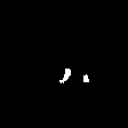

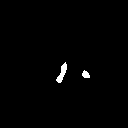

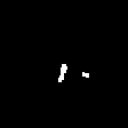

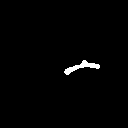

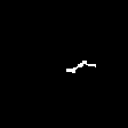

Median IOU:  0.6176565957122149


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

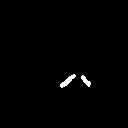

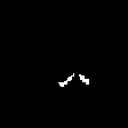

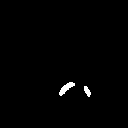

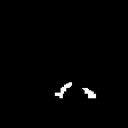

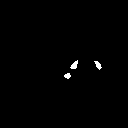

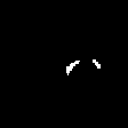

Median IOU:  0.592096920289855


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

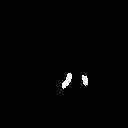

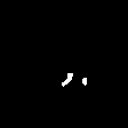

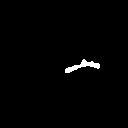

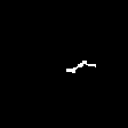

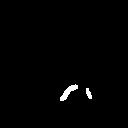

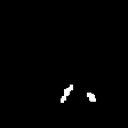

Median IOU:  0.615856962253928


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

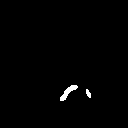

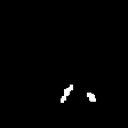

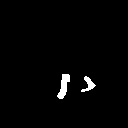

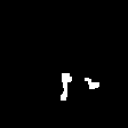

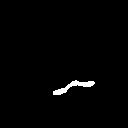

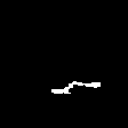

Median IOU:  0.6084146036509127


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

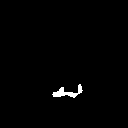

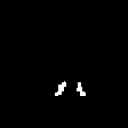

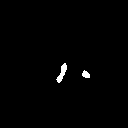

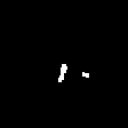

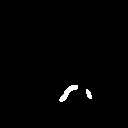

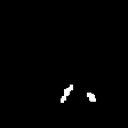

Median IOU:  0.616580828486436


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

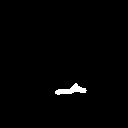

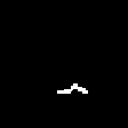

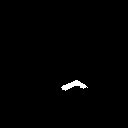

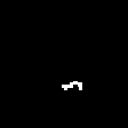

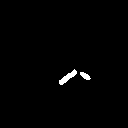

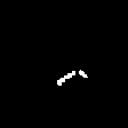

Median IOU:  0.6044444444444445


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

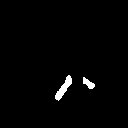

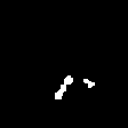

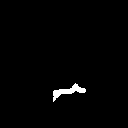

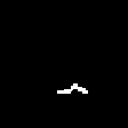

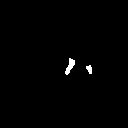

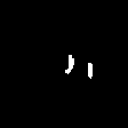

Median IOU:  0.5786976744186046


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

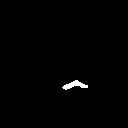

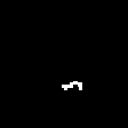

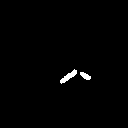

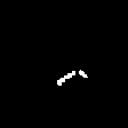

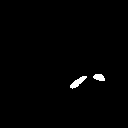

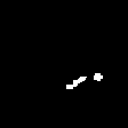

Median IOU:  0.5715647668393782


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

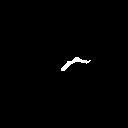

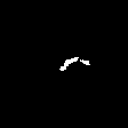

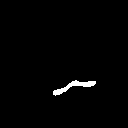

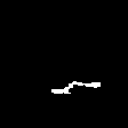

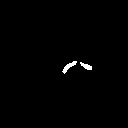

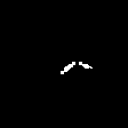

Median IOU:  0.5760094646917829


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

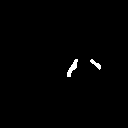

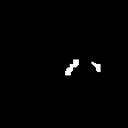

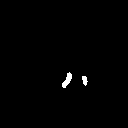

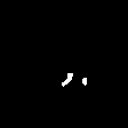

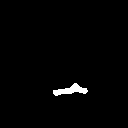

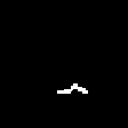

Median IOU:  0.6179594861660078


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

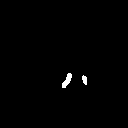

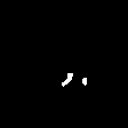

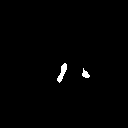

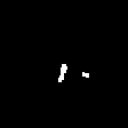

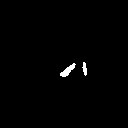

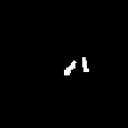

Median IOU:  0.6176633444075305


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

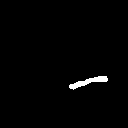

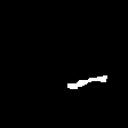

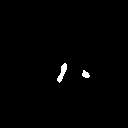

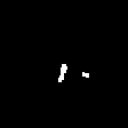

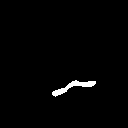

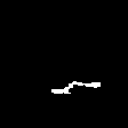

Median IOU:  0.6059272852751114


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

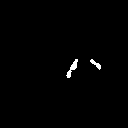

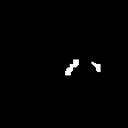

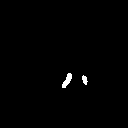

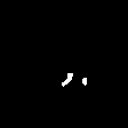

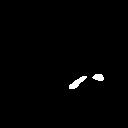

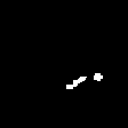

Median IOU:  0.6195425014765344


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

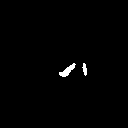

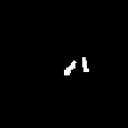

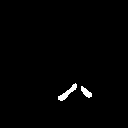

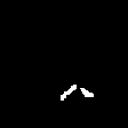

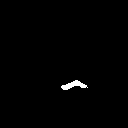

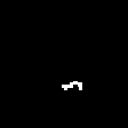

Median IOU:  0.6144636455556577


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

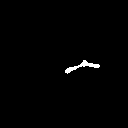

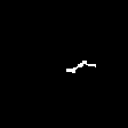

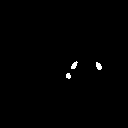

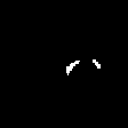

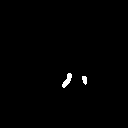

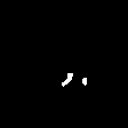

Median IOU:  0.5950874020494273


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

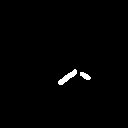

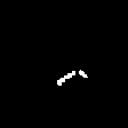

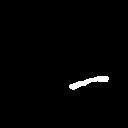

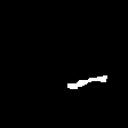

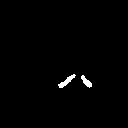

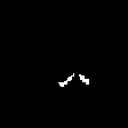

Median IOU:  0.6164005235602095


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

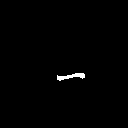

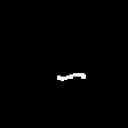

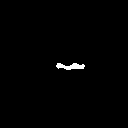

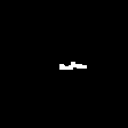

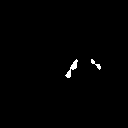

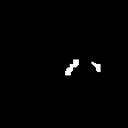

Median IOU:  0.6100557244174265


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

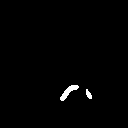

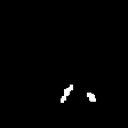

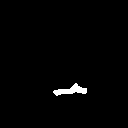

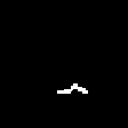

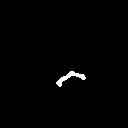

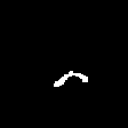

Median IOU:  0.6082171358414452


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

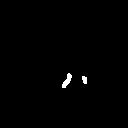

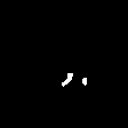

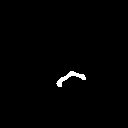

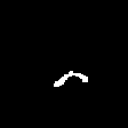

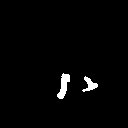

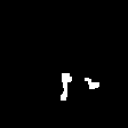

Median IOU:  0.6105123160898839


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

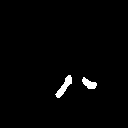

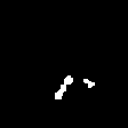

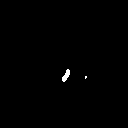

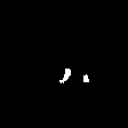

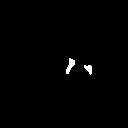

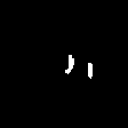

Median IOU:  0.6300460034502587


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

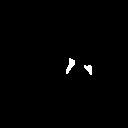

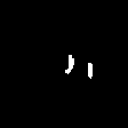

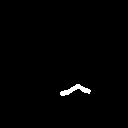

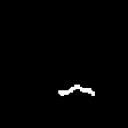

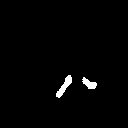

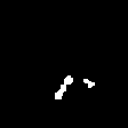

Median IOU:  0.6004016064257028


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

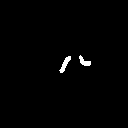

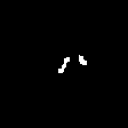

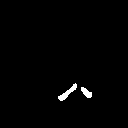

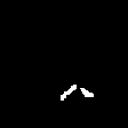

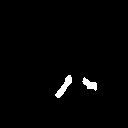

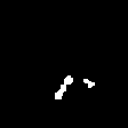

Median IOU:  0.6181972789115646


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

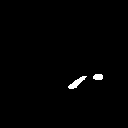

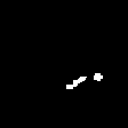

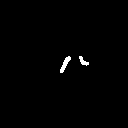

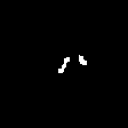

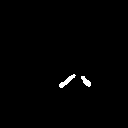

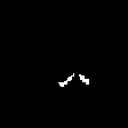

Median IOU:  0.6058071147147832


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

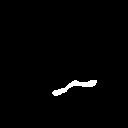

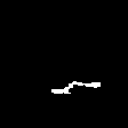

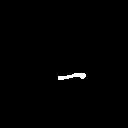

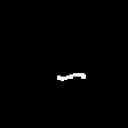

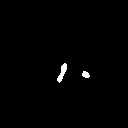

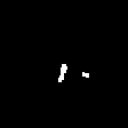

Median IOU:  0.6058865860679332


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

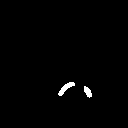

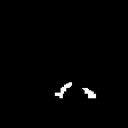

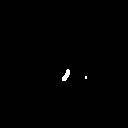

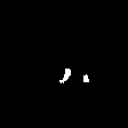

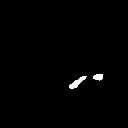

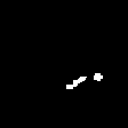

Median IOU:  0.584961334961335


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

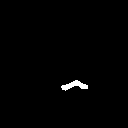

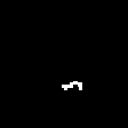

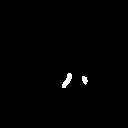

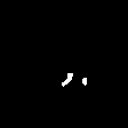

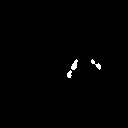

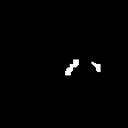

Median IOU:  0.6022429014555


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

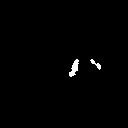

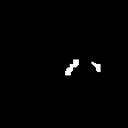

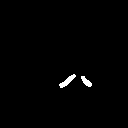

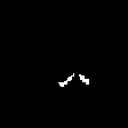

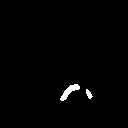

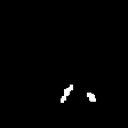

Median IOU:  0.604102465331279


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

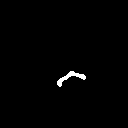

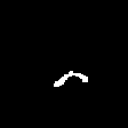

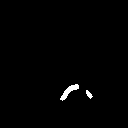

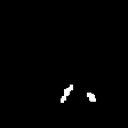

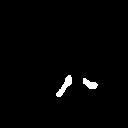

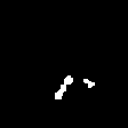

Median IOU:  0.5795680238331679


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

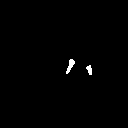

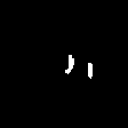

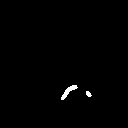

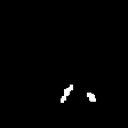

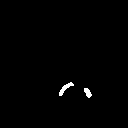

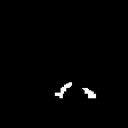

Median IOU:  0.5055692055692056


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

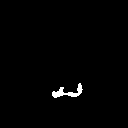

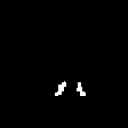

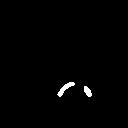

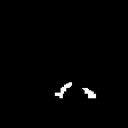

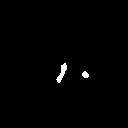

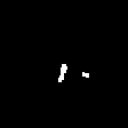

Median IOU:  0.6139334637964775


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

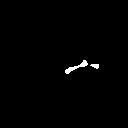

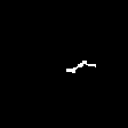

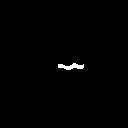

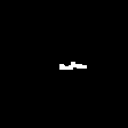

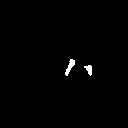

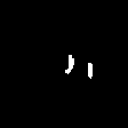

Median IOU:  0.5772349617813226


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

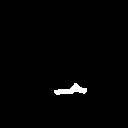

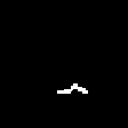

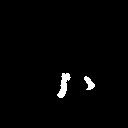

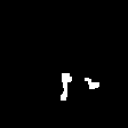

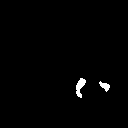

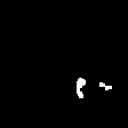

Median IOU:  0.6065803422686658


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

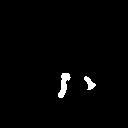

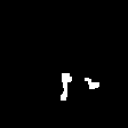

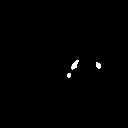

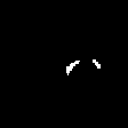

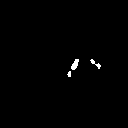

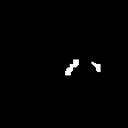

Median IOU:  0.5976878612716763


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

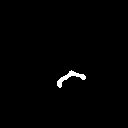

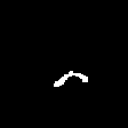

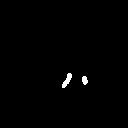

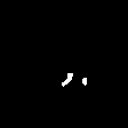

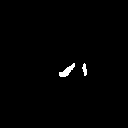

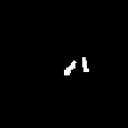

Median IOU:  0.5976744186046512


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

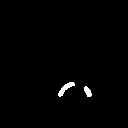

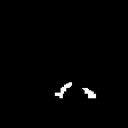

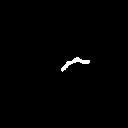

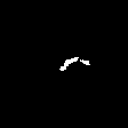

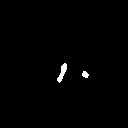

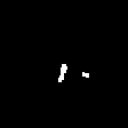

Median IOU:  0.6032407407407407


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

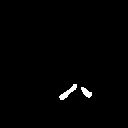

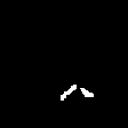

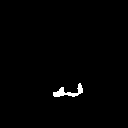

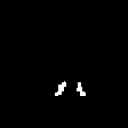

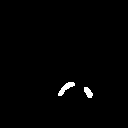

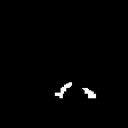

Median IOU:  0.6094377996222943


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

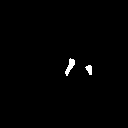

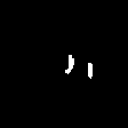

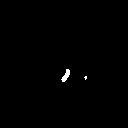

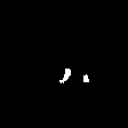

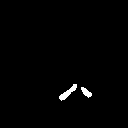

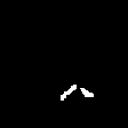

Median IOU:  0.6001950554615529


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

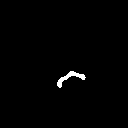

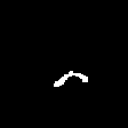

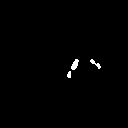

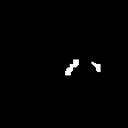

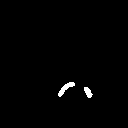

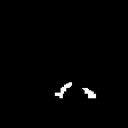

Median IOU:  0.5982450801379591


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

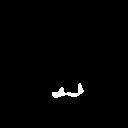

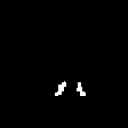

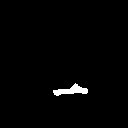

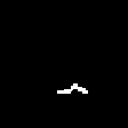

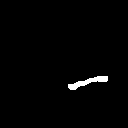

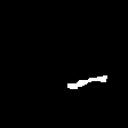

Median IOU:  0.5990205798810226


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

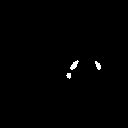

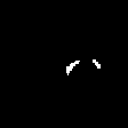

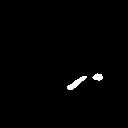

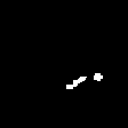

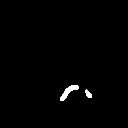

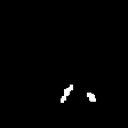

Median IOU:  0.6105837451680776


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

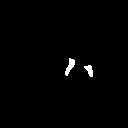

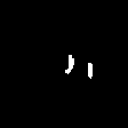

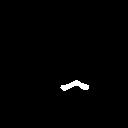

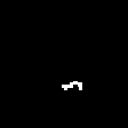

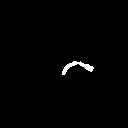

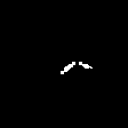

Median IOU:  0.6032787246709148


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

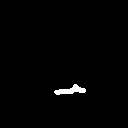

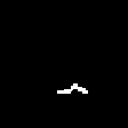

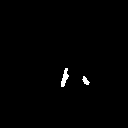

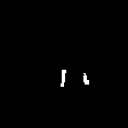

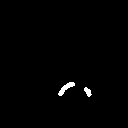

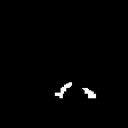

Median IOU:  0.5648218061008758


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

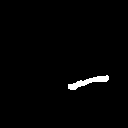

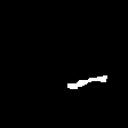

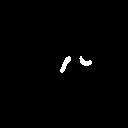

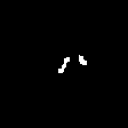

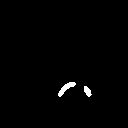

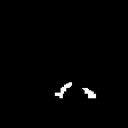

Median IOU:  0.6151589912280702


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

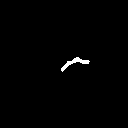

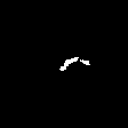

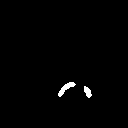

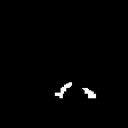

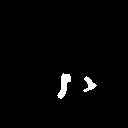

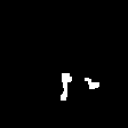

Median IOU:  0.6044212796549245


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

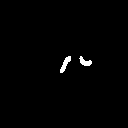

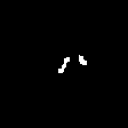

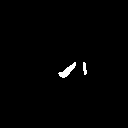

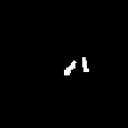

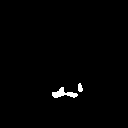

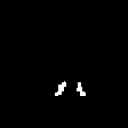

Median IOU:  0.6187743774377438


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

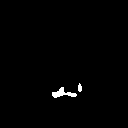

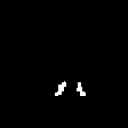

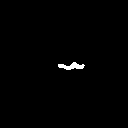

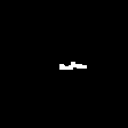

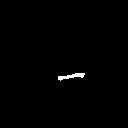

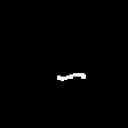

Median IOU:  0.614356884057971


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

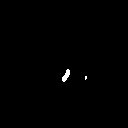

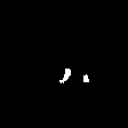

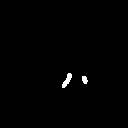

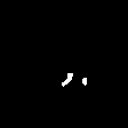

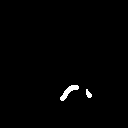

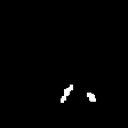

Median IOU:  0.605870559810826


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

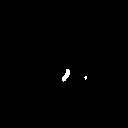

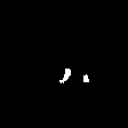

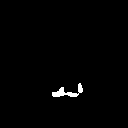

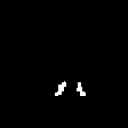

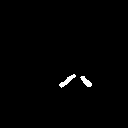

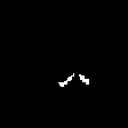

Median IOU:  0.602175567393348


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

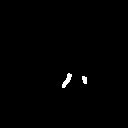

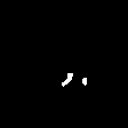

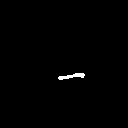

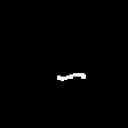

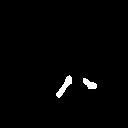

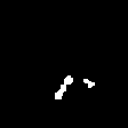

Median IOU:  0.5962843729040912


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

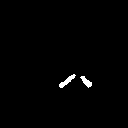

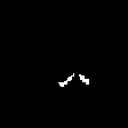

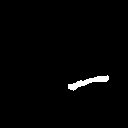

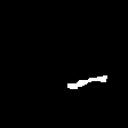

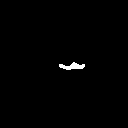

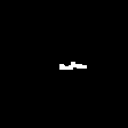

Median IOU:  0.6096104846579204


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

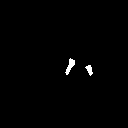

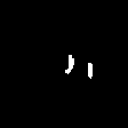

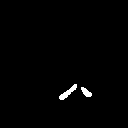

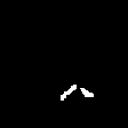

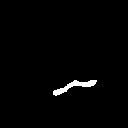

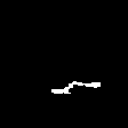

Median IOU:  0.6116886272815638


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

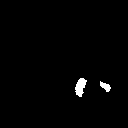

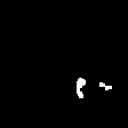

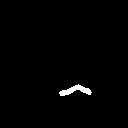

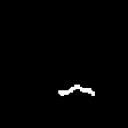

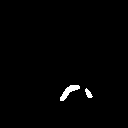

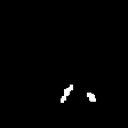

Median IOU:  0.6214177978883861


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

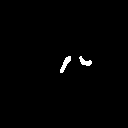

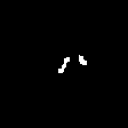

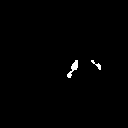

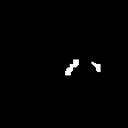

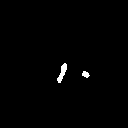

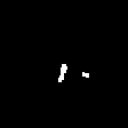

Median IOU:  0.6077027027027027


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

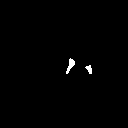

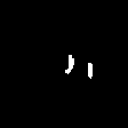

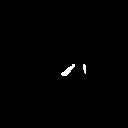

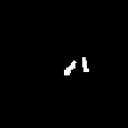

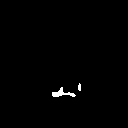

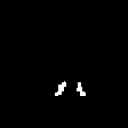

Median IOU:  0.5052083333333333


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

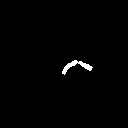

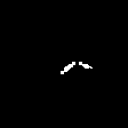

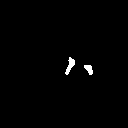

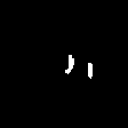

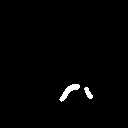

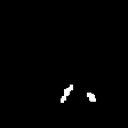

Median IOU:  0.6184755883386021


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

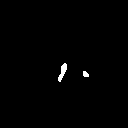

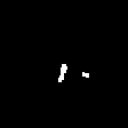

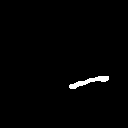

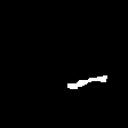

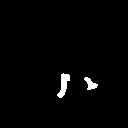

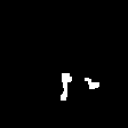

Median IOU:  0.5626048853253776


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

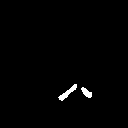

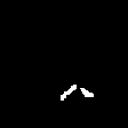

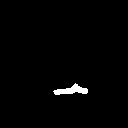

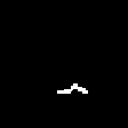

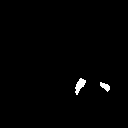

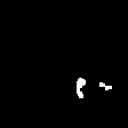

Median IOU:  0.6000110815602837


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

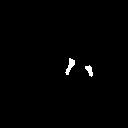

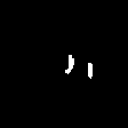

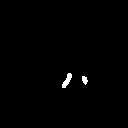

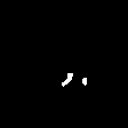

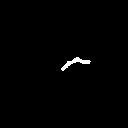

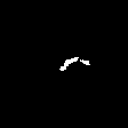

Median IOU:  0.5965881197839961


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

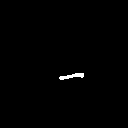

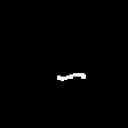

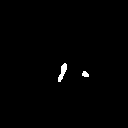

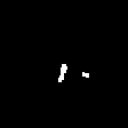

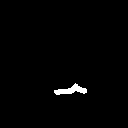

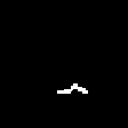

Median IOU:  0.5732467117524895


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

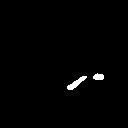

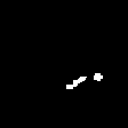

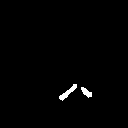

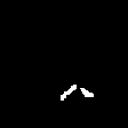

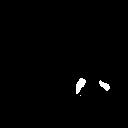

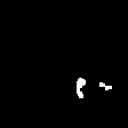

Median IOU:  0.6021192164809186


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

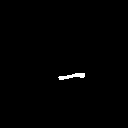

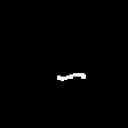

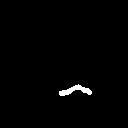

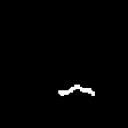

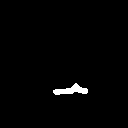

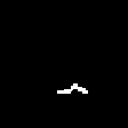

Median IOU:  0.6012450173422375


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

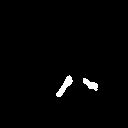

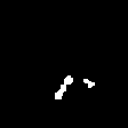

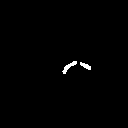

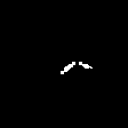

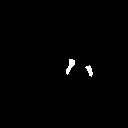

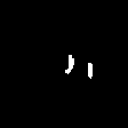

Median IOU:  0.5774995741781639


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

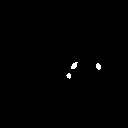

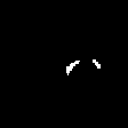

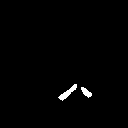

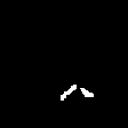

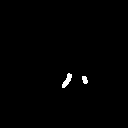

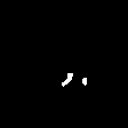

Median IOU:  0.6042863657090742


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

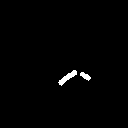

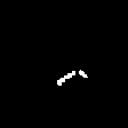

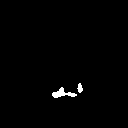

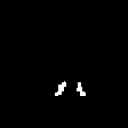

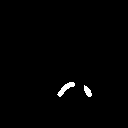

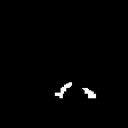

Median IOU:  0.6022385748893463


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

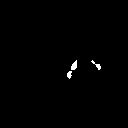

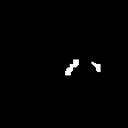

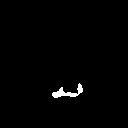

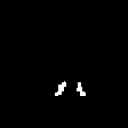

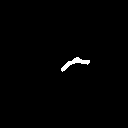

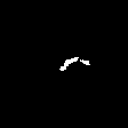

Median IOU:  0.6152380952380953


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

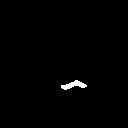

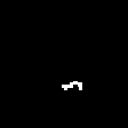

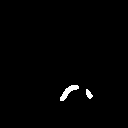

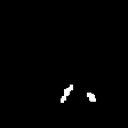

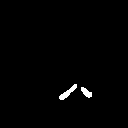

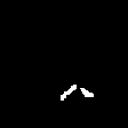

Median IOU:  0.5939770114942529


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

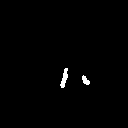

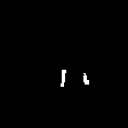

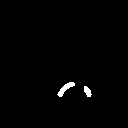

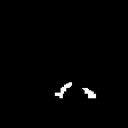

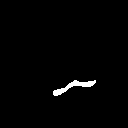

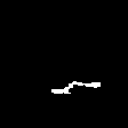

Median IOU:  0.5900250613480917


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

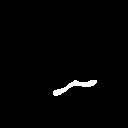

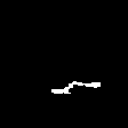

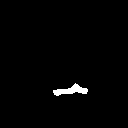

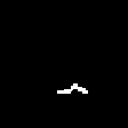

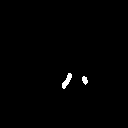

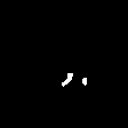

Median IOU:  0.6072936147475287


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

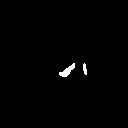

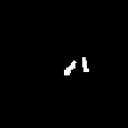

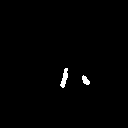

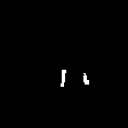

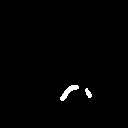

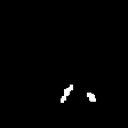

Median IOU:  0.5995749348690524


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

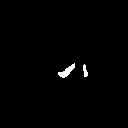

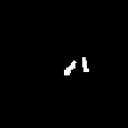

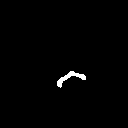

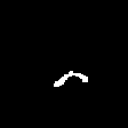

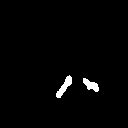

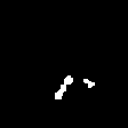

Median IOU:  0.6078272604588394


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

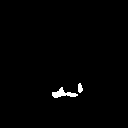

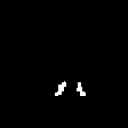

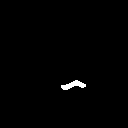

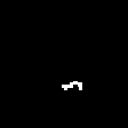

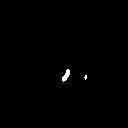

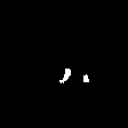

Median IOU:  0.6225569122053759


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

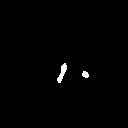

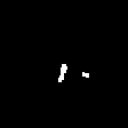

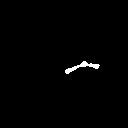

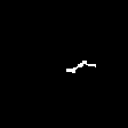

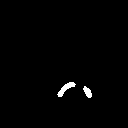

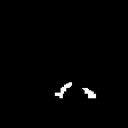

Median IOU:  0.6147782976827094


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

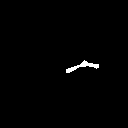

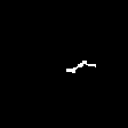

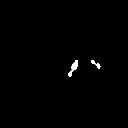

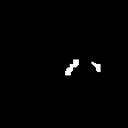

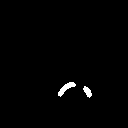

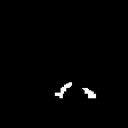

Median IOU:  0.61369825708061


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

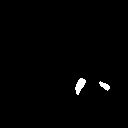

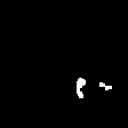

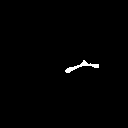

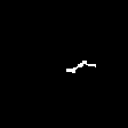

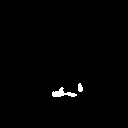

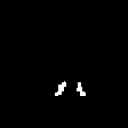

Median IOU:  0.6064692737430167


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

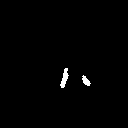

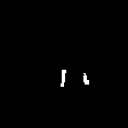

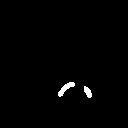

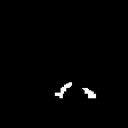

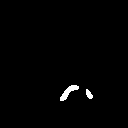

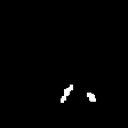

Median IOU:  0.605344749118216


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

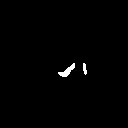

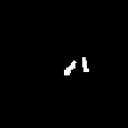

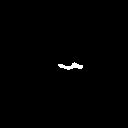

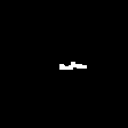

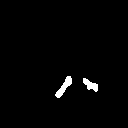

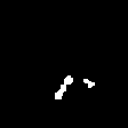

Median IOU:  0.5772980058790815


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

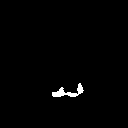

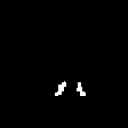

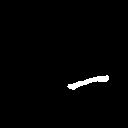

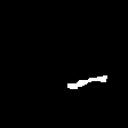

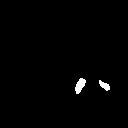

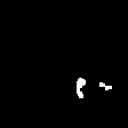

Median IOU:  0.587942612942613


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

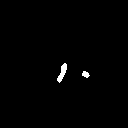

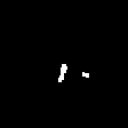

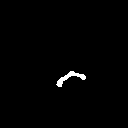

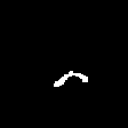

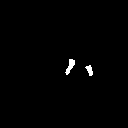

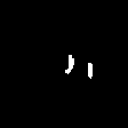

Median IOU:  0.594361033519553


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

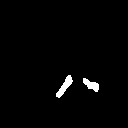

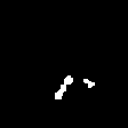

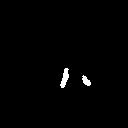

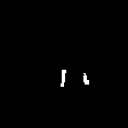

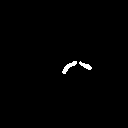

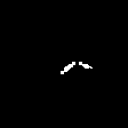

Median IOU:  0.6055255713167873


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

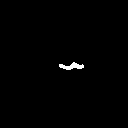

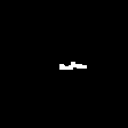

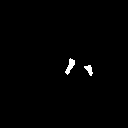

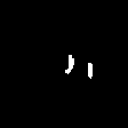

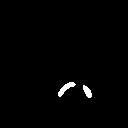

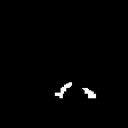

Median IOU:  0.6047808764940239


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

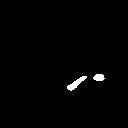

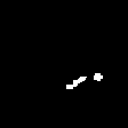

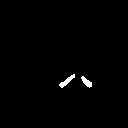

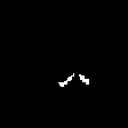

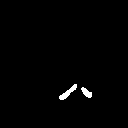

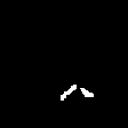

Median IOU:  0.6015873015873016


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

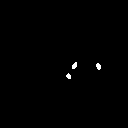

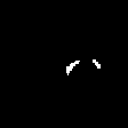

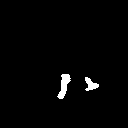

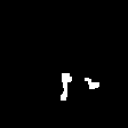

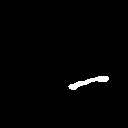

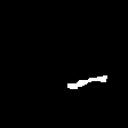

Median IOU:  0.5771473043724353


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

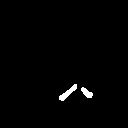

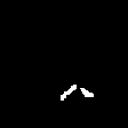

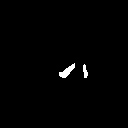

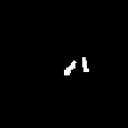

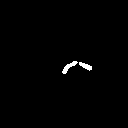

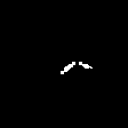

Median IOU:  0.6051720019111324


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

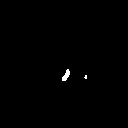

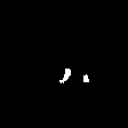

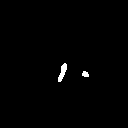

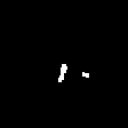

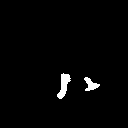

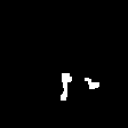

Median IOU:  0.6


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

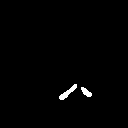

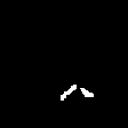

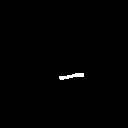

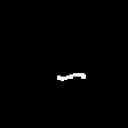

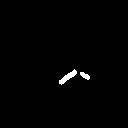

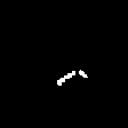

Median IOU:  0.6076653616319803


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

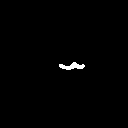

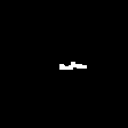

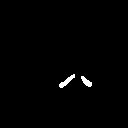

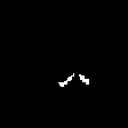

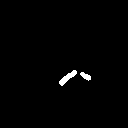

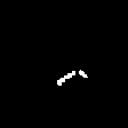

Median IOU:  0.600832492811658


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

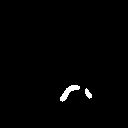

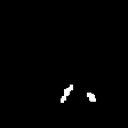

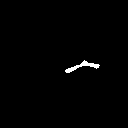

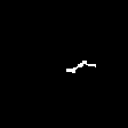

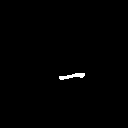

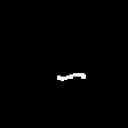

Median IOU:  0.6140506891951979


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

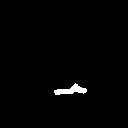

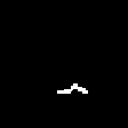

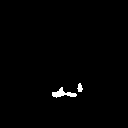

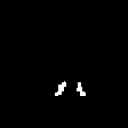

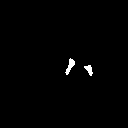

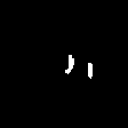

Median IOU:  0.6071384156199477


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

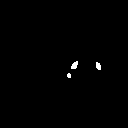

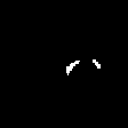

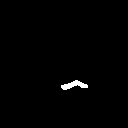

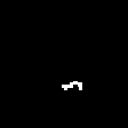

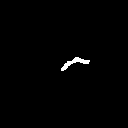

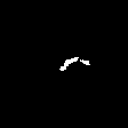

Median IOU:  0.6336817514750367


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

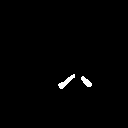

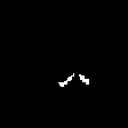

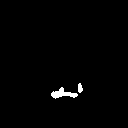

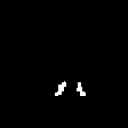

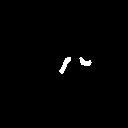

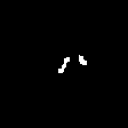

Median IOU:  0.6179159280830591


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

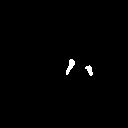

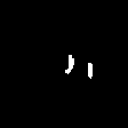

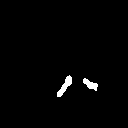

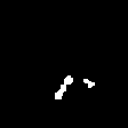

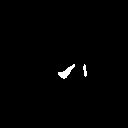

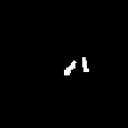

Median IOU:  0.5934188991299854


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

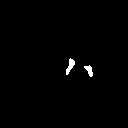

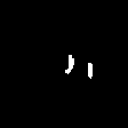

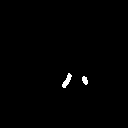

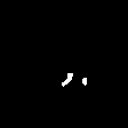

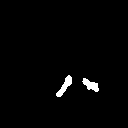

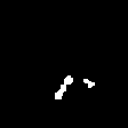

Median IOU:  0.5980225988700565


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

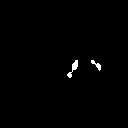

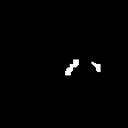

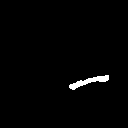

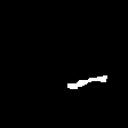

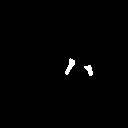

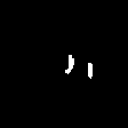

Median IOU:  0.624649637738643


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

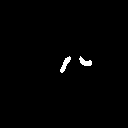

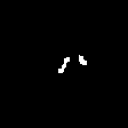

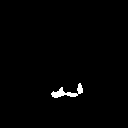

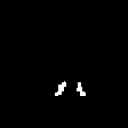

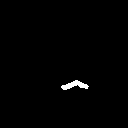

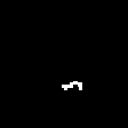

Median IOU:  0.613909604519774


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

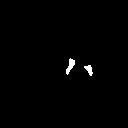

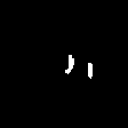

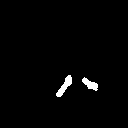

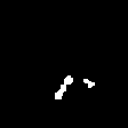

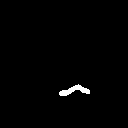

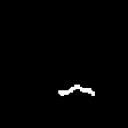

Median IOU:  0.6125349237051365


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

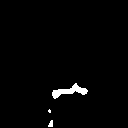

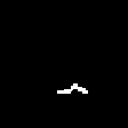

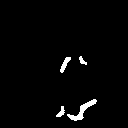

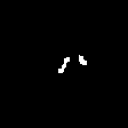

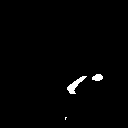

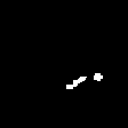

Median IOU:  0.5298254654817018


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

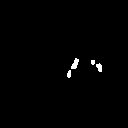

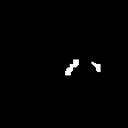

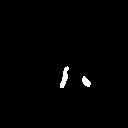

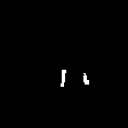

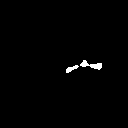

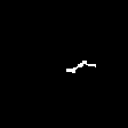

Median IOU:  0.610808030214834


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

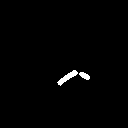

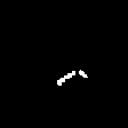

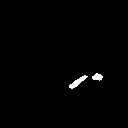

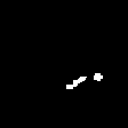

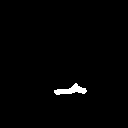

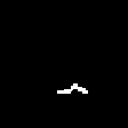

Median IOU:  0.616188919621155


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

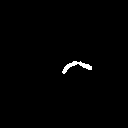

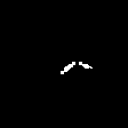

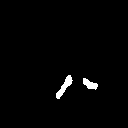

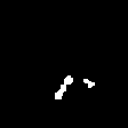

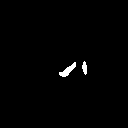

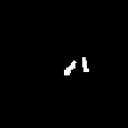

Median IOU:  0.59770711320862


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

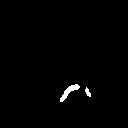

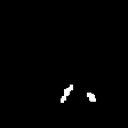

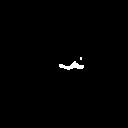

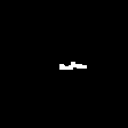

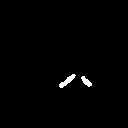

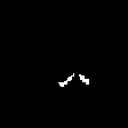

Median IOU:  0.6002870887647425


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

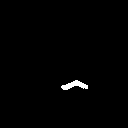

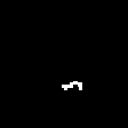

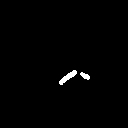

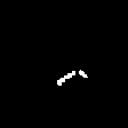

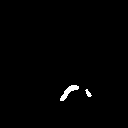

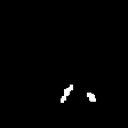

Median IOU:  0.5901102865388579


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

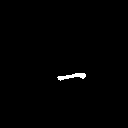

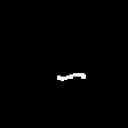

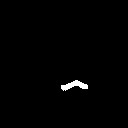

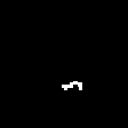

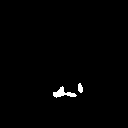

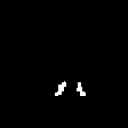

Median IOU:  0.6147824882238848


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

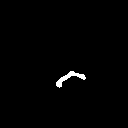

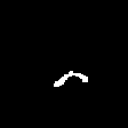

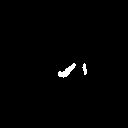

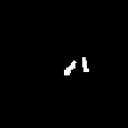

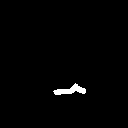

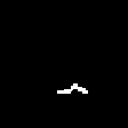

Median IOU:  0.6074585892425088


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

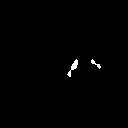

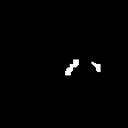

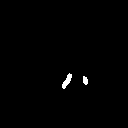

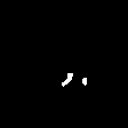

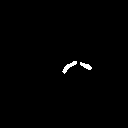

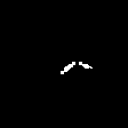

Median IOU:  0.5655486266674739


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

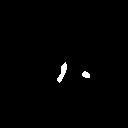

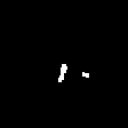

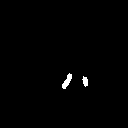

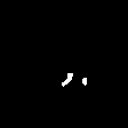

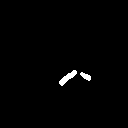

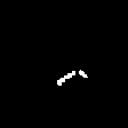

Median IOU:  0.5869178812655528


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

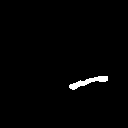

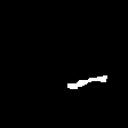

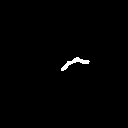

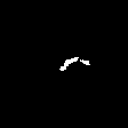

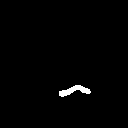

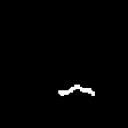

Median IOU:  0.6121108650178417


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

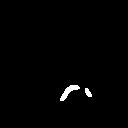

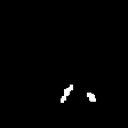

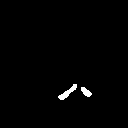

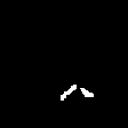

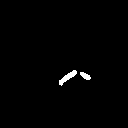

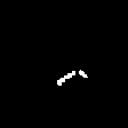

Median IOU:  0.604341475542296


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

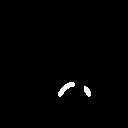

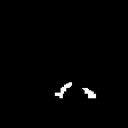

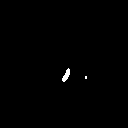

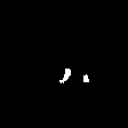

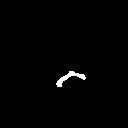

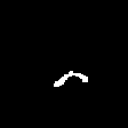

Median IOU:  0.6096103018009711


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

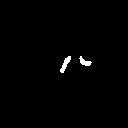

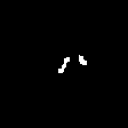

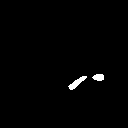

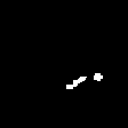

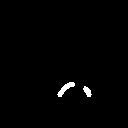

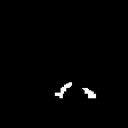

Median IOU:  0.6101709843989123


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

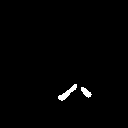

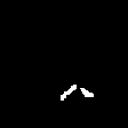

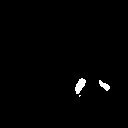

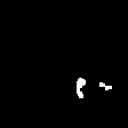

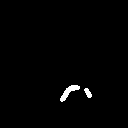

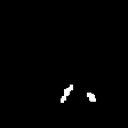

Median IOU:  0.611799442896936


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

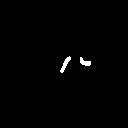

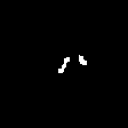

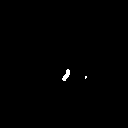

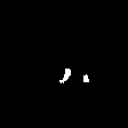

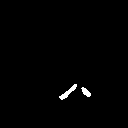

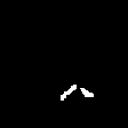

Median IOU:  0.564719887955182


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

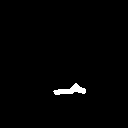

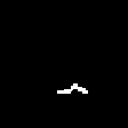

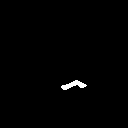

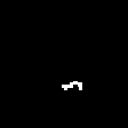

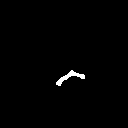

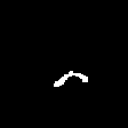

Median IOU:  0.5913021514323071


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

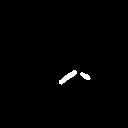

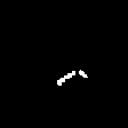

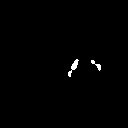

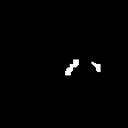

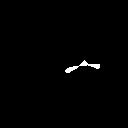

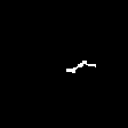

Median IOU:  0.6058039588991236


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

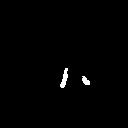

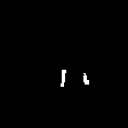

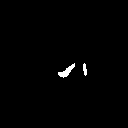

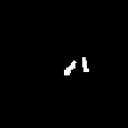

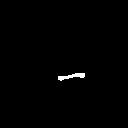

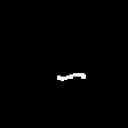

Median IOU:  0.5915343915343916


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

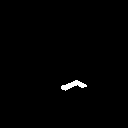

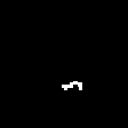

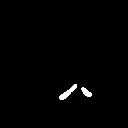

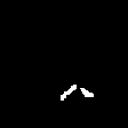

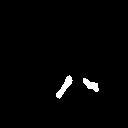

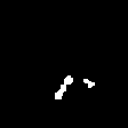

Median IOU:  0.5994791666666667


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

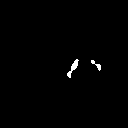

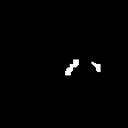

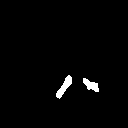

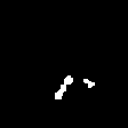

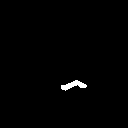

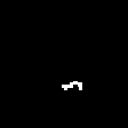

Median IOU:  0.6115505456950722


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

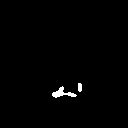

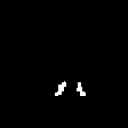

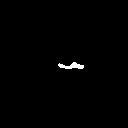

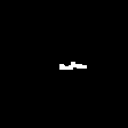

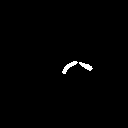

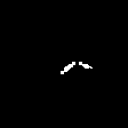

Median IOU:  0.6142149929278642


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

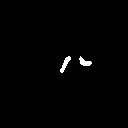

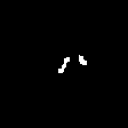

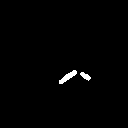

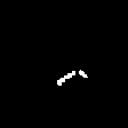

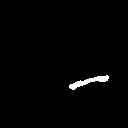

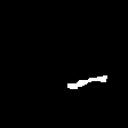

Median IOU:  0.5999889193606471


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

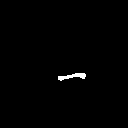

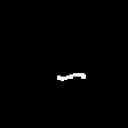

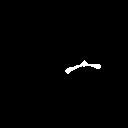

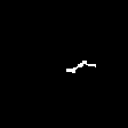

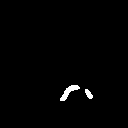

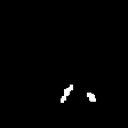

Median IOU:  0.5977997557508659


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

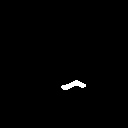

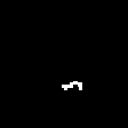

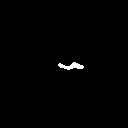

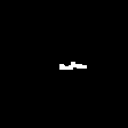

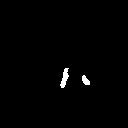

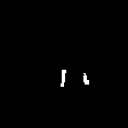

Median IOU:  0.6140873015873016


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

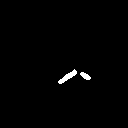

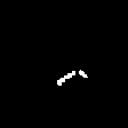

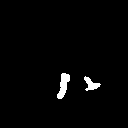

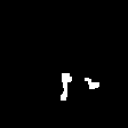

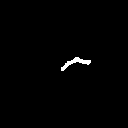

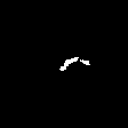

Median IOU:  0.6076751196273109


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

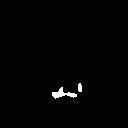

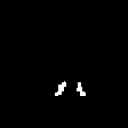

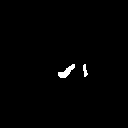

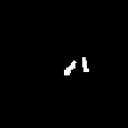

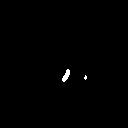

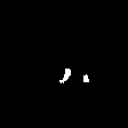

Median IOU:  0.5913546911868448


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

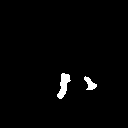

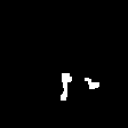

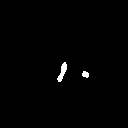

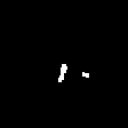

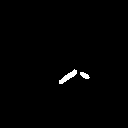

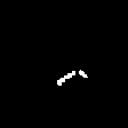

Median IOU:  0.5948695088344951


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

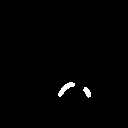

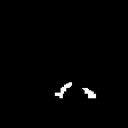

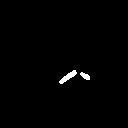

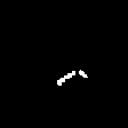

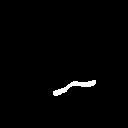

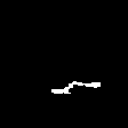

Median IOU:  0.5957940056300712


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

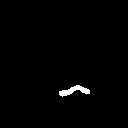

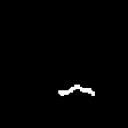

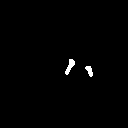

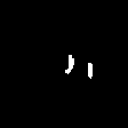

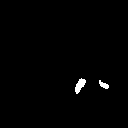

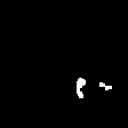

Median IOU:  0.5868080635629391


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

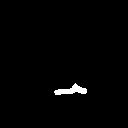

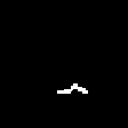

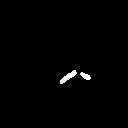

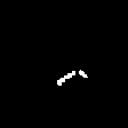

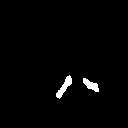

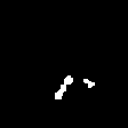

Median IOU:  0.5803744935937551


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

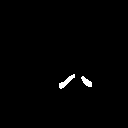

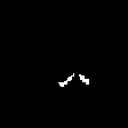

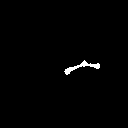

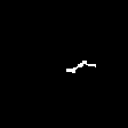

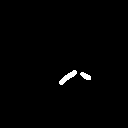

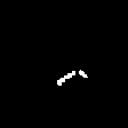

Median IOU:  0.6065641025641025


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

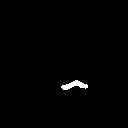

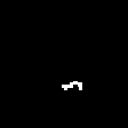

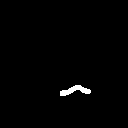

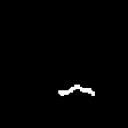

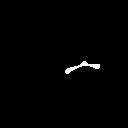

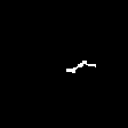

Median IOU:  0.582098992778107


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

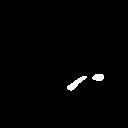

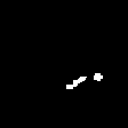

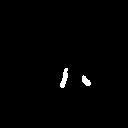

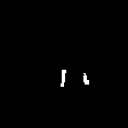

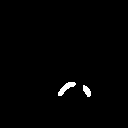

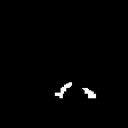

Median IOU:  0.615206132704338


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

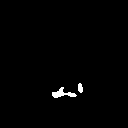

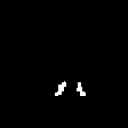

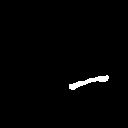

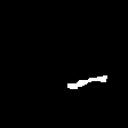

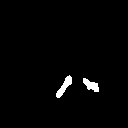

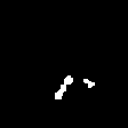

Median IOU:  0.6044954074422986


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

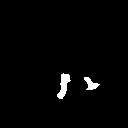

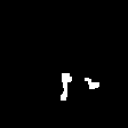

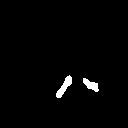

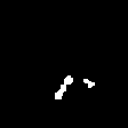

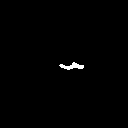

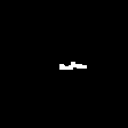

Median IOU:  0.5840808416389812


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

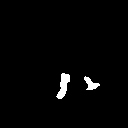

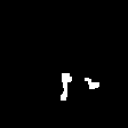

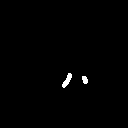

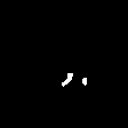

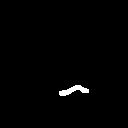

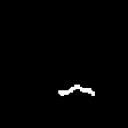

Median IOU:  0.6063583815028901


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

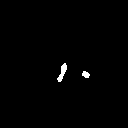

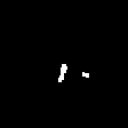

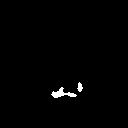

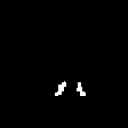

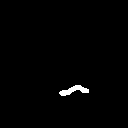

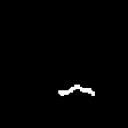

Median IOU:  0.5957615369380075


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

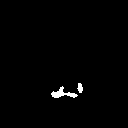

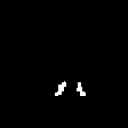

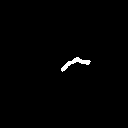

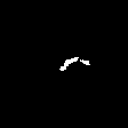

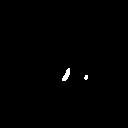

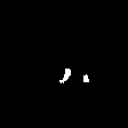

Median IOU:  0.5845518619819061


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

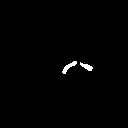

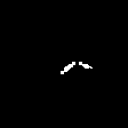

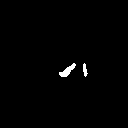

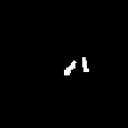

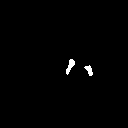

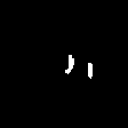

Median IOU:  0.5964293193717277


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

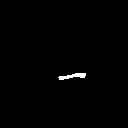

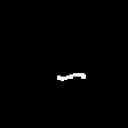

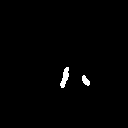

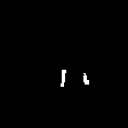

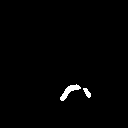

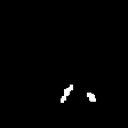

Median IOU:  0.6075114927573944


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

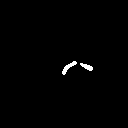

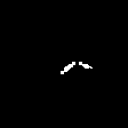

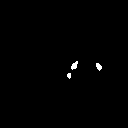

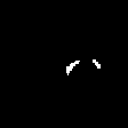

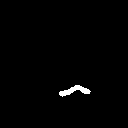

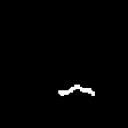

Median IOU:  0.5938144329896907


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

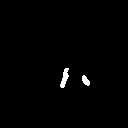

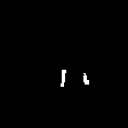

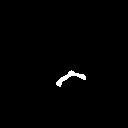

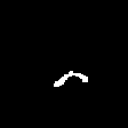

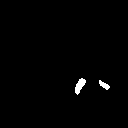

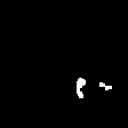

Median IOU:  0.6081237113402062


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

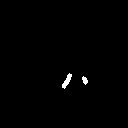

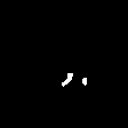

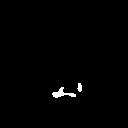

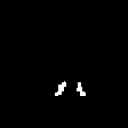

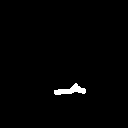

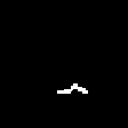

Median IOU:  0.5756219745581448


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

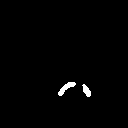

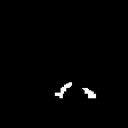

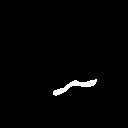

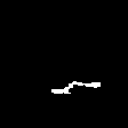

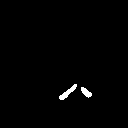

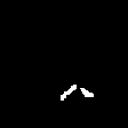

Median IOU:  0.6008135168961202


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

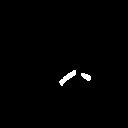

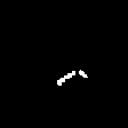

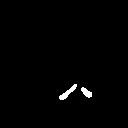

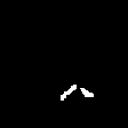

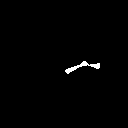

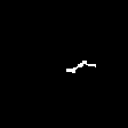

Median IOU:  0.5782593168890136


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

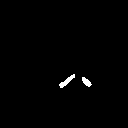

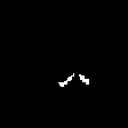

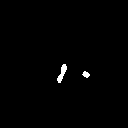

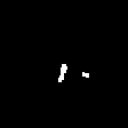

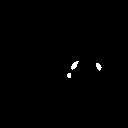

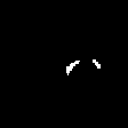

Median IOU:  0.5774639276106628


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

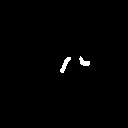

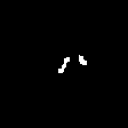

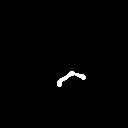

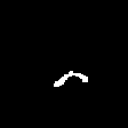

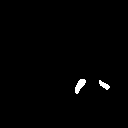

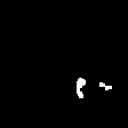

Median IOU:  0.575958115183246


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

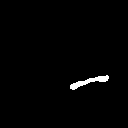

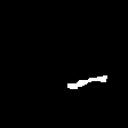

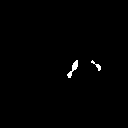

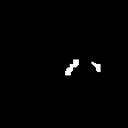

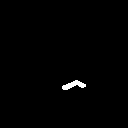

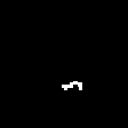

Median IOU:  0.5871937172774868


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

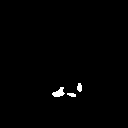

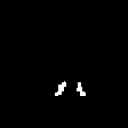

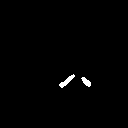

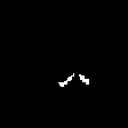

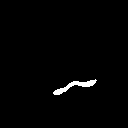

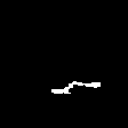

Median IOU:  0.5807549458045933


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

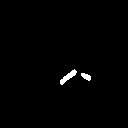

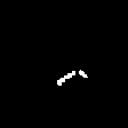

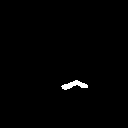

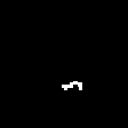

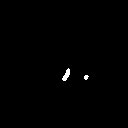

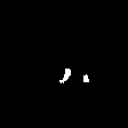

Median IOU:  0.5860829103214891


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

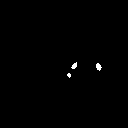

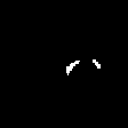

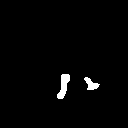

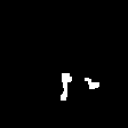

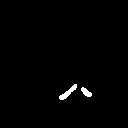

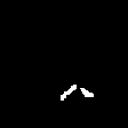

Median IOU:  0.5938949938949939


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

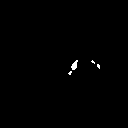

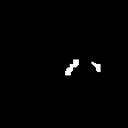

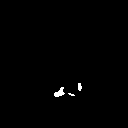

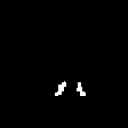

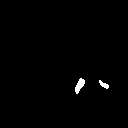

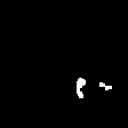

Median IOU:  0.513929180887372


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

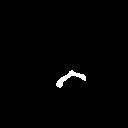

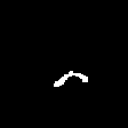

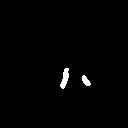

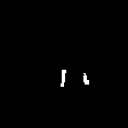

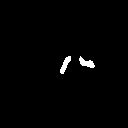

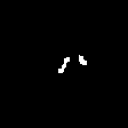

Median IOU:  0.6189416812331161


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

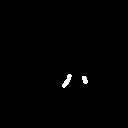

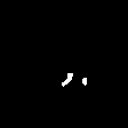

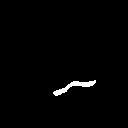

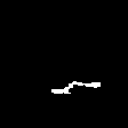

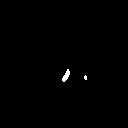

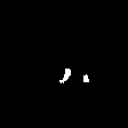

Median IOU:  0.5713239681076097


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

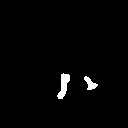

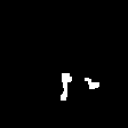

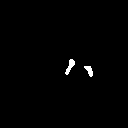

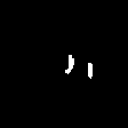

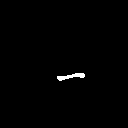

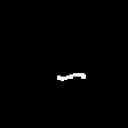

Median IOU:  0.5954439907118264


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

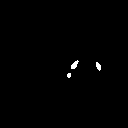

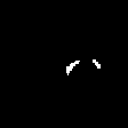

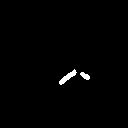

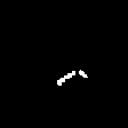

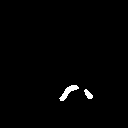

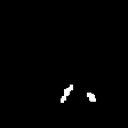

Median IOU:  0.6021107456140351


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

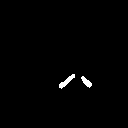

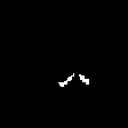

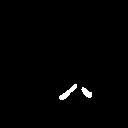

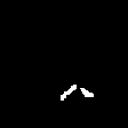

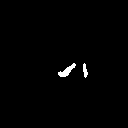

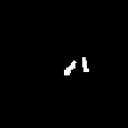

Median IOU:  0.595959595959596


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

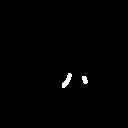

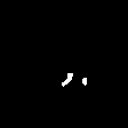

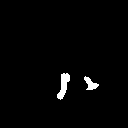

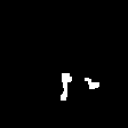

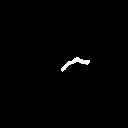

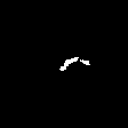

Median IOU:  0.6016182040998217


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

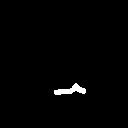

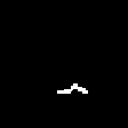

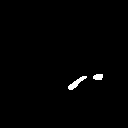

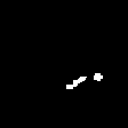

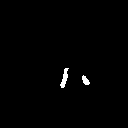

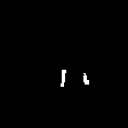

Median IOU:  0.5946633154079963


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

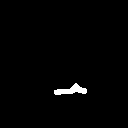

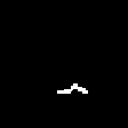

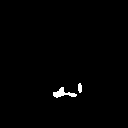

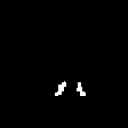

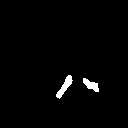

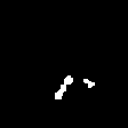

Median IOU:  0.5958252962248554


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

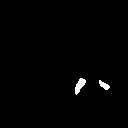

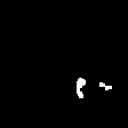

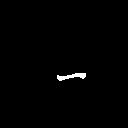

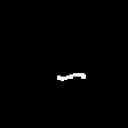

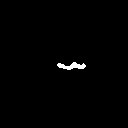

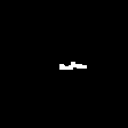

Median IOU:  0.5968965333048448


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

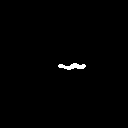

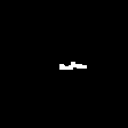

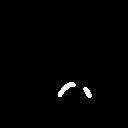

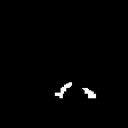

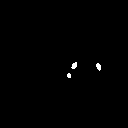

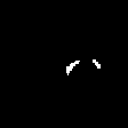

Median IOU:  0.5892588117719008


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

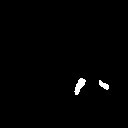

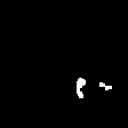

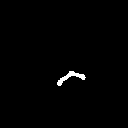

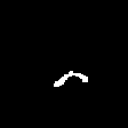

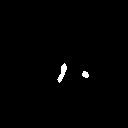

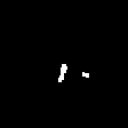

Median IOU:  0.6019756387403445


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

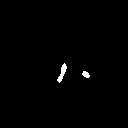

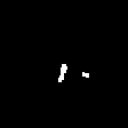

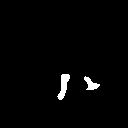

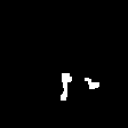

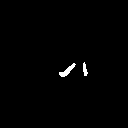

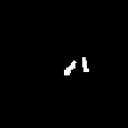

Median IOU:  0.5807722007722007


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

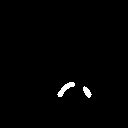

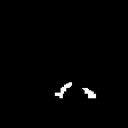

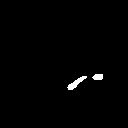

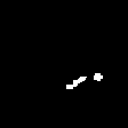

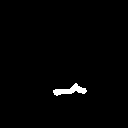

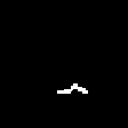

Median IOU:  0.5980833333333333


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

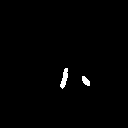

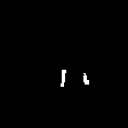

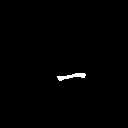

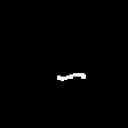

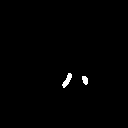

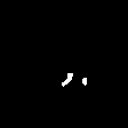

Median IOU:  0.5914597994483541


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

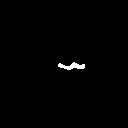

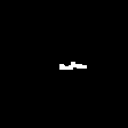

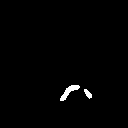

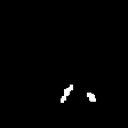

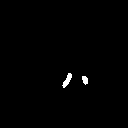

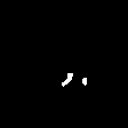

Median IOU:  0.5884824120603015


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

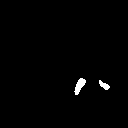

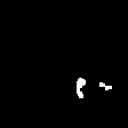

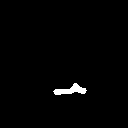

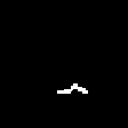

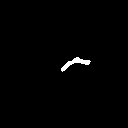

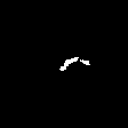

Median IOU:  0.6096304347826087


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

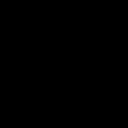

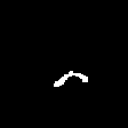

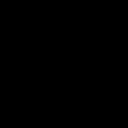

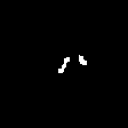

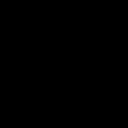

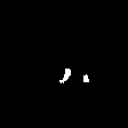

Median IOU:  0.0


Training:   0%|          | 0/17 [00:00<?, ?it/s]

0.6489688740873576


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

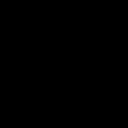

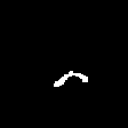

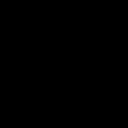

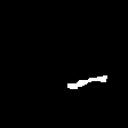

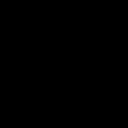

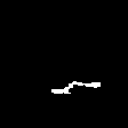

Median IOU:  0.0


In [59]:
# criterion
device = torch.device('cuda')
model = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
#model.load_state_dict(torch.load('best_model_unet_nobo_64.pth'))
#model.load_state_dict(torch.load('best_model_unet_nobo_64_more_blocks.pth'))
model.load_state_dict(torch.load('best_model_unet_nobo_128_thirteenth_bis2.pth'))

#criterion = torch.nn.CrossEntropyLoss(reduction='none')
criterion = torch.nn.BCELoss(weight = torch.Tensor([1]).cuda())

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  validation_names = eval_ds2.names,
                  lr_scheduler=torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.999),
                  epochs=500,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

In [56]:
trainer.best_score

0.6387759797530486

In [48]:
trainer.best_score

0.5798022598870056

In [81]:
trainer.best_score

0.5826764211043687

In [78]:
def classifier(out_size, num_classes):
    classifier = torch.nn.Sequential(torch.nn.Linear(out_size, int(out_size/2)), torch.nn.BatchNorm1d(int(out_size/2)) , torch.nn.ReLU(),
                               torch.nn.Dropout(p=0.1), torch.nn.Linear(int(out_size/2), num_classes))
    return(classifier)

def Resnet50(num_classes, in_channels):
    net = models.resnet50(pretrained=False)
    net.conv1 = torch.nn.Conv2d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
    out_size = net.fc.in_features
    net.fc = classifier(out_size, num_classes)
    return(net)

In [121]:
#chosen_indexes = np.random.choice(list(range(65)), 55, replace = False)
#eval_indexes = np.setdiff1d(np.array(list(range(65))), chosen_indexes)
#eval_indexes = chosen_indexes
train_ds_box = Custom_dataset('train.pkl', chosen_indexes = chosen_indexes,
                              box_train = True, augmented = False, randomize = True, size = (128, 128))
eval_ds_box = Custom_dataset('train.pkl', chosen_indexes = eval_indexes,
                             box_train = True, augmented = False, randomize = False, size = (128, 128))

dataloader_training = torch.utils.data.DataLoader(train_ds_box, batch_size = 100, shuffle = True)
dataloader_validation = torch.utils.data.DataLoader(eval_ds_box, batch_size = 1, shuffle = False)

# criterion
device = torch.device('cuda')
model = Resnet50(num_classes = 4,
                 in_channels = 1)
model.load_state_dict(torch.load('best_model_box.pth'))
#criterion = torch.nn.CrossEntropyLoss(reduction='none')
criterion = torch.nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  validation_names = eval_ds.names,
                  lr_scheduler=torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.99),
                  epochs=100,
                  epoch=0,
                  notebook=True,
                 box_training= True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8614032566547394
saved with score:  0.8614032566547394


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8562002182006836


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8843289911746979
saved with score:  0.8843289911746979


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8646225035190582


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8531877100467682


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8690933585166931


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8608772158622742


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8528057336807251


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.874273031949997


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8700098097324371


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8665014505386353


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8660100102424622


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8559518158435822


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8661762475967407


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.864402174949646


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8778138756752014


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8624795079231262


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.871643453836441


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8651157021522522


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8699101209640503


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8796718716621399


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8775647282600403


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8734234869480133


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8761763870716095


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.877185046672821


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8690081238746643


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8762623369693756


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8718093633651733


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8716526329517365


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8773491680622101


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8768235146999359


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8719234466552734


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8776204288005829


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8755351305007935


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.868544191122055


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8770506978034973


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8598819077014923


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8765985369682312


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8702313005924225


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

Median IOU:  0.8696118593215942


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/1320 [00:00<?, ?it/s]

AttributeError: 'float' object has no attribute 'item'

In [9]:
def plot_training(training_losses,
                  validation_losses,
                  learning_rate,
                  gaussian=True,
                  sigma=2,
                  figsize=(8, 6)
                  ):
    """
    Returns a loss plot with training loss, validation loss and learning rate.
    """

    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from scipy.ndimage import gaussian_filter

    list_len = len(training_losses)
    x_range = list(range(1, list_len + 1))  # number of x values

    fig = plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    subfig1 = fig.add_subplot(grid[0, 0])
    subfig2 = fig.add_subplot(grid[0, 1])

    subfigures = fig.get_axes()

    for i, subfig in enumerate(subfigures, start=1):
        subfig.spines['top'].set_visible(False)
        subfig.spines['right'].set_visible(False)

    if gaussian:
        training_losses_gauss = gaussian_filter(training_losses, sigma=sigma)
        validation_losses_gauss = gaussian_filter(validation_losses, sigma=sigma)

        linestyle_original = '.'
        color_original_train = 'lightcoral'
        color_original_valid = 'lightgreen'
        color_smooth_train = 'red'
        color_smooth_valid = 'green'
        alpha = 0.25
    else:
        linestyle_original = '-'
        color_original_train = 'red'
        color_original_valid = 'green'
        alpha = 1.0

    # Subfig 1
    subfig1.plot(x_range, training_losses, linestyle_original, color=color_original_train, label='Training',
                 alpha=alpha)
    subfig1.plot(x_range, validation_losses, linestyle_original, color=color_original_valid, label='Validation',
                 alpha=alpha)
    if gaussian:
        subfig1.plot(x_range, training_losses_gauss, '-', color=color_smooth_train, label='Training', alpha=0.75)
        subfig1.plot(x_range, validation_losses_gauss, '-', color=color_smooth_valid, label='Validation', alpha=0.75)
    subfig1.title.set_text('Training & validation loss')
    subfig1.set_xlabel('Epoch')
    subfig1.set_ylabel('Loss')

    subfig1.legend(loc='upper right')

    # Subfig 2
    subfig2.plot(x_range, learning_rate, color='black')
    subfig2.title.set_text('Learning rate')
    subfig2.set_xlabel('Epoch')
    subfig2.set_ylabel('LR')

    return fig

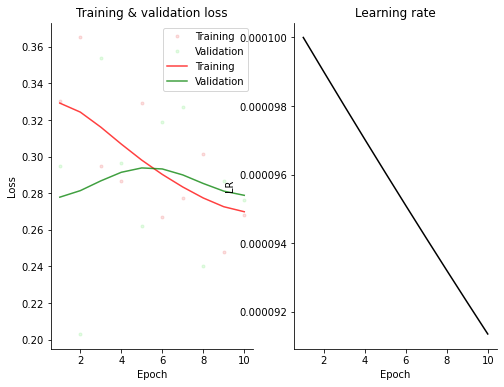

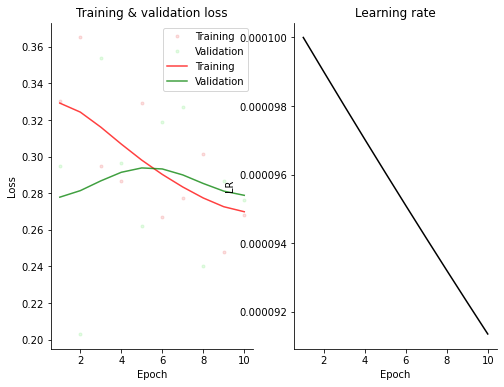

In [123]:
plot_training(training_losses,
                  validation_losses,
                  lr_rates,
                  gaussian=True,
                  sigma=2,
                  figsize=(8, 6)
                  )

In [26]:
torch.cuda.is_available()

True

In [141]:
dl = torch.utils.data.DataLoader(ds, batch_size = 1)

In [11]:
def resh(t):
    t1 = np.zeros((t.shape[2],t.shape[0],t.shape[1]))
    for i in range(t1.shape[0]):
        for j in range(t1.shape[1]):
            for k in range(t1.shape[2]):
                t1[i][j][k] = t[j][k][i]
    return t1

def inv_resh(t):
    t1 = np.zeros((t.shape[1],t.shape[2],t.shape[0]))
    for i in range(t1.shape[0]):
        for j in range(t1.shape[1]):
            for k in range(t1.shape[2]):
                t1[i][j][k] = t[k][i][j]
    return t1

In [12]:
class Custom_testdataset(torch.utils.data.Dataset):
    def __init__(self, file_name, size):
        self.data = load_zipped_pickle(file_name)
        self.video_index = []
        self.names = []
        
        self.size = size
        
        count = 0
        for i in range(len(self.data)):
            self.video_index.append(count)
            count += self.data[i]['video'].shape[2]
            for _ in range(self.data[i]['video'].shape[2]):
                self.names.append(self.data[i]['name'])
        self.video_index.append(count)

        self.indexer = list(range(count))
            
        self.transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                              #                     std = 1)
                                                    std=0.378)
                        ])
    def __getitem__(self, index):
        real_idx = index
        for i, count in enumerate(self.video_index):
            if real_idx >= count:
                old_count = count
                continue
            else:
                t = torch.Tensor(self.data[i-1]['video'][:, :, real_idx - old_count])
                image = transforms.ToPILImage()(t)
                if self.size is None:
                    return self.transform(image), self.transform(image), self.data[i-1]['name']
                else:
                    return self.transform(image.resize(self.size)), self.transform(image), self.data[i-1]['name']
    def __len__(self):
        return(len(self.indexer))

In [13]:
#test_ds_box = Custom_testdataset('test.pkl', size = (128, 128))
#testdata_box_loader = torch.utils.data.DataLoader(test_ds_box, batch_size = 1, shuffle = False)
test_ds_unet = Custom_testdataset('test.pkl', size = (128, 128))
testdata_unet_loader = torch.utils.data.DataLoader(test_ds_unet, batch_size = 1, shuffle = False)

In [14]:
transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                              #                     std = 1)
                                                    std=0.378)
                        ])

In [69]:
#unet infer
unet_model = UNet(in_channels=1,
             num_encoding_blocks = 4,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 64,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
unet_model.load_state_dict(torch.load('best_model_unet_nobo_64_bis.pth'))

indexes = test_ds_unet.video_index
labels = []
boxes = []
preds = []
unet_model.eval().cuda()

previous_name = ''
previous_im = None

for data in tqdm(test_ds_unet.data):
    for i in range(data['video'].shape[2]):
        name = data['name']
        x = data['video'][:, :, i]
        im = transforms.ToPILImage()(torch.Tensor(x)).resize((128,128))
        label = unet_model(transform(im).unsqueeze(0).cuda()).clamp(0,1)
        width = x.shape[0]
        height = x.shape[1]
        org_im = transforms.ToTensor()(transforms.ToPILImage()(label[0]).resize((height, width), Image.ANTIALIAS))
        #if previous_name == name:
        if False:
            labels.append((previous_im.detach() + org_im.detach())>0.9)
        else:
            labels.append(org_im.detach()>0.5)
        previous_name = name
        previous_im = org_im

100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


In [70]:
labels2 = labels

In [28]:
#unet infer
transform2 = transforms.Compose([transforms.Grayscale(),
          transforms.ToTensor(),
          transforms.Normalize(mean=0.591,
          #                     std = 1)
                                std=0.189)])

transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                              #                     std = 1)
                                                    std=0.378)
                        ])


unet_model8 = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)

unet_model11 = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)

unet_model14 = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)

unet_model8.load_state_dict(torch.load('best_model_unet_nobo_64_more_blocks.pth'))
unet_model14.load_state_dict(torch.load('best_model_unet_nobo_128_thirteenth_bis2.pth'))
unet_model11.load_state_dict(torch.load('best_model_unet_nobo_128_eleventh.pth'))

indexes = test_ds_unet.video_index
labels = []
boxes = []
preds = []
unet_model8.eval().cuda()
unet_model11.eval().cuda()
unet_model14.eval().cuda()

previous_name = ''
previous_im = None

for data in tqdm(test_ds_unet.data):
    video11 = RNMF_transform(data['video'])
    for i in range(data['video'].shape[2]):
        name = data['name']
        x8 = exposure.equalize_hist(data['video'][:, :, i])
        x14 = data['video'][:, :, i]
        x11 = video11[:, :, i]
        
        im8 = transforms.ToPILImage()(torch.Tensor(x8)).resize((128,128))
        label = unet_model8(transform(im8).unsqueeze(0).cuda()).clamp(0,1)
        
        im11 = transforms.ToPILImage()(torch.Tensor(x11)).resize((128,128))
        label += unet_model11(transform2(im11).unsqueeze(0).cuda()).clamp(0,1)
        
        im14 = transforms.ToPILImage()(torch.Tensor(x14)).resize((128,128))
        label += unet_model14(transform(im14).unsqueeze(0).cuda()).clamp(0,1)
        
        width = x8.shape[0]
        height = x8.shape[1]
        org_im = transforms.ToTensor()(transforms.ToPILImage()(label[0]).resize((height, width), Image.ANTIALIAS))
        #if previous_name == name:
        if False:
            labels.append((previous_im.detach() + org_im.detach())>0.9)
        else:
            labels.append(org_im.detach()>1.5)
        previous_name = name
        previous_im = org_im

 30%|███       | 6/20 [09:41<25:37, 109.80s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
 80%|████████  | 16/20 [22:54<04:58, 74.64s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
 90%|█████████ | 18/20 [26:02<02:51, 85.88s/it]/home/mawskay/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
100%|██████████| 20/20 [28:12<00:00, 84.62s/it]


In [49]:
transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                              #                     std = 1)
                                                    std=0.378)
                        ])

unet_model = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
unet_model.load_state_dict(torch.load('best_model_unet_nobo_128_tenth.pth'))

indexes = test_ds_unet.video_index
labels = []
boxes = []
preds = []
unet_model.eval().cuda()

previous_name = ''
previous_im = None

for data in tqdm(test_ds_unet.data):
    for i in range(data['video'].shape[2]):
        name = data['name']
        x = data['video'][:, :, i]
        im = transforms.ToPILImage()(torch.Tensor(x)).resize((128,128))
        label = unet_model(transform(im).unsqueeze(0).cuda()).clamp(0,1)
        width = x.shape[0]
        height = x.shape[1]
        org_im = transforms.ToTensor()(transforms.ToPILImage()(label[0]).resize((height, width), Image.ANTIALIAS))
        #if previous_name == name:
        if False:
            labels.append((previous_im.detach() + org_im.detach())>0.9)
        else:
            labels.append(org_im.detach()>0.5)
        previous_name = name
        previous_im = org_im

100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


In [206]:
#roi + unet infer
box_model = Resnet50(num_classes = 4,
                 in_channels = 1)
box_model.load_state_dict(torch.load('best_model_box.pth'))
box_model.eval().cuda()

unet_model = UNet(in_channels=1,
             num_encoding_blocks = 4,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 64,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
unet_model.load_state_dict(torch.load('best_model_unet_32.pth'))
unet_model.eval().cuda()

indexes = test_ds_unet.video_index
labels = []
boxes = []
preds = []

previous_name = ''
previous_im = None

for data in tqdm(test_ds_unet.data):
    for i in range(data['video'].shape[2]):
        name = data['name']
        im = data['video'][:, :, i]
        width, height = im.shape[0], im.shape[1]
        bb = box_model(transform(transforms.ToPILImage()(torch.Tensor(im)).resize((128,128))).unsqueeze(0).cuda())
        crop_im1 = crop_resize(transforms.ToPILImage()(torch.Tensor(im)), bb[0].cpu().detach().numpy(), 64, 64)
        crop_im = transform(crop_im1)
        new_im = (transforms.ToTensor()(transforms.ToPILImage()(unet_model(crop_im.unsqueeze(0).cuda()).clamp(0,1)[0][0]).resize((int(x2)-int(x1), int(y2) -int(y1)))).cpu()>0.5)[0].float().numpy()
        org_im = np.zeros((width, height))
        org_im[int(y1):int(y2), int(x1):int(x2)] = new_im
        org_im = torch.Tensor(org_im).unsqueeze(0)
        
        if previous_name == name:
            labels.append((previous_im + org_im)>0.9)
        else:
            labels.append(org_im)
        previous_name = name
        previous_im = org_im

100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


In [29]:
def morphological_transformation_foreground(foreground): 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (80, 80))
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
    vertical = int(foreground.shape[0] / 5)
    horizontal = int(foreground.shape[1] / 5)
    foreground[0:vertical, 0:horizontal] = 0
    foreground[0:vertical, -horizontal:] = 0
    return foreground
def morphological_transformation_mask(mask): 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

In [30]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return list([x for x in seq if not (x in seen or seen_add(x))])

In [31]:
preds = []
names = f7(test_ds_unet.names)
for i, name in tqdm(enumerate(names)):
    pred = {}
    pred['name'] = name
    size = indexes[i+1] - indexes[i]
    pred['prediction'] = inv_resh(np.array(torch.cat(labels[indexes[i]: indexes[i+1]], dim = 0))).astype(bool)
    preds.append(pred)

20it [05:50, 17.55s/it]


In [15]:
train_data = load_zipped_pickle("train.pkl")

In [81]:
evaluate(preds[:15], train_data[:15])

0.0

In [64]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
save_zipped_pickle(preds, 'sixteenth_submission.pkl')

In [142]:
samples = load_zipped_pickle("sample.pkl")

In [133]:
preds[1]['prediction'].shape

(582, 737, 78)

In [134]:
samples[1]['prediction'].shape

(582, 737, 78)

In [144]:
samples

[{'name': 'RZ9W7OK2EO',
  'prediction': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False,

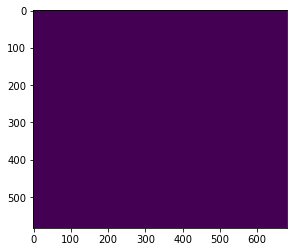

In [35]:
plt.imshow(preds[11]['prediction'][:, :, 0])

In [73]:
idx = 0
frame = 3
plt.imshow(test_data[idx]['video'][:, :, frame] + 255*preds[idx]['prediction'][:, :, frame])

NameError: name 'test_data' is not defined

In [16]:
f = 2

In [17]:
f+=1
plt.imshow(train_data[13]['video'][:, :, f])

NameError: name 'train_data' is not defined

In [ ]:
im = torch.Tensor()(train_data[13]['video'][:, :, f])
im2 = im
org_im = im[0]*0
im = transform(transforms.ToPILImage()(x[0]).resize((128,128)))
label = unet_model(im.unsqueeze(0)).clamp(0,1)
width = org_im.size(1)
height = org_im.size(2)
org_im = transforms.ToTensor()(transforms.ToPILImage()(label[0]).resize((height, width), Image.ANTIALIAS))
if previous_name == name:
    labels.append((previous_im.detach() + org_im.detach())>0.9)
else:
    labels.append(org_im.detach()>0.5)

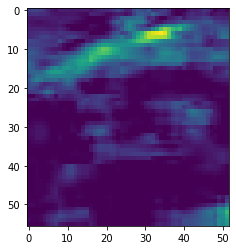

In [298]:
plt.imshow(test_data[12]['video'][preds[12]['box'][f][0]:preds[12]['box'][f][2], preds[12]['box'][f][1]:preds[12]['box'][f][3], f])

In [306]:
mean_box =np.mean(preds[12]['box'], axis = 0, dtype = int)

In [307]:
mean_box

array([266, 430, 320, 503])

In [311]:
mean_box[2] - mean_box[0]

54

In [312]:
mean_box[3] - mean_box[1]

73

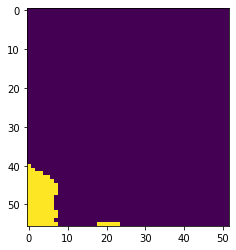

In [315]:
plt.imshow(preds[12]['prediction'][preds[12]['box'][f][0]:preds[12]['box'][f][2], preds[12]['box'][f][1]:preds[12]['box'][f][3], f])

In [83]:
test_data = load_zipped_pickle("test.pkl")

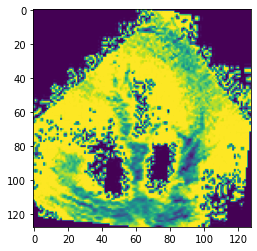

In [143]:
plt.imshow(train_ds[5][0][0].numpy())

In [16]:
ds = Custom_dataset('train.pkl', box_train = False, augmented = False, randomize = False,
                          size = (128, 128), crop_box = False)

In [17]:
len(test_ds_unet)

9804

In [18]:
len(ds)

195

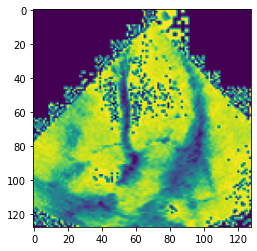

In [19]:
plt.imshow(test_ds_unet[0][0][0].numpy())

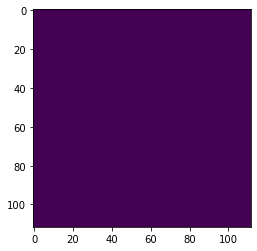

In [48]:
plt.imshow(labels[0][0].float().numpy())

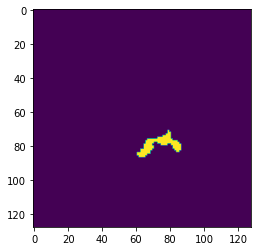

In [26]:
plt.imshow(unet_model(test_ds_unet[0][0].unsqueeze(0))[0][0].detach().numpy()>0.5)

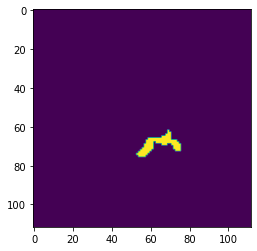

In [43]:
height = test_ds_unet[0][1].size(1)
width = test_ds_unet[0][1].size(2)
plt.imshow((transforms.ToTensor()(transforms.ToPILImage()(unet_model(test_ds_unet[0][0].unsqueeze(0)).clamp(0,1)[0][0]).resize((height, width)))>0.5)[0].float().numpy())

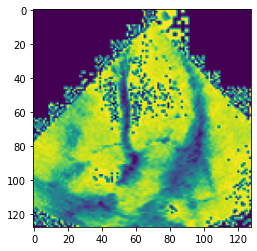

In [55]:
plt.imshow(test_ds_unet[0][0].unsqueeze(0).numpy()[0][0])

In [68]:
torch.mean(test_ds_unet[0][0])

tensor(0.2390)

In [69]:
torch.mean(trans_im)

tensor(-0.7238)

In [70]:
torch.mean(im)

tensor(0.1644, device='cuda:0')

In [62]:
transform

Compose(
    Grayscale(num_output_channels=1)
    ToTensor()
    Normalize(mean=0.438, std=0.378)
)

In [66]:
trans_im = transform(transforms.ToPILImage()(transforms.ToTensor()(train_data[0]['video'][:, :, 0])).resize((128,128)))

In [90]:
test_ds_unet[0][0]

tensor([[[-1.1587, -1.1587, -1.1587,  ..., -1.1587, -1.1587, -1.1587],
         [-1.1587, -1.1587, -1.1587,  ..., -1.1587, -1.1587, -1.1587],
         [-1.1587, -1.1587, -1.1587,  ..., -1.1587, -1.1587, -1.1587],
         ...,
         [ 0.9577,  1.4868, -0.5570,  ...,  0.4804, -1.1587, -1.1587],
         [-1.1587,  0.8539, -0.6504,  ..., -1.1587, -1.0965, -0.7541],
         [-1.1587, -1.1587, -1.1587,  ..., -1.1587, -0.7437,  1.4868]]])

In [86]:
image = transforms.ToPILImage()(torch.Tensor(test_ds_unet.data[0]['video'][:, :, 0]))
test_ds_unet.transform(image)

tensor([[[-1.1587, -1.1587, -1.1587,  ..., -1.1587, -1.1587, -1.1587],
         [-1.1587, -1.1587, -1.1587,  ..., -1.1587, -1.1587, -1.1587],
         [-1.1587, -1.1587, -1.1587,  ..., -1.1587, -1.1587, -1.1587],
         ...,
         [ 1.4868,  1.4868, -1.1587,  ...,  1.4868, -1.1587, -1.1587],
         [-1.1587,  1.4660, -1.1587,  ..., -1.1587, -1.1587, -1.1587],
         [-1.1587, -1.1587, -1.1587,  ..., -1.1587, -1.1587,  1.4868]]])

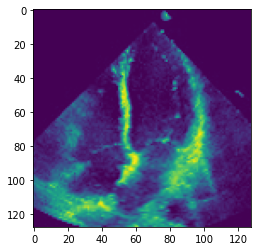

In [67]:
plt.imshow(trans_im.unsqueeze(0).cpu().numpy()[0][0])

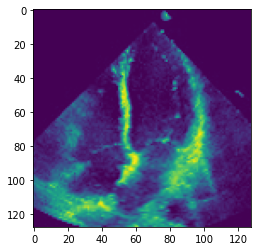

In [61]:
im = transforms.ToTensor()(transforms.ToPILImage()(transforms.ToTensor()(train_data[0]['video'][:, :, 0])).resize((128,128))).cuda()
plt.imshow(im.unsqueeze(0).cpu().numpy()[0][0])

In [80]:
train_ds_box = Custom_dataset('train.pkl', box_train = True,
                              augmented = False, randomize = True,
                              size = (128, 128))

In [89]:
train_data = train_data = load_zipped_pickle("train.pkl")

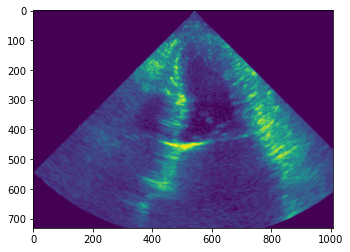

In [81]:
box_model = Resnet50(num_classes = 4,
                 in_channels = 1)
box_model.load_state_dict(torch.load('best_model_box.pth'))

idx = 60
box_model.eval()
im = train_data[idx//10]['video'][:, :, idx%10]
width, height = im.shape[0], im.shape[1]
bb = box_model(transform(transforms.ToPILImage()(torch.Tensor(im)).resize((128,128))).unsqueeze(0))
x1 = transforms.ToPILImage()(torch.Tensor(im)).size[0]*bb[0][0].item()
x2 = transforms.ToPILImage()(torch.Tensor(im)).size[0]*bb[0][2].item()
y1 = transforms.ToPILImage()(torch.Tensor(im)).size[1]*bb[0][1].item()
y2 = transforms.ToPILImage()(torch.Tensor(im)).size[1]*bb[0][3].item()
tip = np.zeros((width, height))
tip[int(y1):int(y2), int(x1):int(x2)] += 1
plt.imshow(im + tip*255)

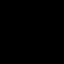

In [82]:
crop_im1 = crop_resize(transforms.ToPILImage()(torch.Tensor(im)), bb[0].detach().numpy(), 64, 64)
crop_im1

In [83]:
unet_model.cpu()
crop_im = transform(crop_im1)
new_im = (transforms.ToTensor()(transforms.ToPILImage()(unet_model(crop_im.unsqueeze(0)).clamp(0,1)[0][0]).resize((int(x2)-int(x1), int(y2) -int(y1))))>0.5)[0].float().numpy()
tip = np.zeros((width, height))
tip[int(y1):int(y2), int(x1):int(x2)] = new_im
plt.imshow(im + 255*tip)

ValueError: height and width must be > 0

In [85]:
unet_model2 = UNet(in_channels=1,
             num_encoding_blocks = 4,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 64,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
unet_model2.load_state_dict(torch.load('best_model_unet_nobo_64_bis.pth'))
#unet_model.load_state_dict(torch.load('best_model_unet_32.pth'))

<All keys matched successfully>

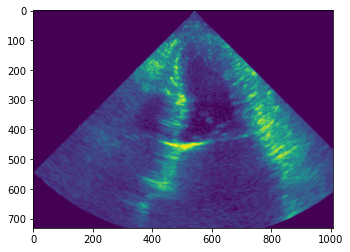

In [88]:
im1 = transforms.ToPILImage()(torch.Tensor(im)).resize((128,128))
label = unet_model2(transform(im1).unsqueeze(0)).clamp(0,1)
width = im.shape[0]
height = im.shape[1]
org_im = (transforms.ToTensor()(transforms.ToPILImage()(label[0]).resize((height, width), Image.ANTIALIAS))>0.7).float()
plt.imshow(im + org_im[0].numpy()*255)

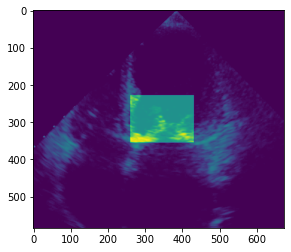

In [183]:
box = train_data[idx//10]['box']
bb1 = [min(np.where(box)[1]),
    min(np.where(box)[0]),
    max(np.where(box)[1]),
    max(np.where(box)[0])]
x1 = bb1[0]
x2 = bb1[2]
y1 = bb1[1]
y2 = bb1[3]
tip = np.zeros((width, height))
tip[int(y1):int(y2), int(x1):int(x2)] += 1
plt.imshow(im + tip*255)

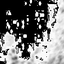

In [184]:
bb2 = [min(np.where(box)[1])/box.shape[0],
    min(np.where(box)[0])/box.shape[1],
    max(np.where(box)[1])/box.shape[0],
    max(np.where(box)[0])/box.shape[1]]
crop_im2 = crop_resize(transforms.ToPILImage()(torch.Tensor(im)), bb2, 64, 64)
crop_im2

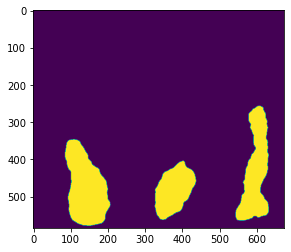

In [185]:
crop_im3 = transform(crop_im2)
plt.imshow((transforms.ToTensor()(transforms.ToPILImage()(unet_model(crop_im3.unsqueeze(0)).clamp(0,1)[0][0]).resize((height, width)))>0.5)[0].float().numpy())

In [41]:
box_model.eval()
bb = box_model(transform(transforms.ToPILImage()(torch.Tensor(test_ds_unet[0][1])).resize((128,128))).unsqueeze(0))

0 0
tensor(59.8801)


0 0
tensor(59.8801)
0 0
tensor(59.8801)
0 0
tensor(59.8801)


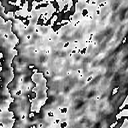

In [46]:
height = test_ds_unet[0][1].size(2)
width = test_ds_unet[0][1].size(1)
crop_resize(transforms.ToPILImage()(torch.Tensor(test_ds_unet[0][1])), bb[0].detach().numpy(), 128, 128)

In [30]:
height

863

In [32]:
height = test_ds_unet[0][1].size(2)
width = test_ds_unet[0][1].size(1)
#im = transform(transforms.ToPILImage()(transforms.ToTensor()(train_data[0]['video'][:, :, 0])).resize((128,128))).cuda()
plt.imshow((transforms.ToTensor()(transforms.ToPILImage()(test_ds_unet[0][0][0])).resize((height, width)))>0.5)[0].float().numpy()

0 0
tensor(59.8801)
0 0
tensor(59.8801)
0 0
tensor(59.8801)


RuntimeError: requested resize to (583, 863) ((583, 863) elements in total), but the given tensor has a size of 1x128x128 (16384 elements). autograd's resize can only change the shape of a given tensor, while preserving the number of elements. 

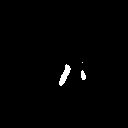

In [44]:
height = ds[0][1].size(1)
width = ds[0][1].size(2)
transforms.ToPILImage()((transforms.ToTensor()(transforms.ToPILImage()(unet_model(ds[0][0].unsqueeze(0)).clamp(0,1)[0][0]).resize((height, width)))>0.5).float())

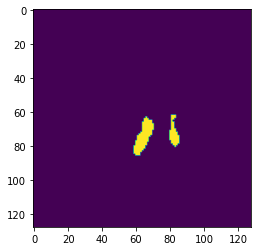

In [28]:
plt.imshow(unet_model(ds[0][0].unsqueeze(0))[0][0].detach().numpy()>0.4)

In [6]:
fifteenth = load_zipped_pickle("fifteenth_submission.pkl")
eleventh = load_zipped_pickle("eleventh_submission.pkl")
nineteenth = load_zipped_pickle("nineteenth_submission.pkl")
thirtythird = load_zipped_pickle("thirtythird_submission.pkl")

In [7]:
sample = load_zipped_pickle("sample.pkl")

In [8]:
for i in range(len(sample)):
    sample[i]['prediction'] = ((thirtythird[i]['prediction'].astype(int) + fifteenth[i]['prediction'].astype(int) + 0.5*eleventh[i]['prediction'].astype(int) + 0.5*nineteenth[i]['prediction'].astype(int))/3) > 0.5

In [10]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
save_zipped_pickle(sample, 'thirtyfifth_submission.pkl')

In [36]:
preds = load_zipped_pickle("fifteenth_submission.pkl")
for pred in preds:
    vid = pred['prediction']
    valve_aniso = np.empty_like(vid)
    for i in range(vid.shape[2]):
        fr = vid[: ,: , i]
        valve_diffused = mp.anisotropic_diffusion(fr, niter=2, kappa=20, option=3)
        valve_aniso[: ,: , i] = valve_diffused
    pred['prediction'] = valve_aniso

/home/mawskay/anaconda3/lib/python3.7/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/mawskay/anaconda3/lib/python3.7/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)
